# Tau PT Regression Notebook

In this notebook we will implement a NN to regress the tau's transverse momentum and analyze its performance.

In [173]:
# Imports
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers

import random

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_pT_name = '../models/pt_regress_v1.h5'
model_pT_name_best = '../models/pt_regress_v1_bestest.h5'

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [174]:
# lower the number of injections of MinBias to get rid of the bias torwards lower pT predictions

def create_train_test_data(dir_path, reco_pt_cut = 10, minbias_percent = 0.7, test_index=400000, train = True):
        
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    if train:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    else:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
    selection_bkg = reco_pt_bkg > reco_pt_cut
    y_bkg_pT = truth_pt_bkg[selection_bkg]
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > reco_pt_cut
    y_qcd_pT = truth_pt_qcd[selection_qcd]
        
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    background_pt = np.concatenate([bkg_pt, qcd_pt])
    
    print(y_sig, y_bkg, y_qcd)
    
    if train:
        X_bkg = list(X_bkg)
        y_bkg = list(y_bkg)
        y_bkg_pT = list(y_bkg_pT)
        percent = minbias_percent
        for _ in range(int(percent*len(X_bkg))):
            n = len(X_bkg)
            random_ind = random.randint(0, n - 1)
            del X_bkg[random_ind]
            del y_bkg[random_ind]
            del y_bkg_pT[random_ind]
        X_bkg = np.asarray(X_bkg)
        y_bkg = np.asarray(y_bkg)
        y_bkg_pT = np.asarray(y_bkg_pT)
        
        X_qcd = list(X_qcd)
        y_qcd = list(y_qcd)
        y_qcd_pT = list(y_qcd_pT)
        for _ in range(int(percent*len(X_qcd))):
            n = len(X_qcd)
            random_ind = random.randint(0, n - 1)
            del X_qcd[random_ind]
            del y_qcd[random_ind]
            del y_qcd_pT[random_ind]
        X_qcd = np.asarray(X_qcd)
        y_qcd = np.asarray(y_qcd)
        y_qcd_pT = np.asarray(y_qcd_pT)

    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
    MinBias_pT_1 = [1 for i in y_bkg_pT]
    qcd_pT_1 = [1 for i in y_qcd_pT]
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
    y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
    pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
    X_train[abs(X_train) > 1e+4] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train_jetID))
    assert not np.any(np.isnan(y_train_pT))
    
    return X_train, y_train_jetID, y_train_pT

In [175]:
X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", 
                                                                         reco_pt_cut = 10,
                                                                         minbias_percent = 0.7,
                                                                         train=True)

X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", 
                                                                        reco_pt_cut = 10,
                                                                        minbias_percent = 0.7,
                                                                        train=False)
X_train = X_train_jetID
y_train = y_train_pT_regress
X_test = X_test_jetID
y_test = y_test_pT_regress

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


## Model

In [176]:
model = Sequential()

model.add(tf.keras.Input(shape=(80,)))


model.add(Dense(25,
                #input_shape=(X_train.shape[1:]),
                activation= 'LeakyReLU'))

model.add(Dense(25,
                #input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))

model.add(Dense(10,
                #input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))

model.add(Dense(1))

In [177]:
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 25)                2025      
                                                                 
 dense_33 (Dense)            (None, 25)                650       
                                                                 
 dense_34 (Dense)            (None, 10)                260       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,946
Trainable params: 2,946
Non-trainable params: 0
_________________________________________________________________


In [178]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=256,
                    verbose=2,
                    validation_split=0.2, 
                    callbacks = [callback])

Epoch 1/30
646/646 - 2s - loss: 1.1649 - val_loss: 0.1906 - 2s/epoch - 3ms/step
Epoch 2/30
646/646 - 1s - loss: 0.2013 - val_loss: 0.1195 - 1s/epoch - 2ms/step
Epoch 3/30
646/646 - 1s - loss: 0.1846 - val_loss: 0.1307 - 1s/epoch - 2ms/step
Epoch 4/30
646/646 - 1s - loss: 0.1761 - val_loss: 0.0944 - 1s/epoch - 2ms/step
Epoch 5/30
646/646 - 1s - loss: 0.1692 - val_loss: 0.0933 - 1s/epoch - 2ms/step
Epoch 6/30
646/646 - 1s - loss: 0.1652 - val_loss: 0.0872 - 1s/epoch - 2ms/step
Epoch 7/30
646/646 - 1s - loss: 0.1606 - val_loss: 0.0909 - 1s/epoch - 2ms/step
Epoch 8/30
646/646 - 1s - loss: 0.1594 - val_loss: 0.0779 - 1s/epoch - 2ms/step
Epoch 9/30
646/646 - 1s - loss: 0.1564 - val_loss: 0.1015 - 1s/epoch - 2ms/step
Epoch 10/30
646/646 - 1s - loss: 0.1551 - val_loss: 0.0760 - 1s/epoch - 2ms/step
Epoch 11/30
646/646 - 1s - loss: 0.1546 - val_loss: 0.0988 - 1s/epoch - 2ms/step
Epoch 12/30
646/646 - 1s - loss: 0.1539 - val_loss: 0.0885 - 1s/epoch - 2ms/step
Epoch 13/30
646/646 - 1s - loss: 0.15

In [179]:
#Save the model
model.save(model_pT_name)

-----

## Evaluate the model 

So now that we trained for the ratio, let's plot it on the testing set!

**Now compare the truth pT distribution and the predicted distribution (just multiply it by the ratio)**

### Load the model to be evaluated

In [198]:
model = load_model('../models/pt_regress_v1_bestest.h5') # loads the best trained model to date
#model = load_model(model_pT_name) # loads the model that was can be trained from the training above

# pT Distribution Plot

In [199]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test).flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 2s 1ms/step


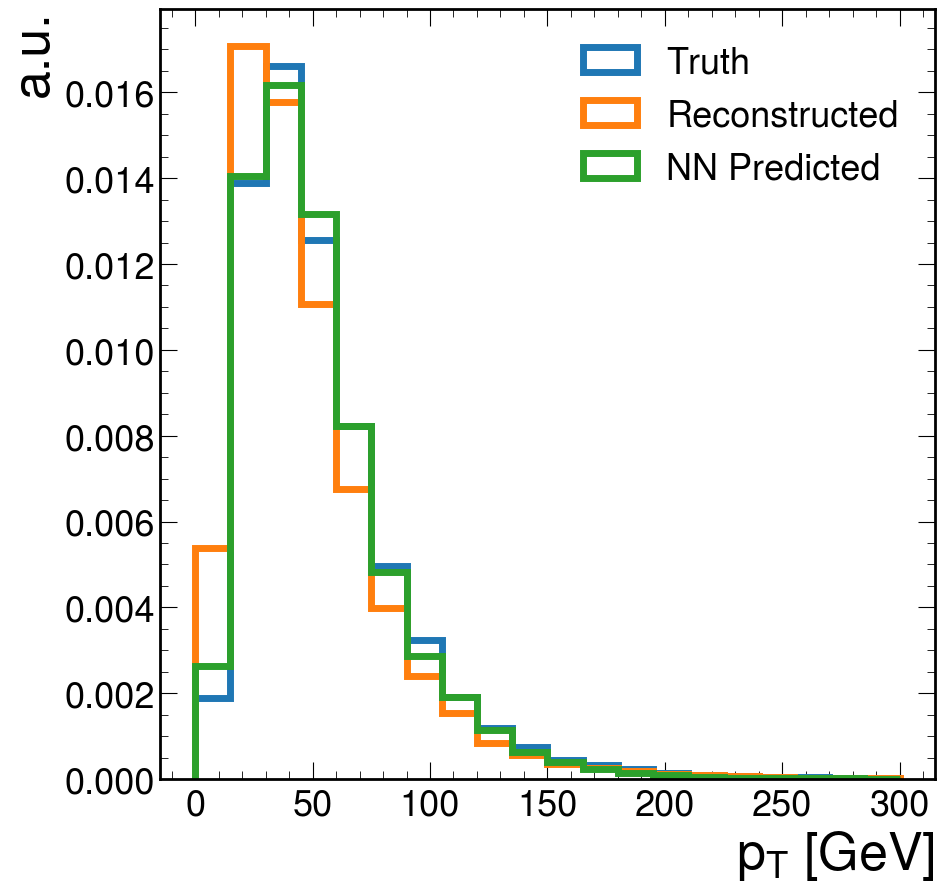

In [200]:
load_and_predict_test("../../ntuples/Jan_25_2023", model)

# Resolution + Response Plots

In [201]:
def resolution(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test).flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))
    
    plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()


2043/2043 [==============================] - 2s 946us/step
-738.8678
4544.9214
Error for parameter esimations:  [0.00164242 0.23224095 0.20048455]
Standard deviation (fit) is 7.991776566263976
Mean (fit) is -0.7279981618610768


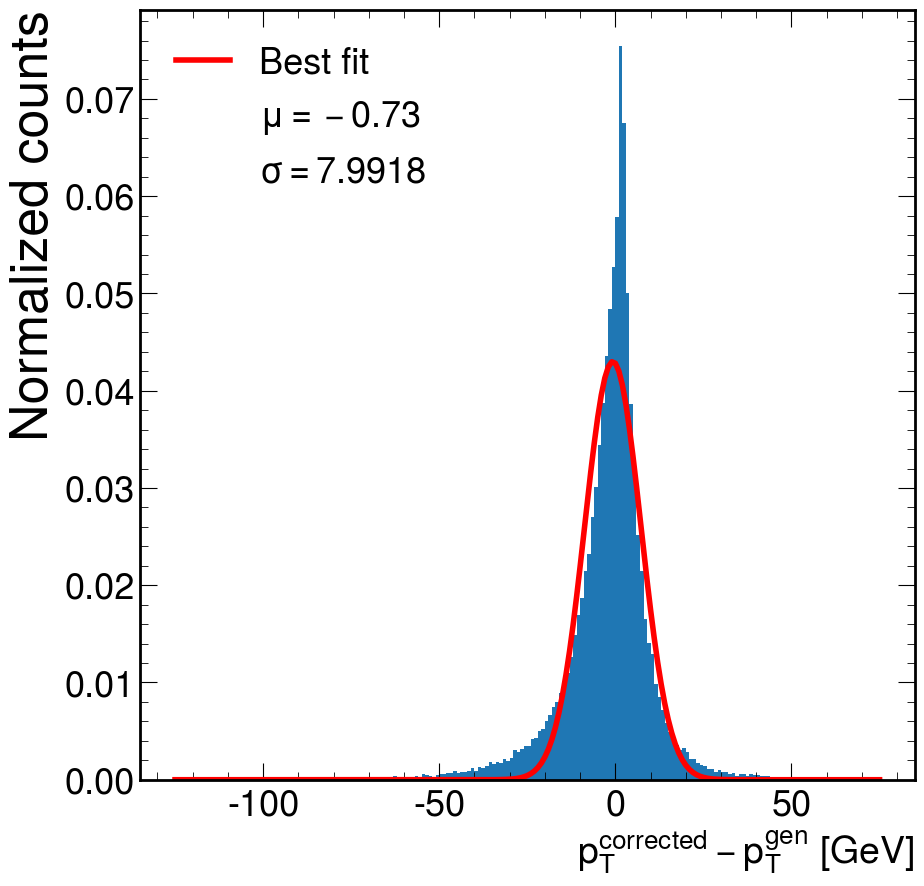

In [202]:
resolution("../../ntuples/Jan_25_2023", model)

# Rate ROC Plot

In [203]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5' # Official classification NN

In [204]:
def prep_rate_data(ModelNameID,
             ModelRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(ModelNameID)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    model_regress = ModelRegress
    
    minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    sig_list_corrected = []
    bkg_list_corrected = []

    for tau_score_cut in tau_score_edges:
        bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
        sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

        sig_list_corrected.append(sig_pass/n_sig_event)
        bkg_list_corrected.append(bkg_pass/n_event)

    bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]
    
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)
    plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Tau NN ID ($p_T$ Correction)',linewidth=5)
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")

    plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
    plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

    plt.yscale('log')
    #plt.ylim([10e-2,10e+4])
    plt.legend(loc='best',fontsize=20)
    plt.show()
    
    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 1ms/step


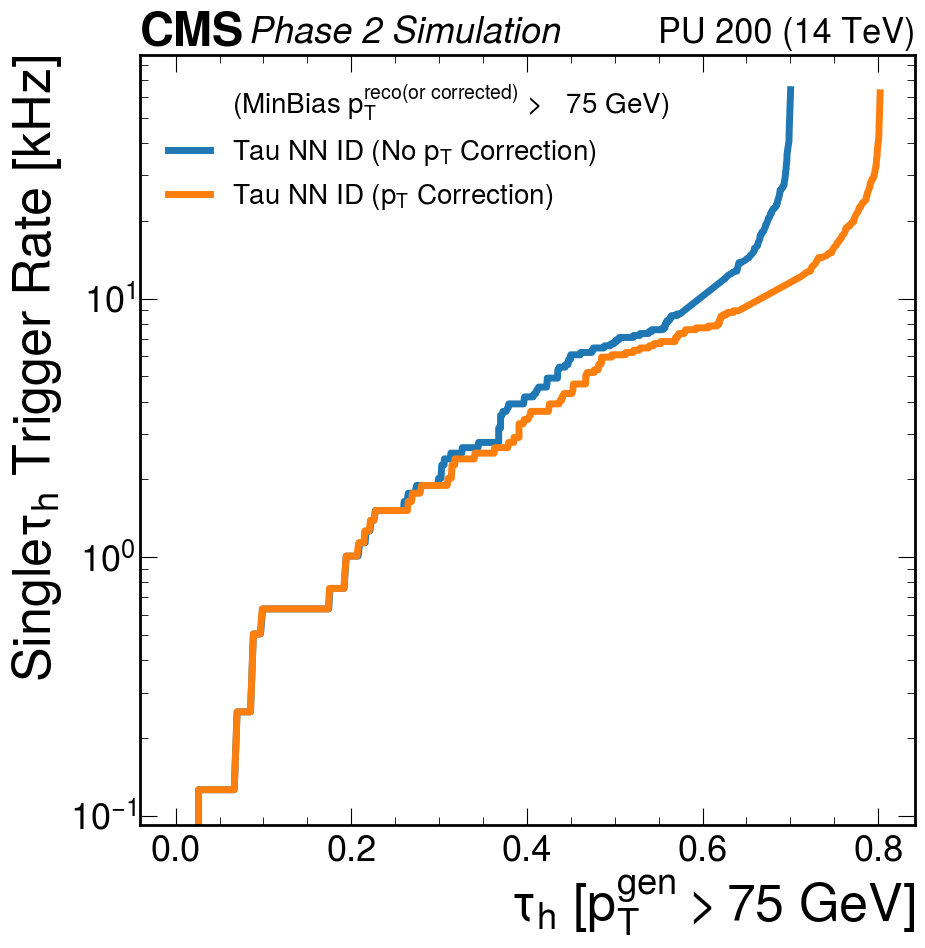

In [205]:
n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    model,
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)

# Efficiency Plot

In [211]:
def plot_pt_eff_puppi(ModelName,
                      Model_Regress,
                      DataPath,
                      NN = True,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=1.,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model_id = load_model(ModelName)
    model_pt_regress = Model_Regress

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]
    
    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    
    if NN: #if the flag for using pT correction or is True, correct for pT into corrected_pt_sig
        ratio_predict = model_pt_regress.predict(np.asarray(sig_input)).flatten()
        corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)
        selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
        #Originally (reco_pt_sig>1.) 
    else: #else, simply use reco_pt_sig
        selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
        
    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model_id.predict(np.nan_to_num(X_sig))

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = np.linspace(0, 150, 100) #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'center right')
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

1831/1831 [==============================] - 2s 1ms/step


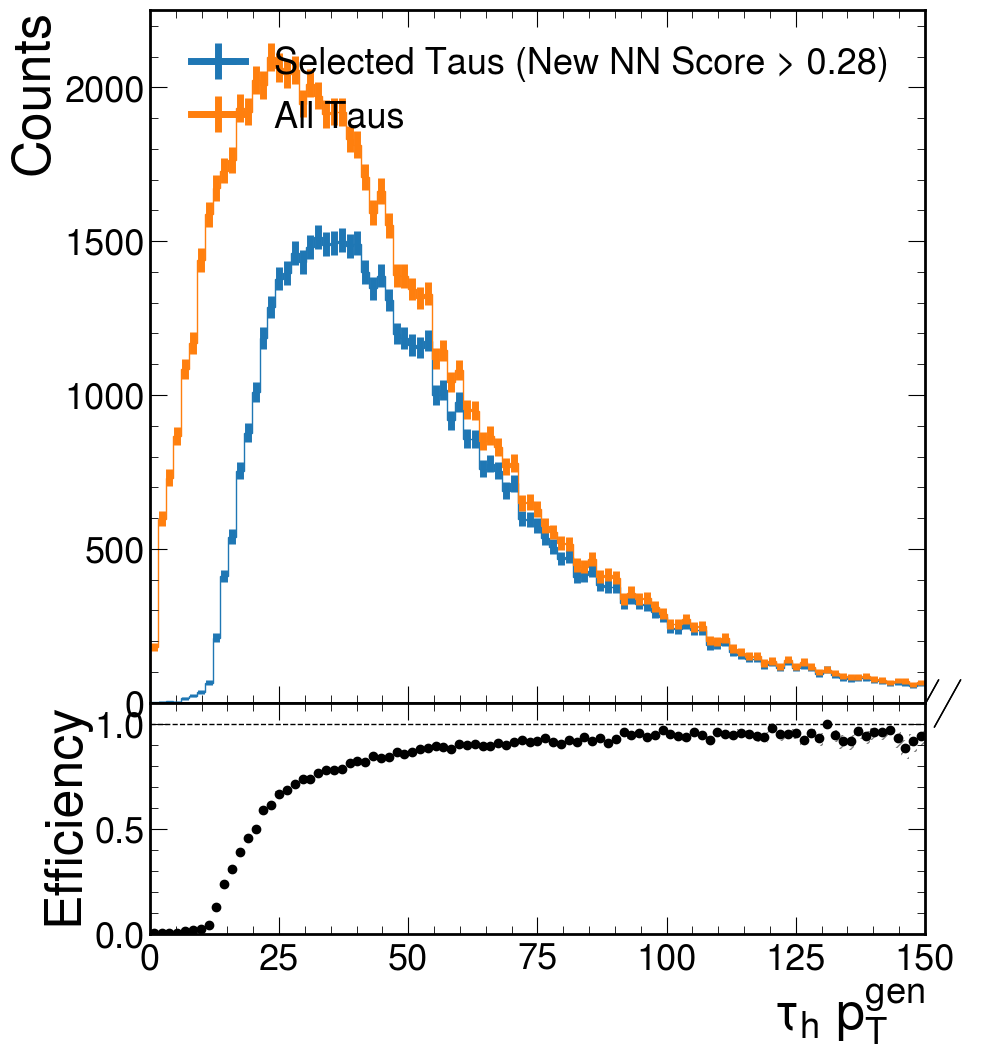

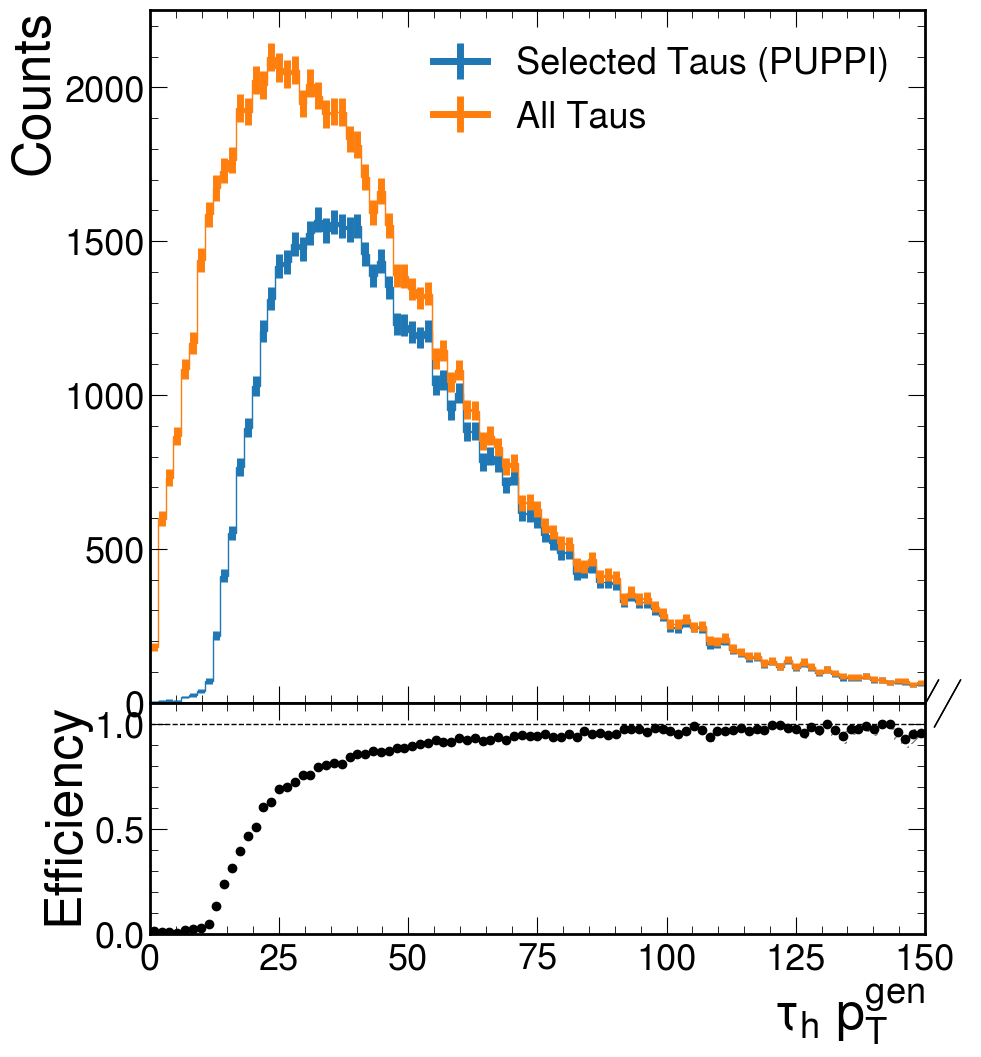

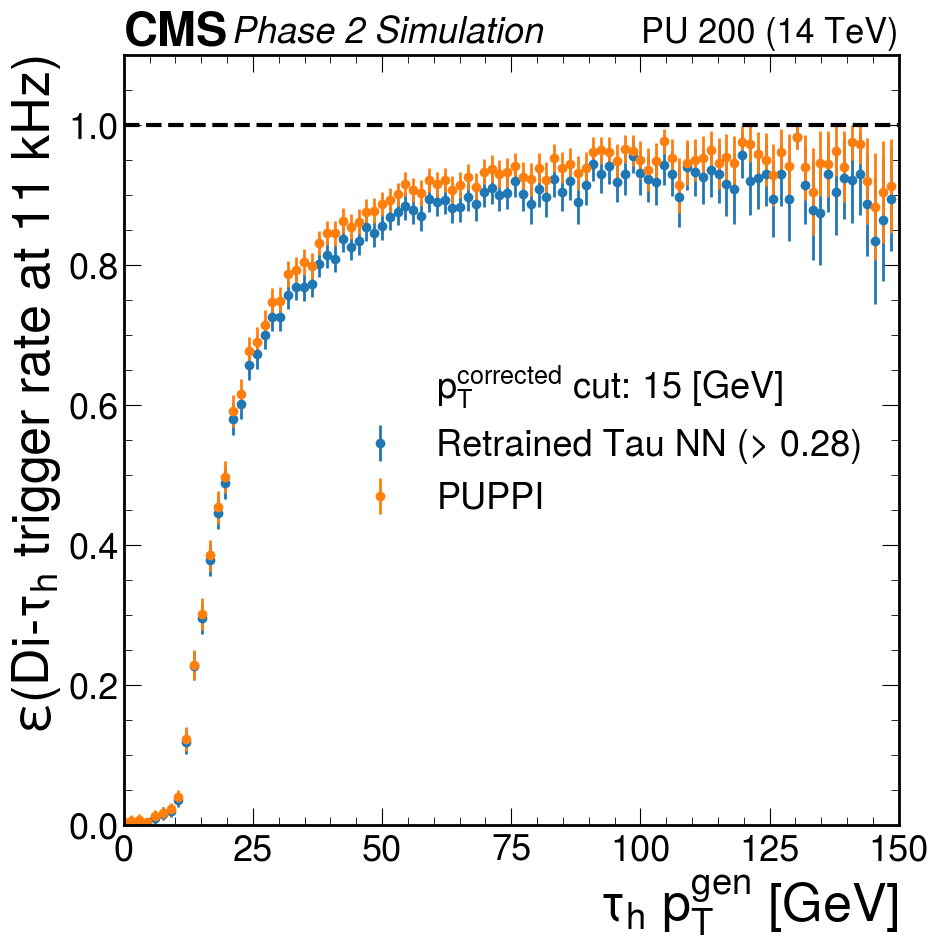

In [212]:
results = plot_pt_eff_puppi(model_id_name,
                            model,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            NN = True,
                            corrected_pt_cut=15.,
                            cut_point = 0.28)

# 95% Efficiency Plot

In [213]:
def plot_95th(threshold_list, model_id_name, model_pT, DataPath, cut_point = 0.28):
    
    threshold_list = threshold_list

    # pT NN correction
    
    results = plot_pt_eff_puppi(model_id_name,
                                model_pT,
                                DataPath,
                                NN = True,
                                corrected_pt_cut=0,
                                cut_point = cut_point)
    no_cut_x = np.asarray(results[0])
    no_cut_y = np.asarray(results[1])


    gen_pT_list = []
    for i in threshold_list:
        result = plot_pt_eff_puppi(model_id_name,
                                model_pT,
                                DataPath,
                                NN = True,
                                corrected_pt_cut=i,
                                cut_point = cut_point)
        cut_x = np.asarray(result[0])
        cut_y = np.asarray(result[1])
        y_norm = np.divide(cut_y, no_cut_y)
        for i in range(10):
            if y_norm[i] == 1:
                y_norm[i] = 0
            else:
                break
        gen_pT_list.append(cut_x[y_norm > 0.95][0])
    gen_pT_list_nn = gen_pT_list
    
    # no pT NN correction
    
    results = plot_pt_eff_puppi(model_id_name,
                                model_pT,
                            DataPath,
                            NN = False,
                            corrected_pt_cut=0,
                            cut_point = cut_point)
    no_cut_x = np.asarray(results[0])
    no_cut_y = np.asarray(results[1])


    gen_pT_list = []
    for i in threshold_list:
        result = plot_pt_eff_puppi(model_id_name,
                                model_pT,
                                DataPath,
                                NN = False,
                                corrected_pt_cut=i,
                                cut_point = cut_point)
        cut_x = np.asarray(result[0])
        cut_y = np.asarray(result[1])
        y_norm = np.divide(cut_y, no_cut_y)
        for i in range(10):
            if y_norm[i] == 1:
                y_norm[i] = 0
            else:
                break
        gen_pT_list.append(cut_x[y_norm > 0.95][0])
    gen_pT_list_no_nn = gen_pT_list
    
    # Plotting final plot
    
    a, b = np.polyfit(threshold_list, gen_pT_list_nn, 1)
    c, d = np.polyfit(threshold_list, gen_pT_list_no_nn, 1)
    fig = plt.figure()
    plt.plot(threshold_list, [a*i + b for i in threshold_list], "--", linewidth = 1)
    plt.plot(threshold_list, gen_pT_list_nn, "o-", fillstyle='none', linewidth = 1, label = "NN Corrected pT (y = " + str(round(a, 2)) + "x" + " + " + str(round(b, 2)) + ")", color = 'C0')
    plt.plot(threshold_list, [c*i + d for i in threshold_list], "--", linewidth = 1, color = 'r')
    plt.plot(threshold_list, gen_pT_list_no_nn, "o-", fillstyle='none', linewidth = 1, label = "PUPPI Reco pT (y = " + str(round(c, 2)) + "x" + " + " + str(round(d, 2)) + ")", color = 'r')
    #plt.xlim([20,85])
    #plt.xlim([20,85])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$p_T$ Cut Threshold [GeV]", fontsize = 25)
    plt.ylabel(r"$95\%$ Efficiency Point [GeV]", fontsize = 25)
    plt.legend(loc = 'upper left', fontsize = 18.5)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()


1905/1905 [==============================] - 2s 1ms/step


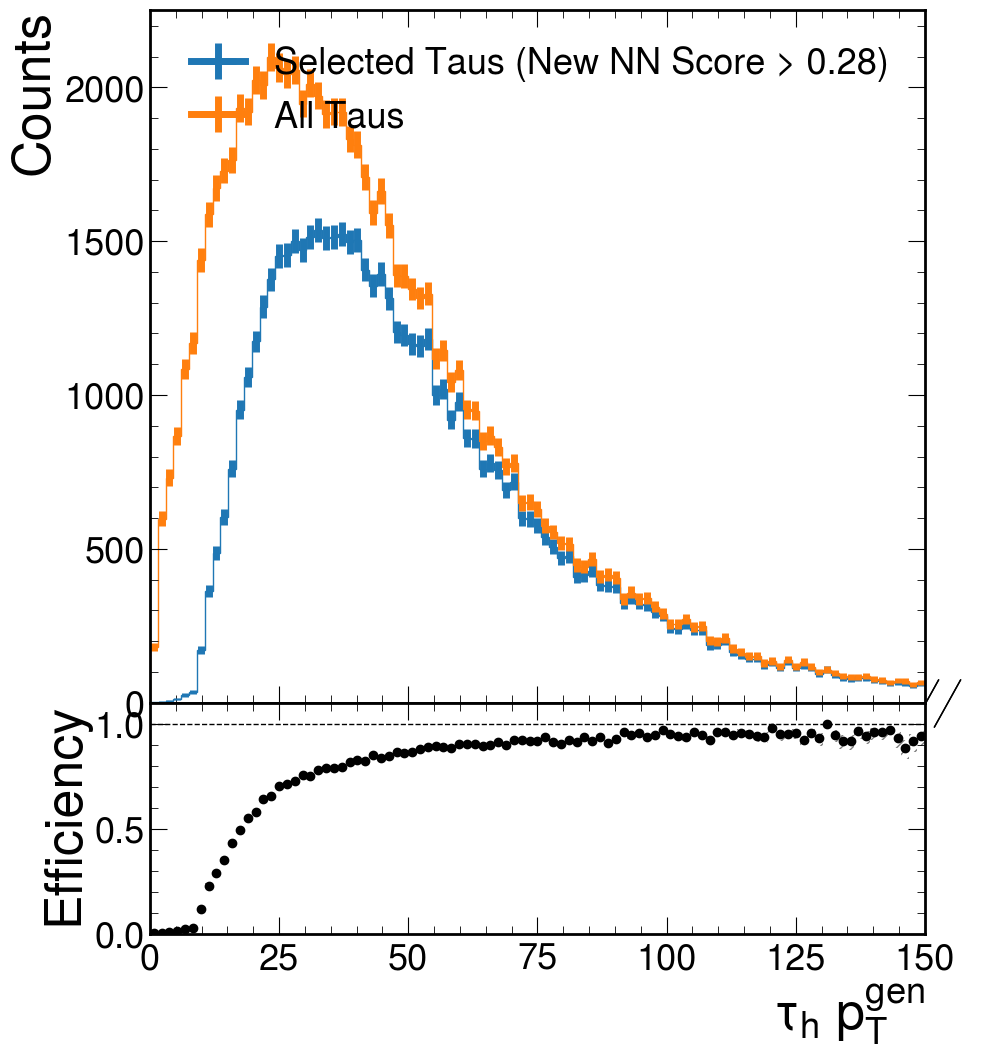

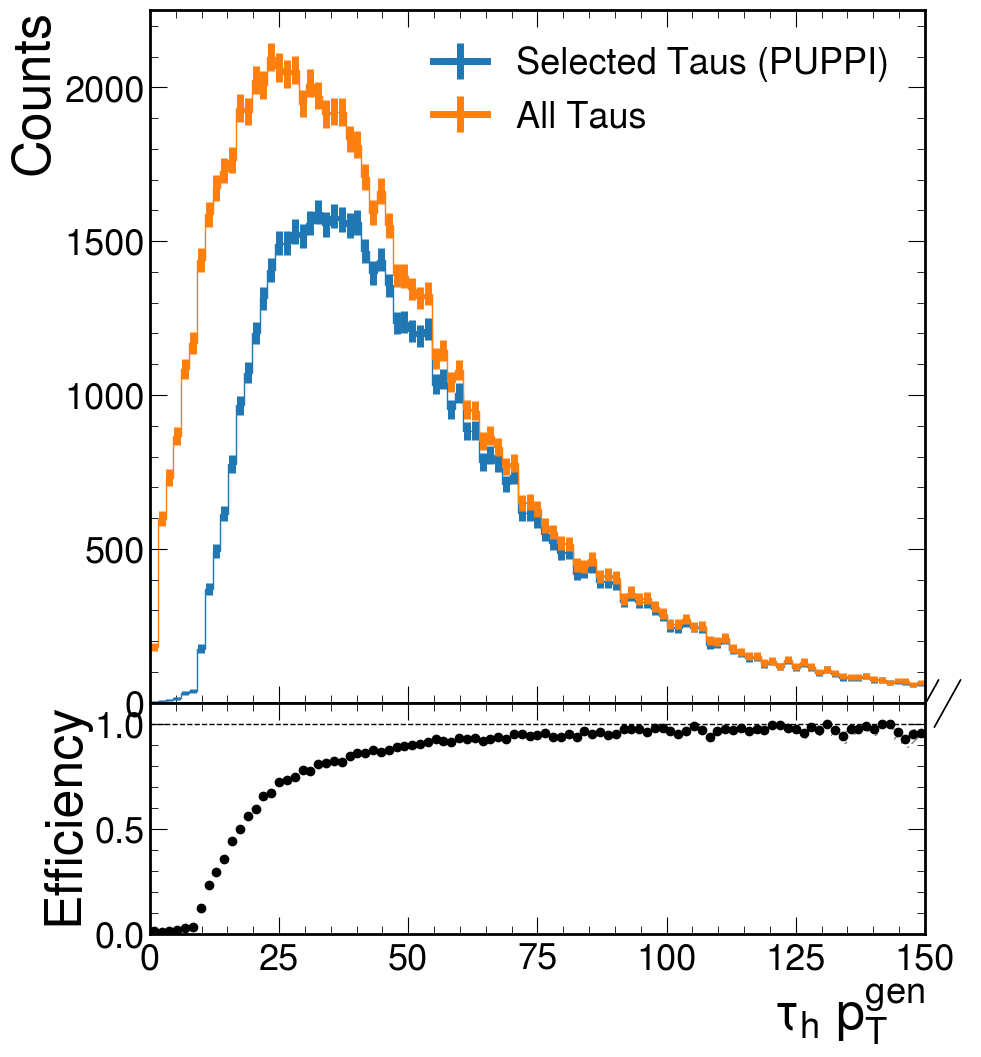

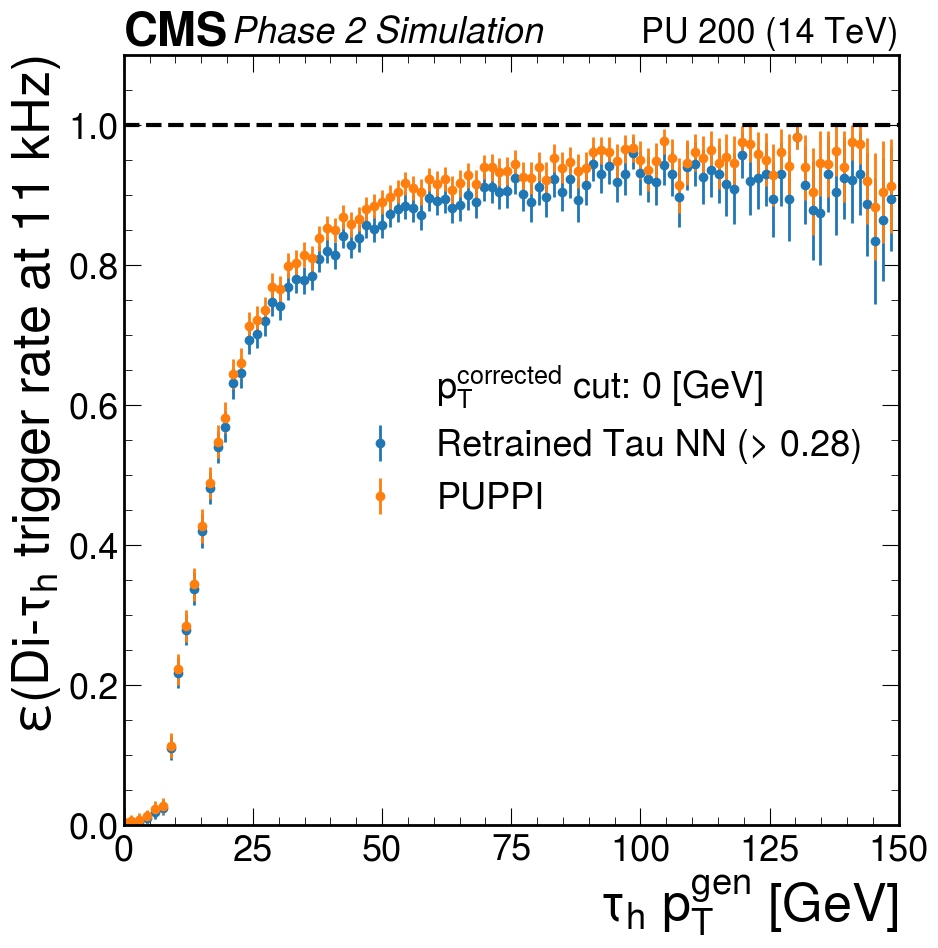

1831/1831 [==============================] - 3s 1ms/step


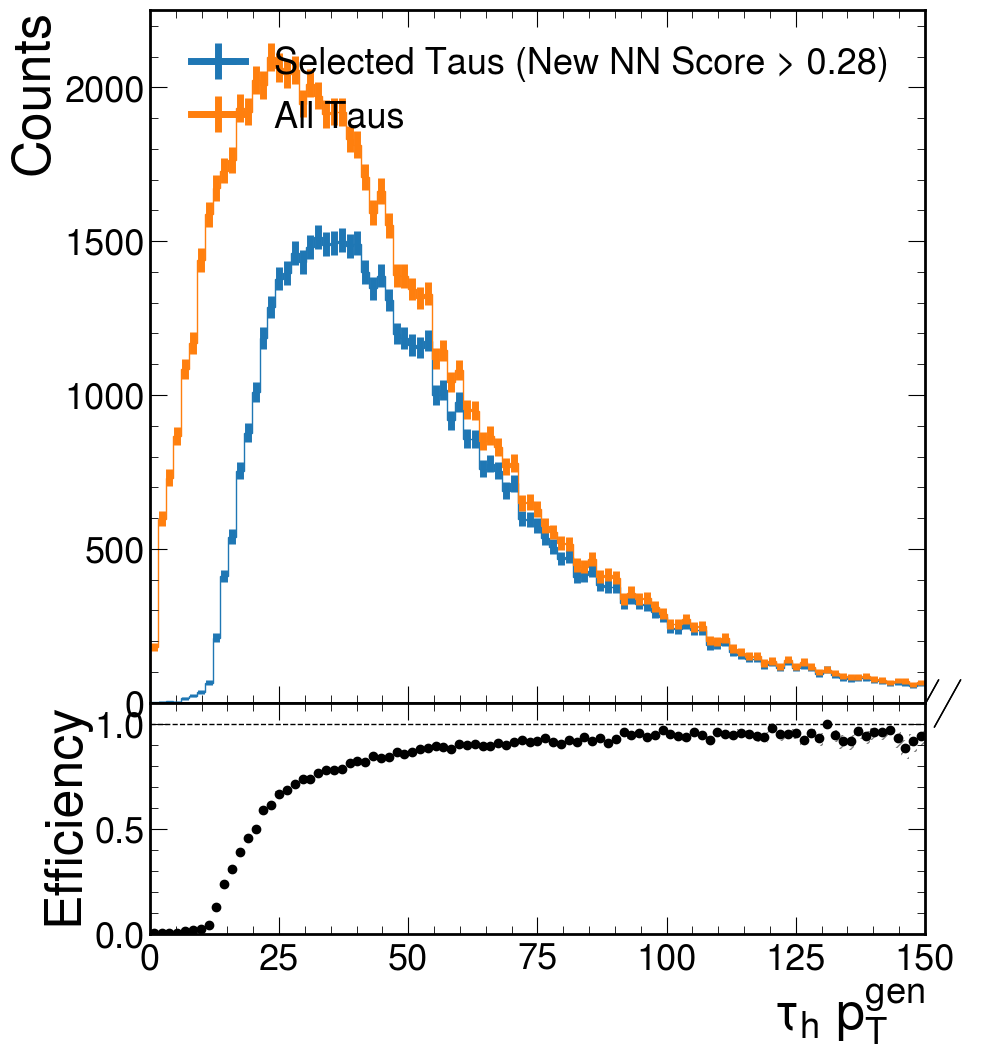

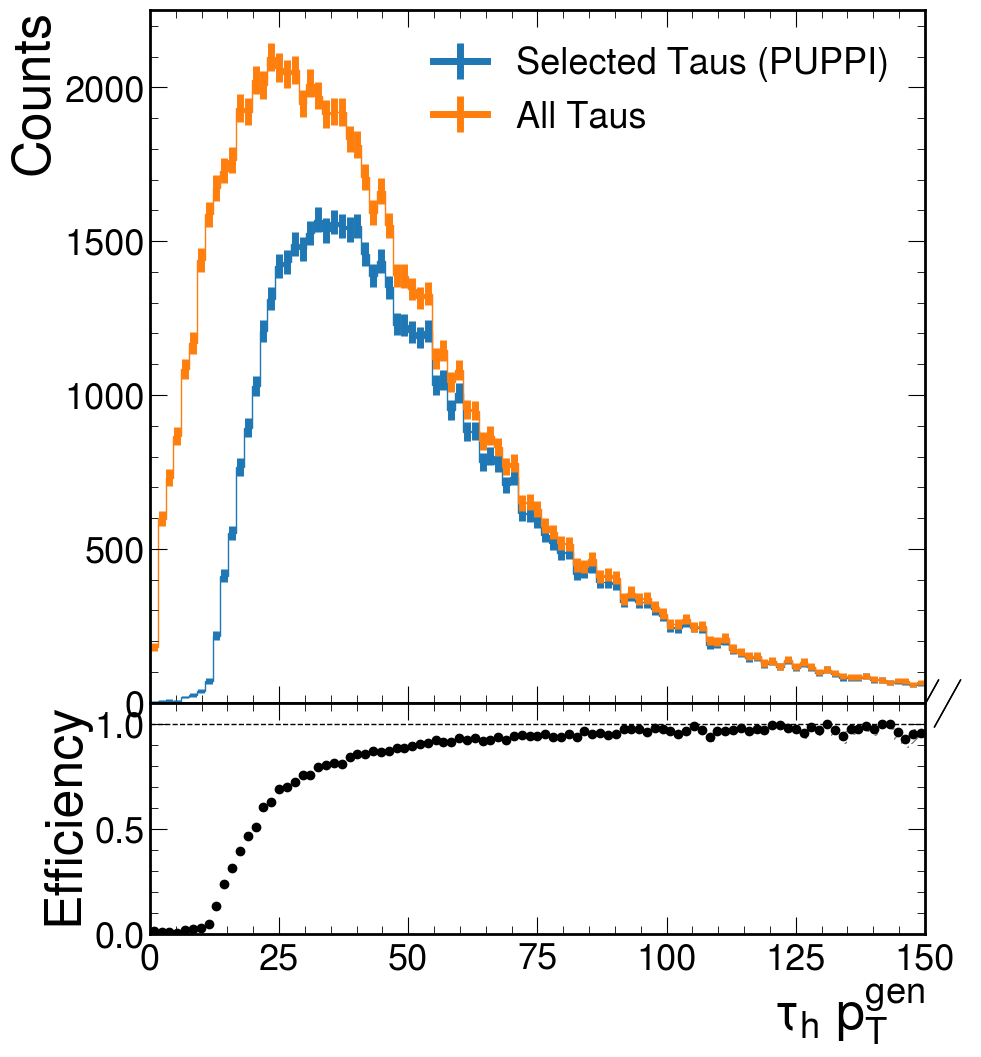

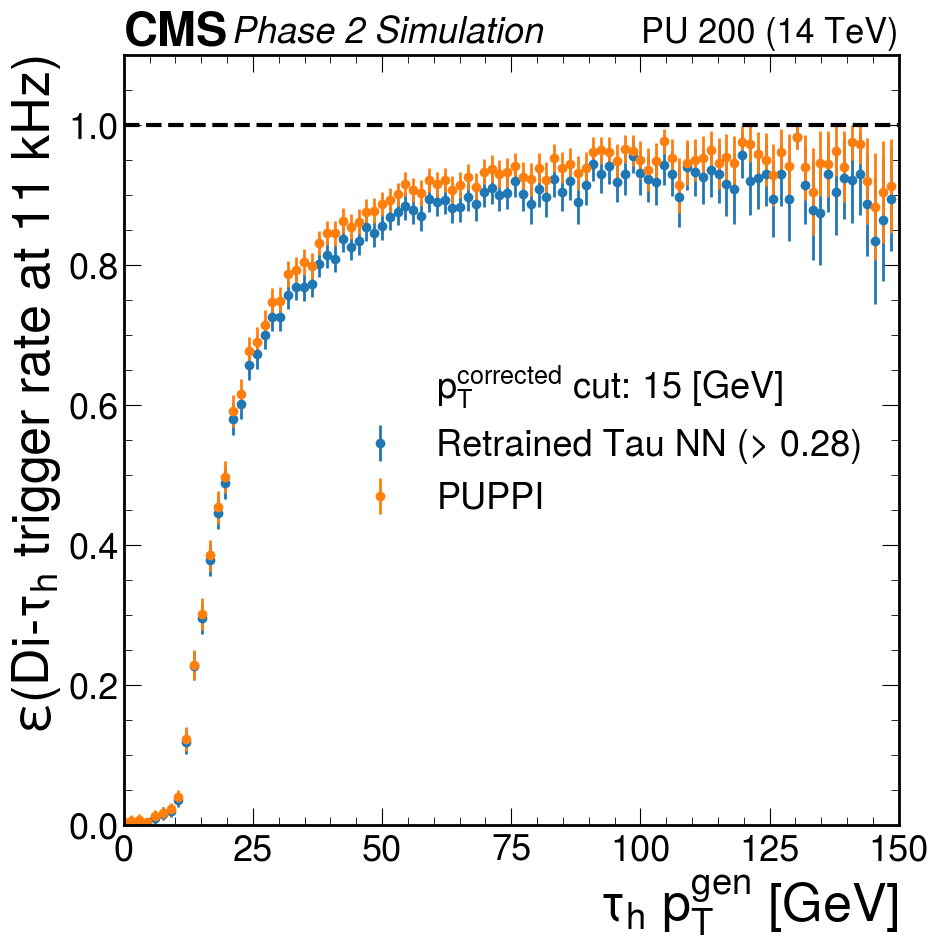

1706/1706 [==============================] - 2s 960us/step


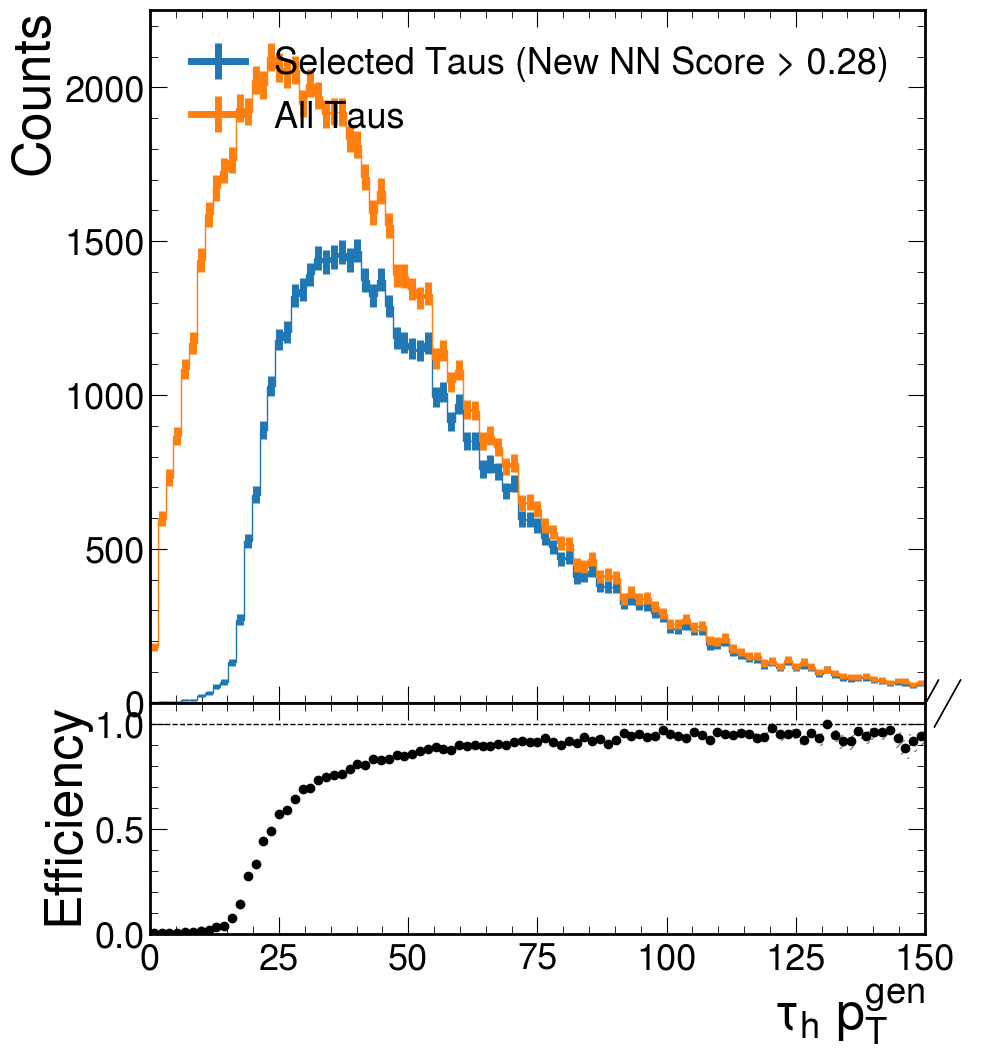

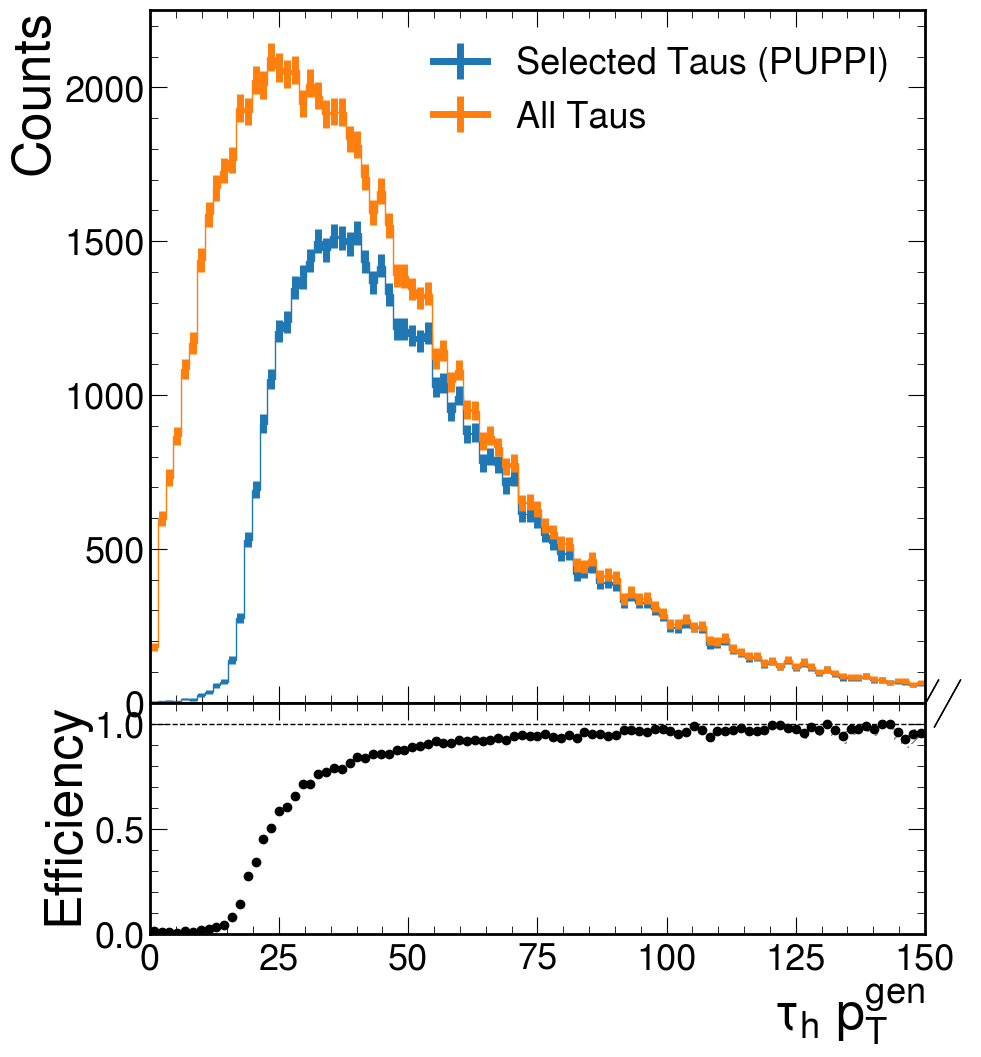

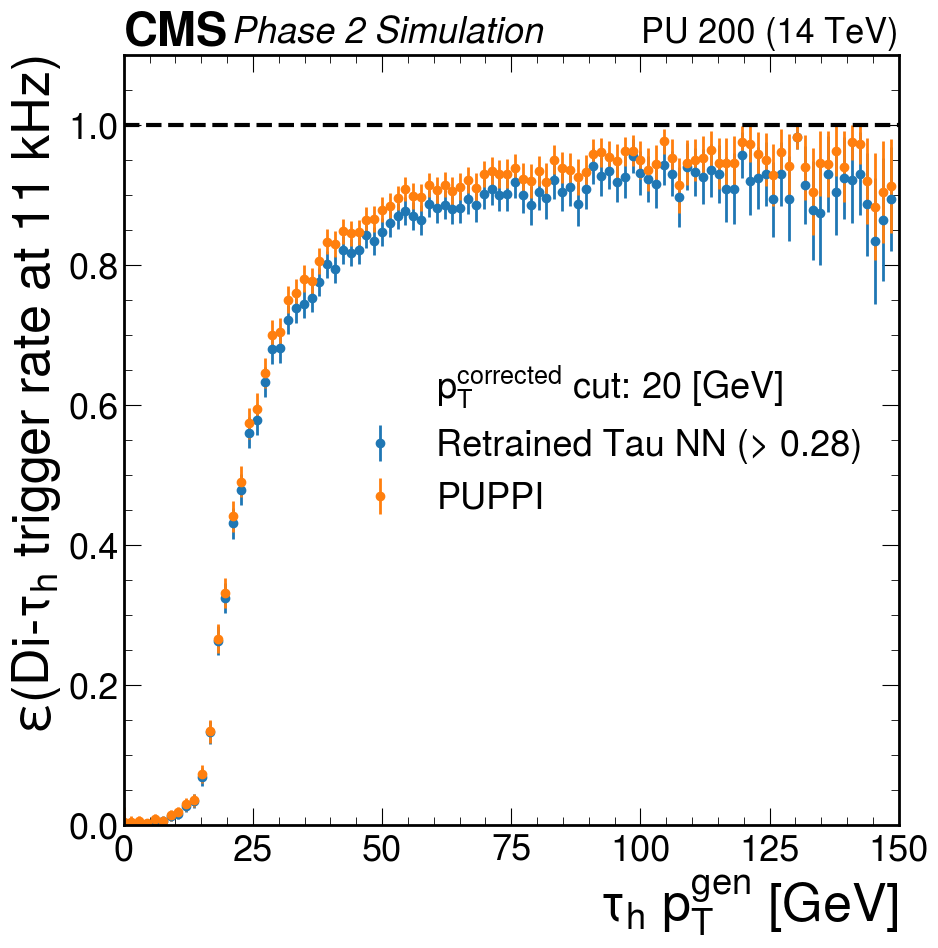

1576/1576 [==============================] - 2s 1ms/step


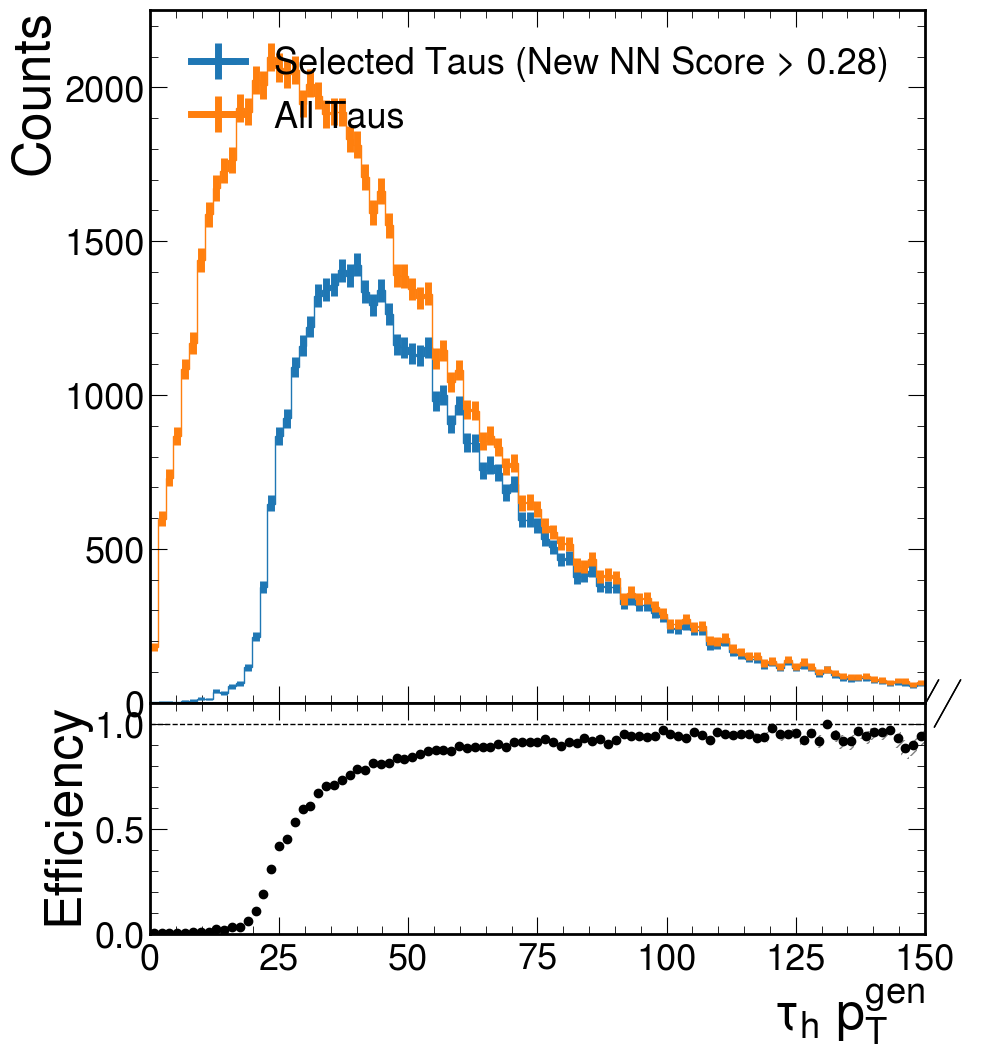

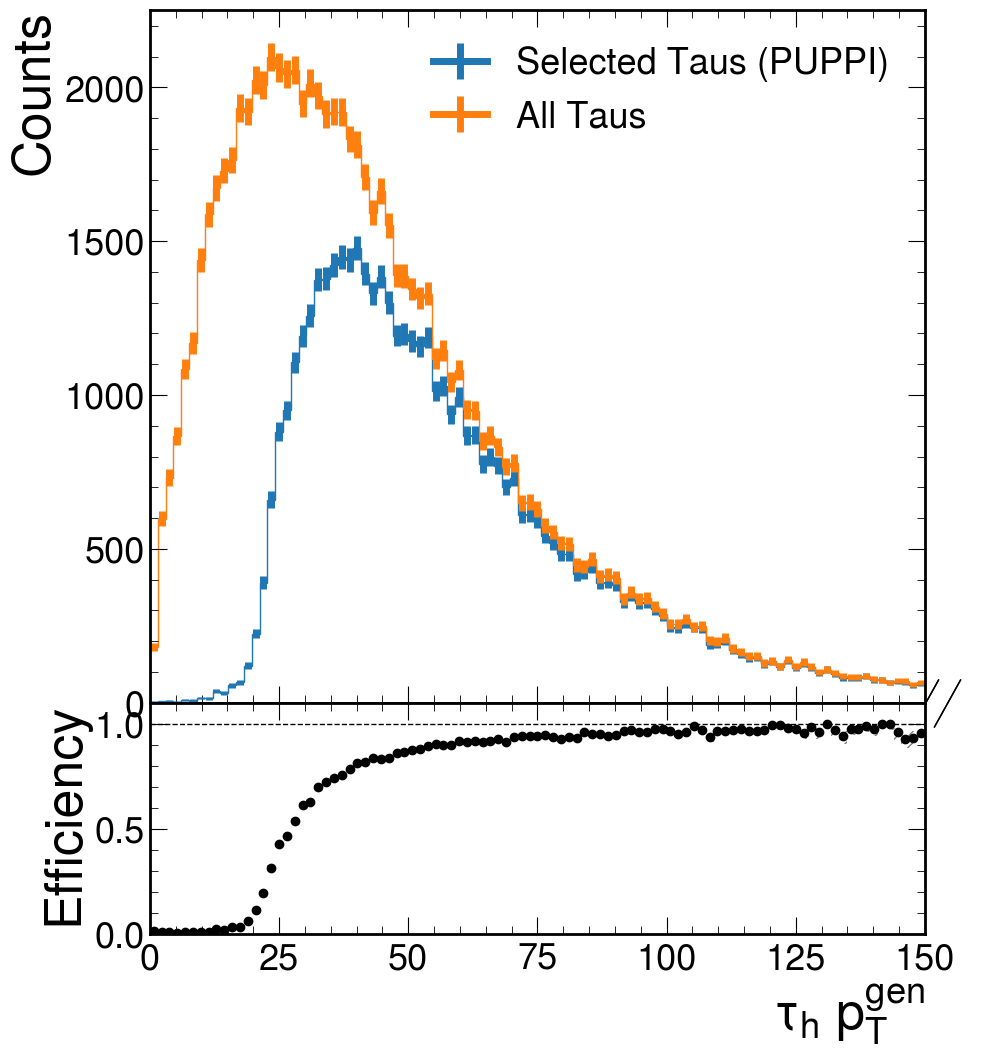

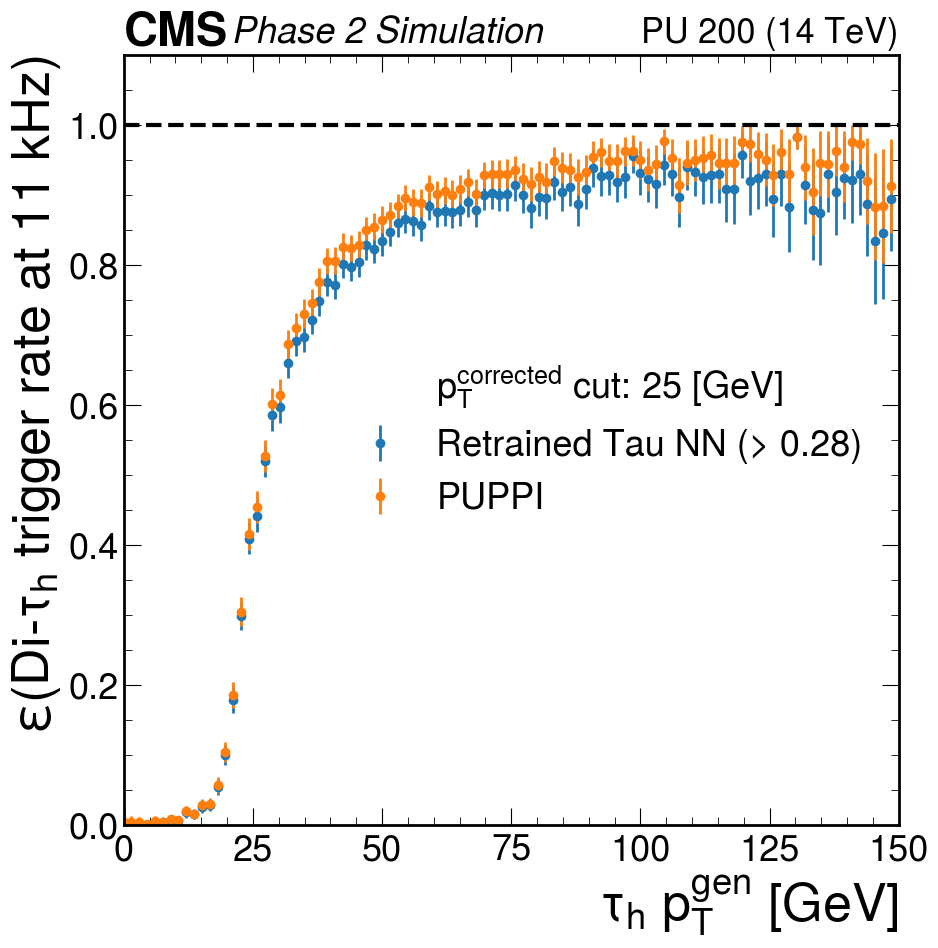

1432/1432 [==============================] - 1s 939us/step


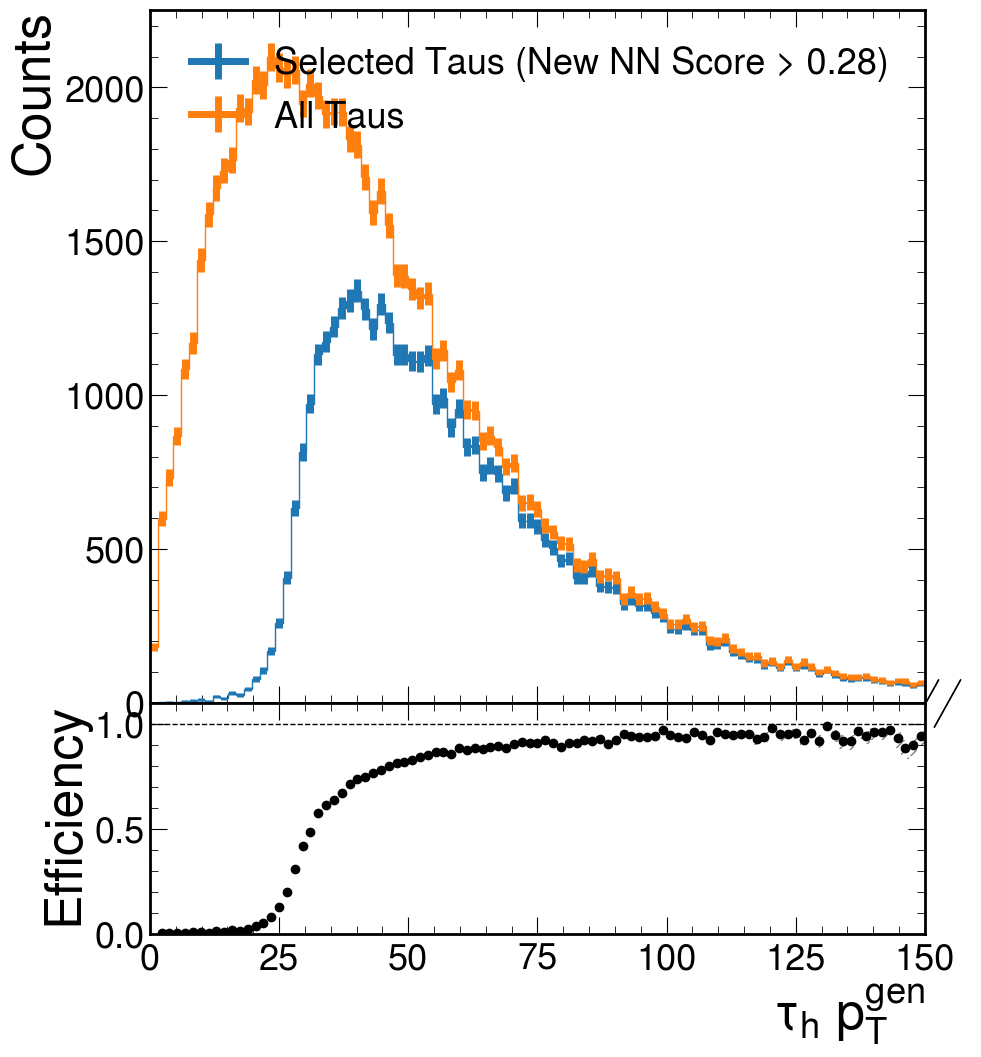

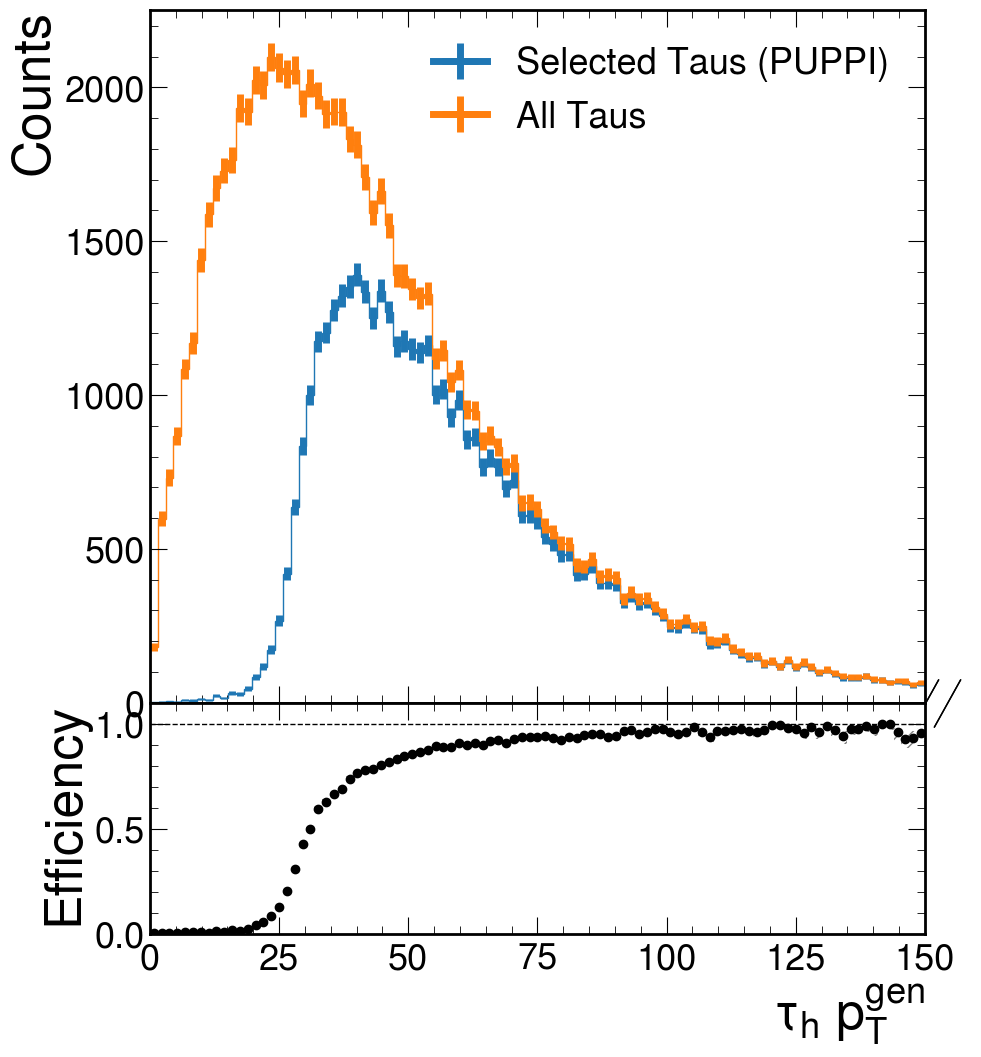

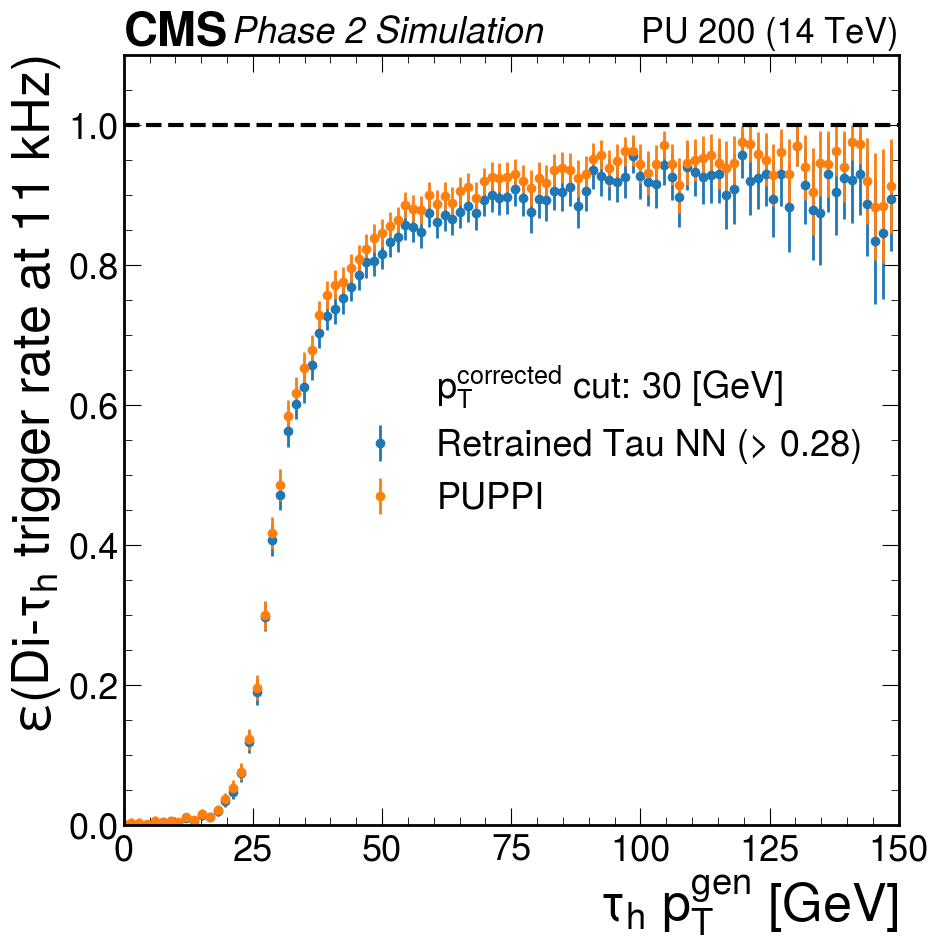

1279/1279 [==============================] - 1s 1ms/step


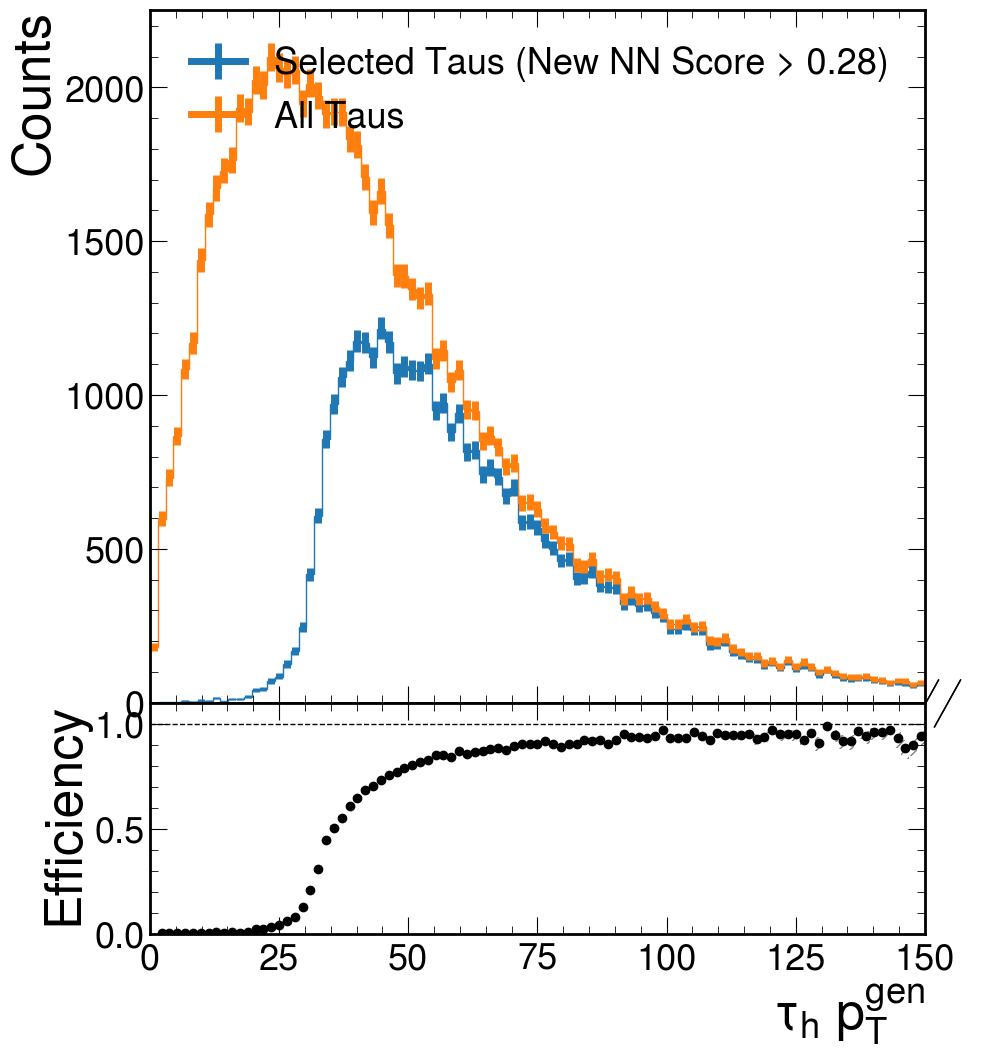

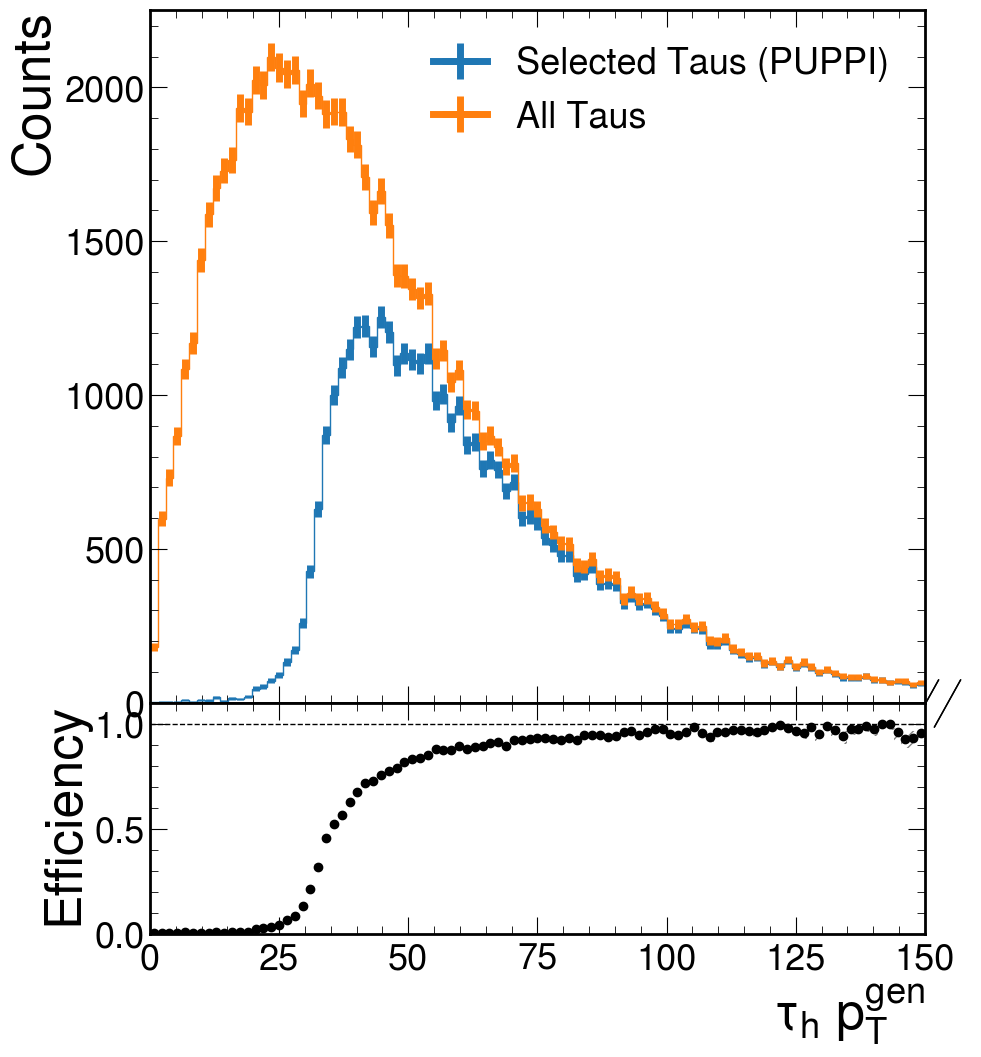

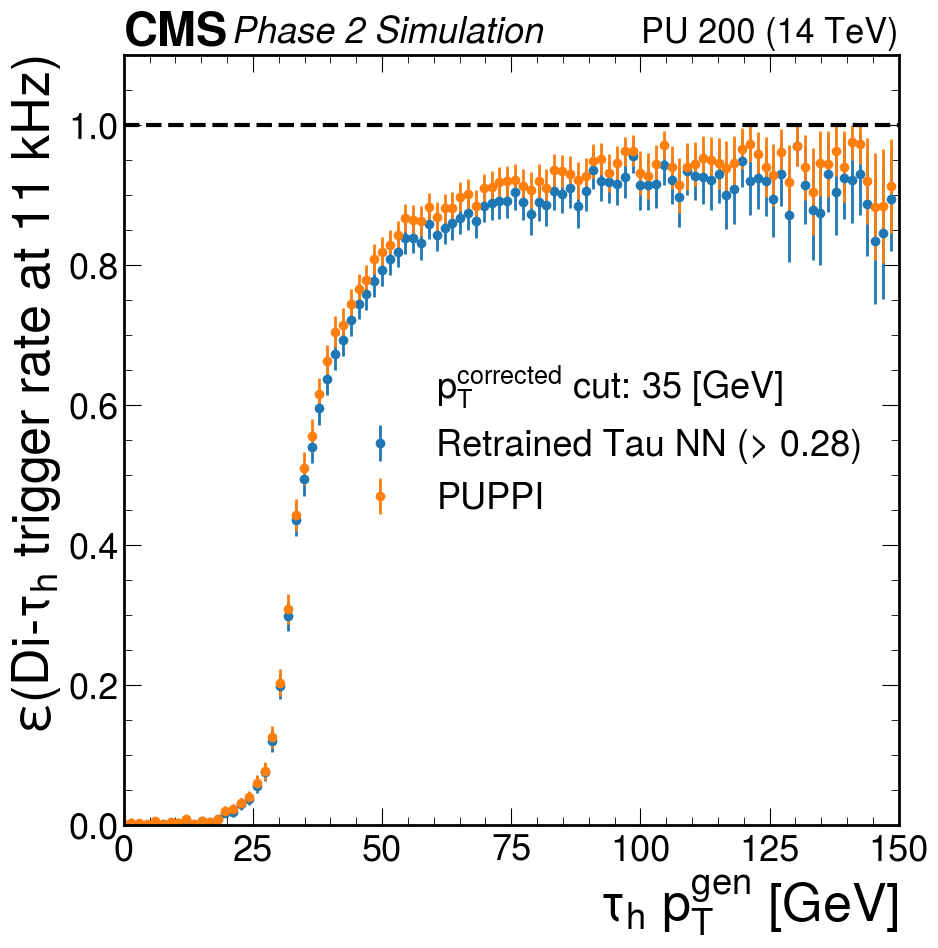

1124/1124 [==============================] - 1s 1ms/step


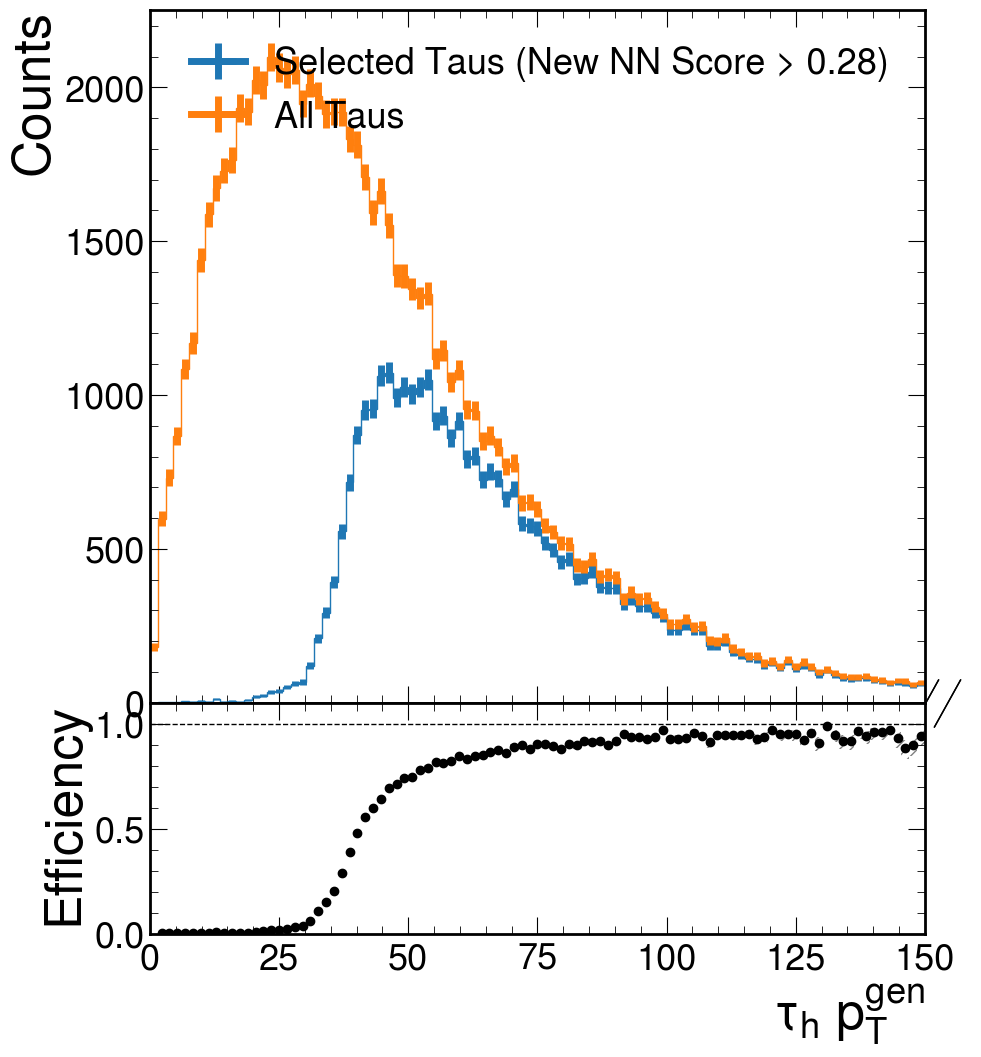

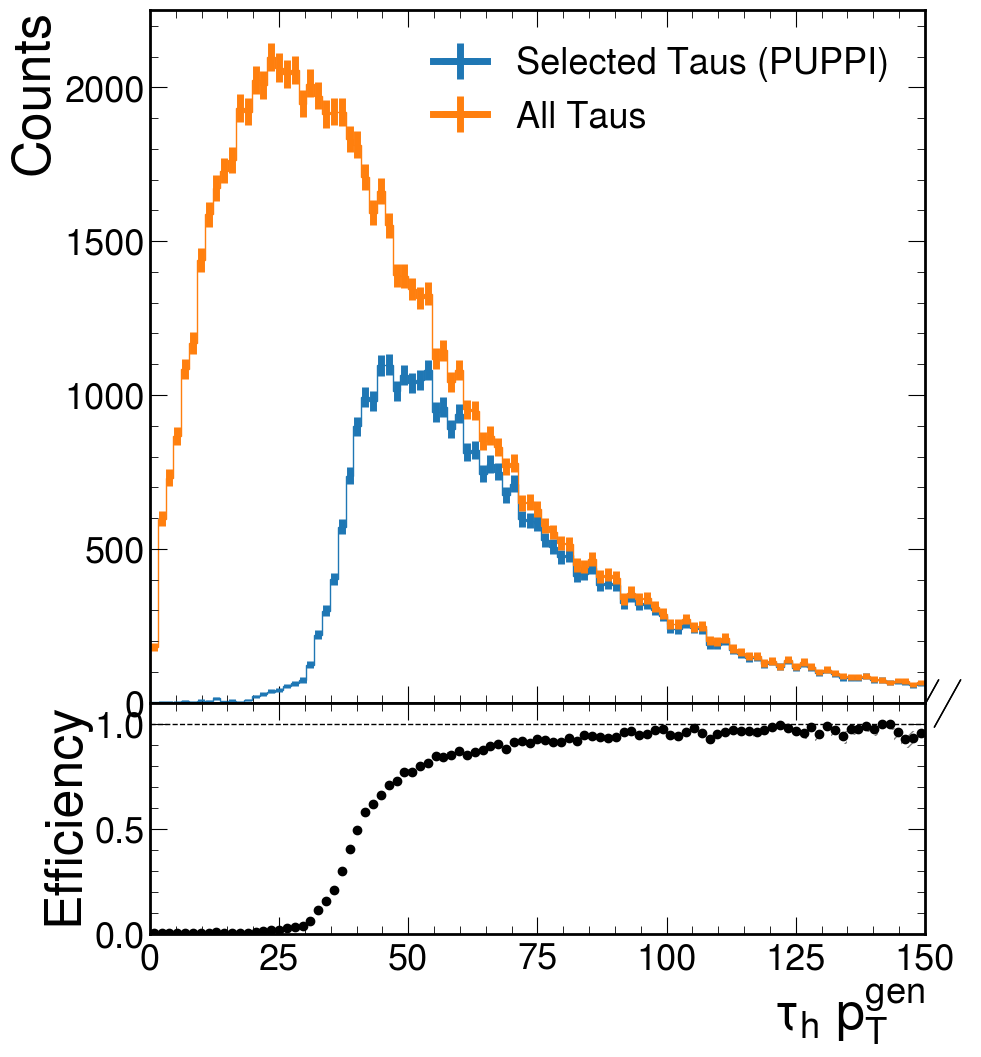

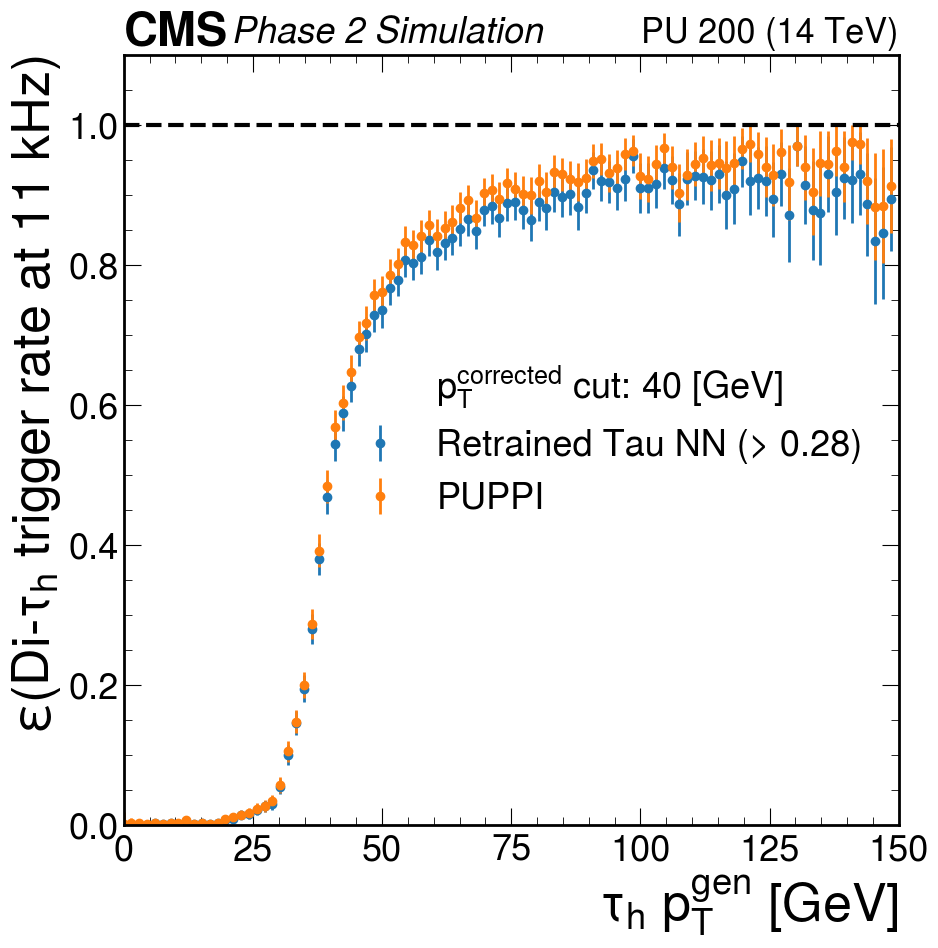

831/831 [==============================] - 1s 1ms/step


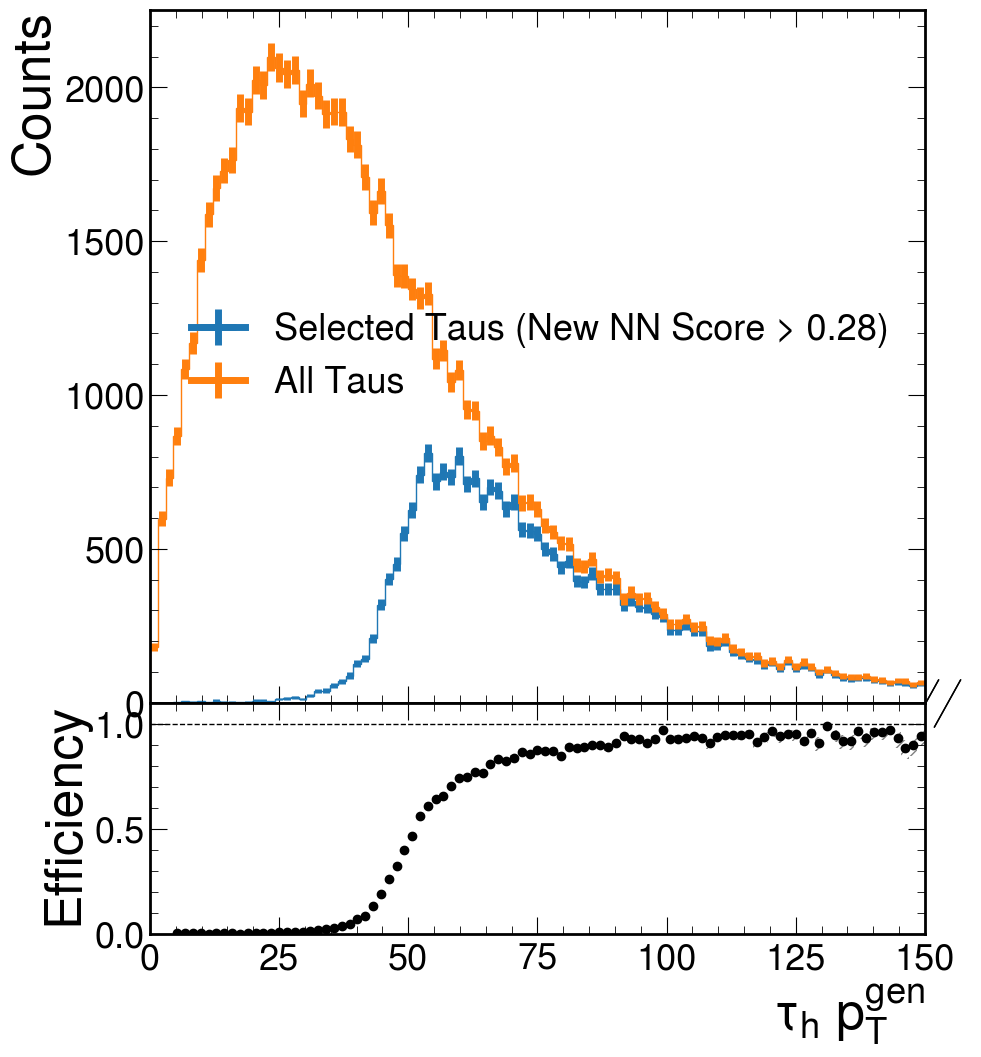

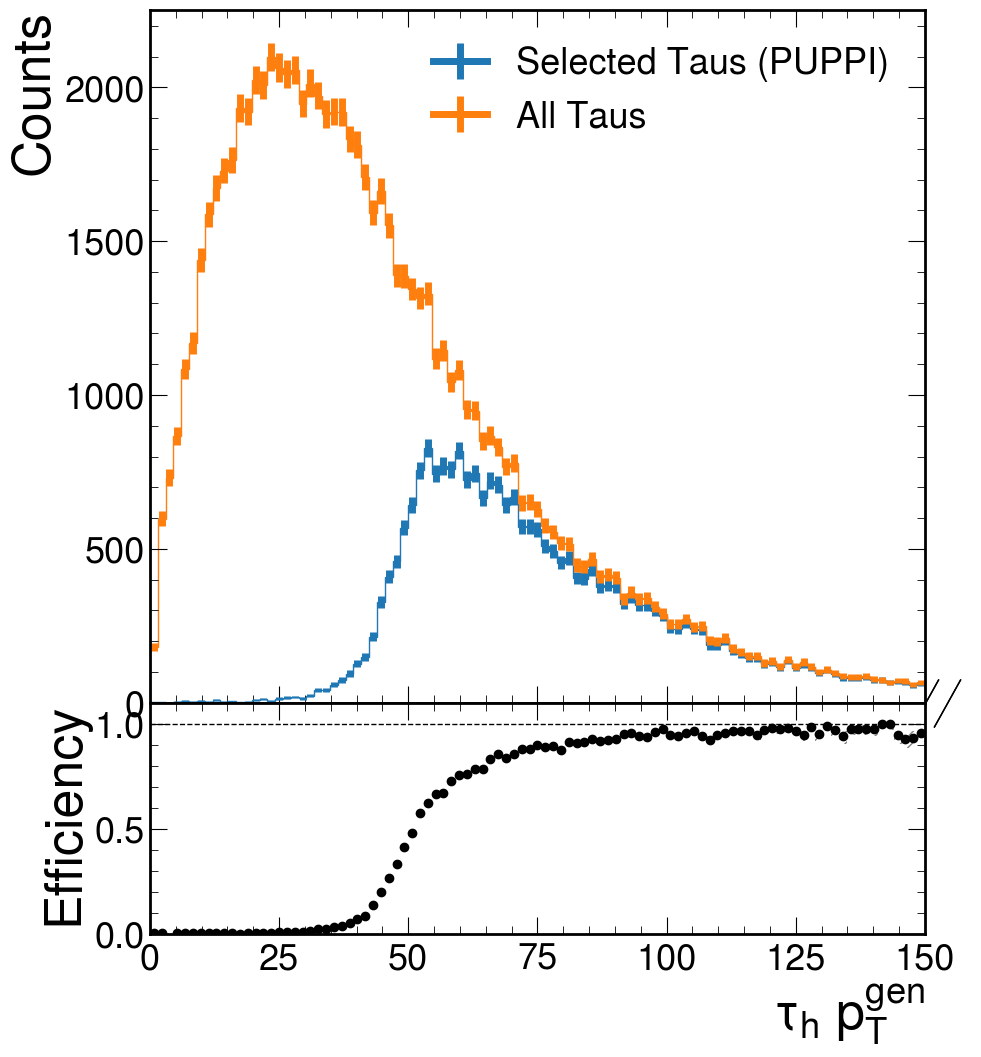

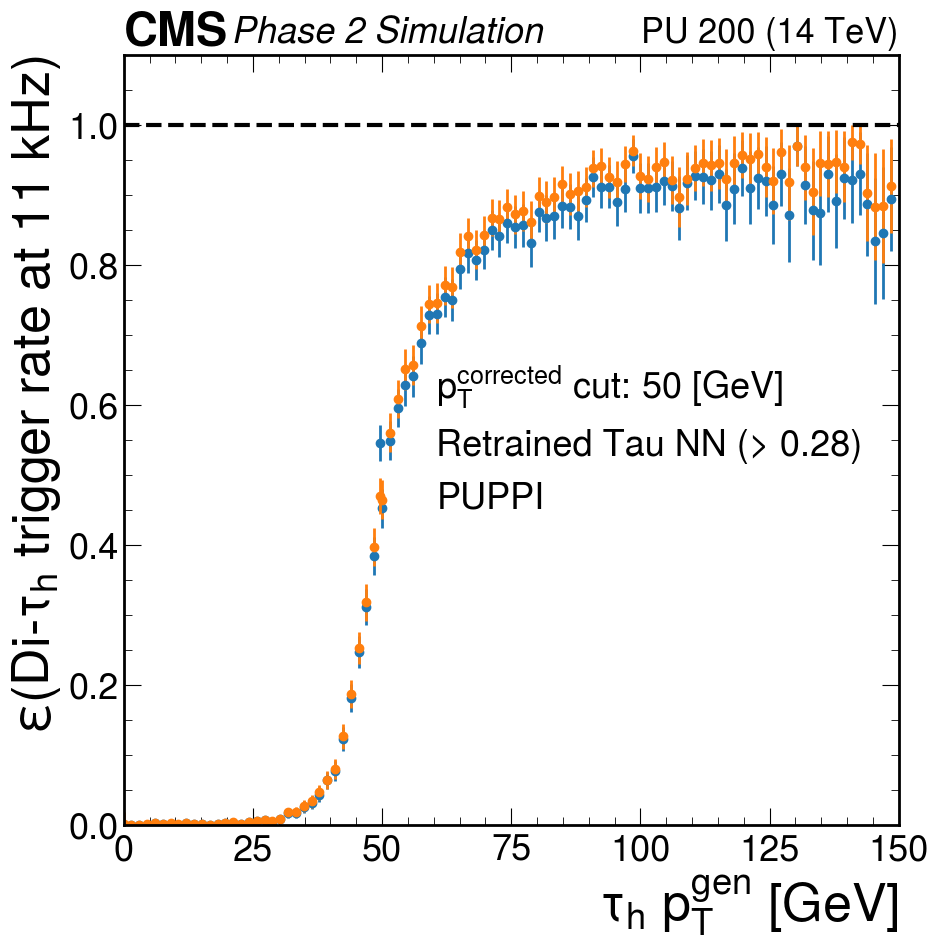

594/594 [==============================] - 1s 1ms/step


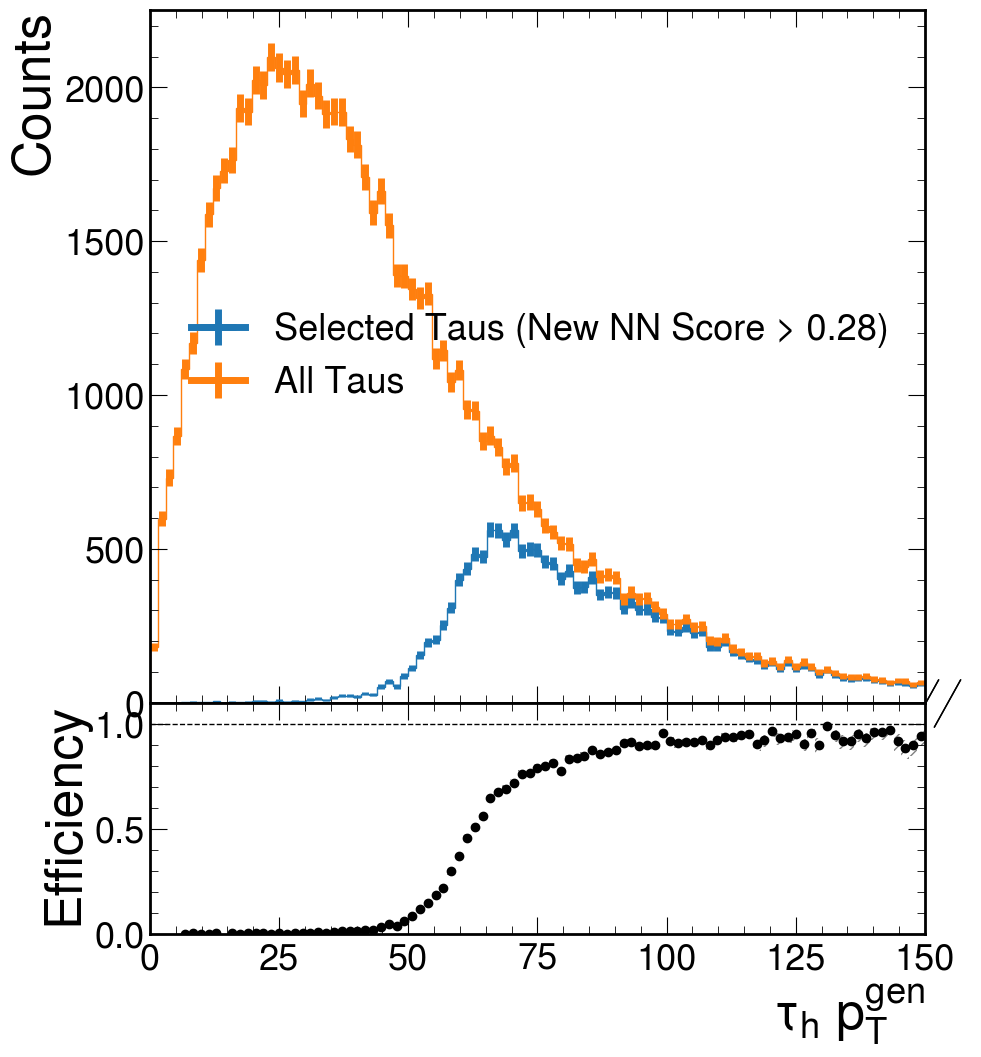

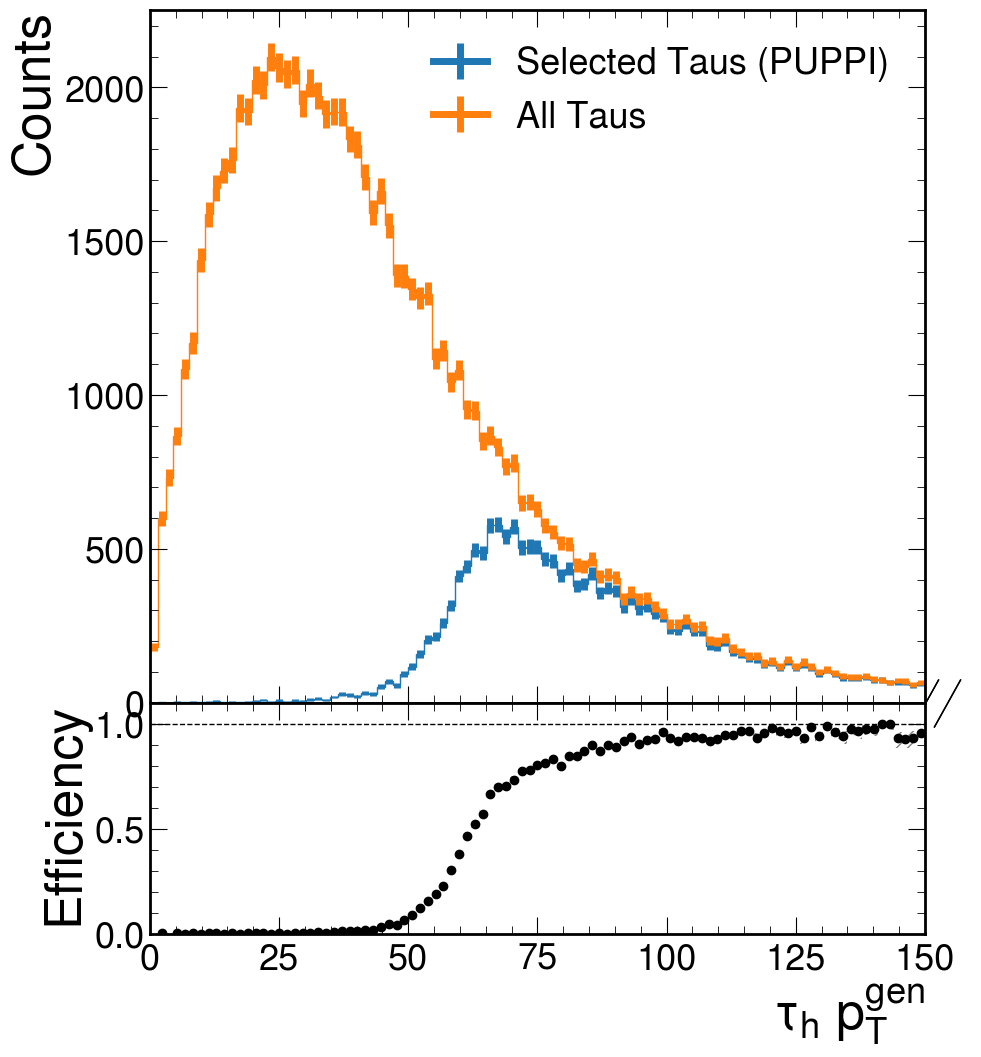

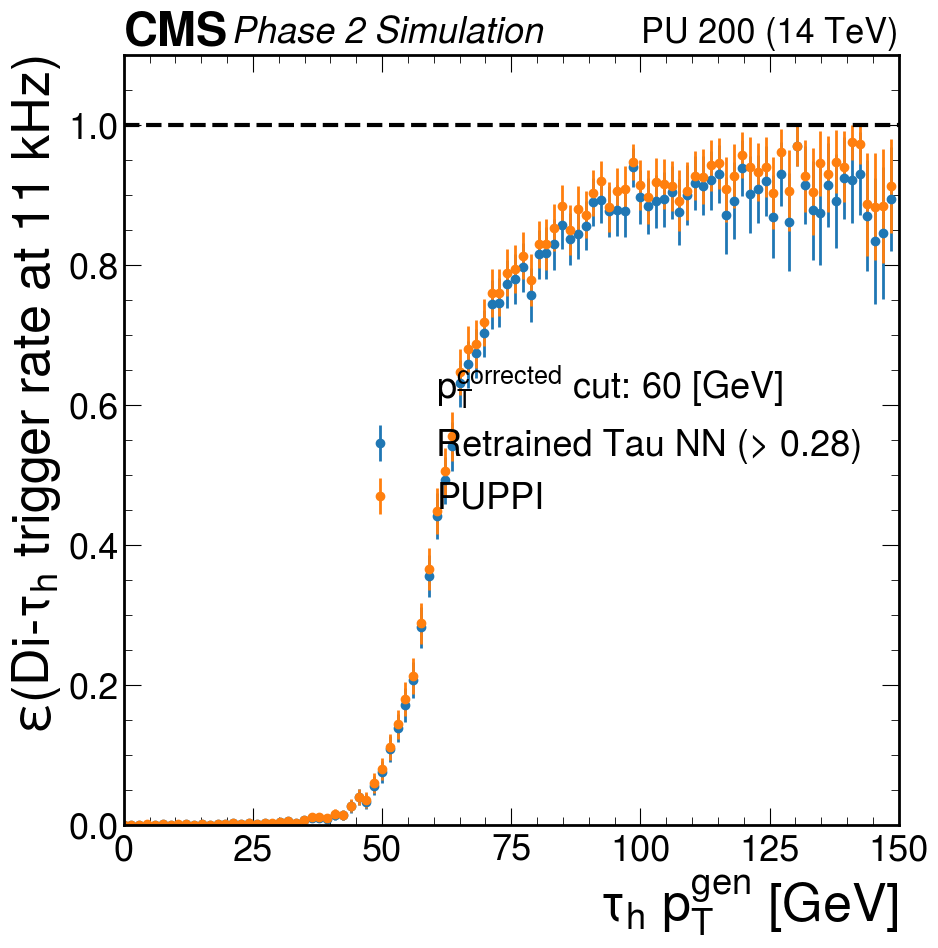

423/423 [==============================] - 1s 1ms/step


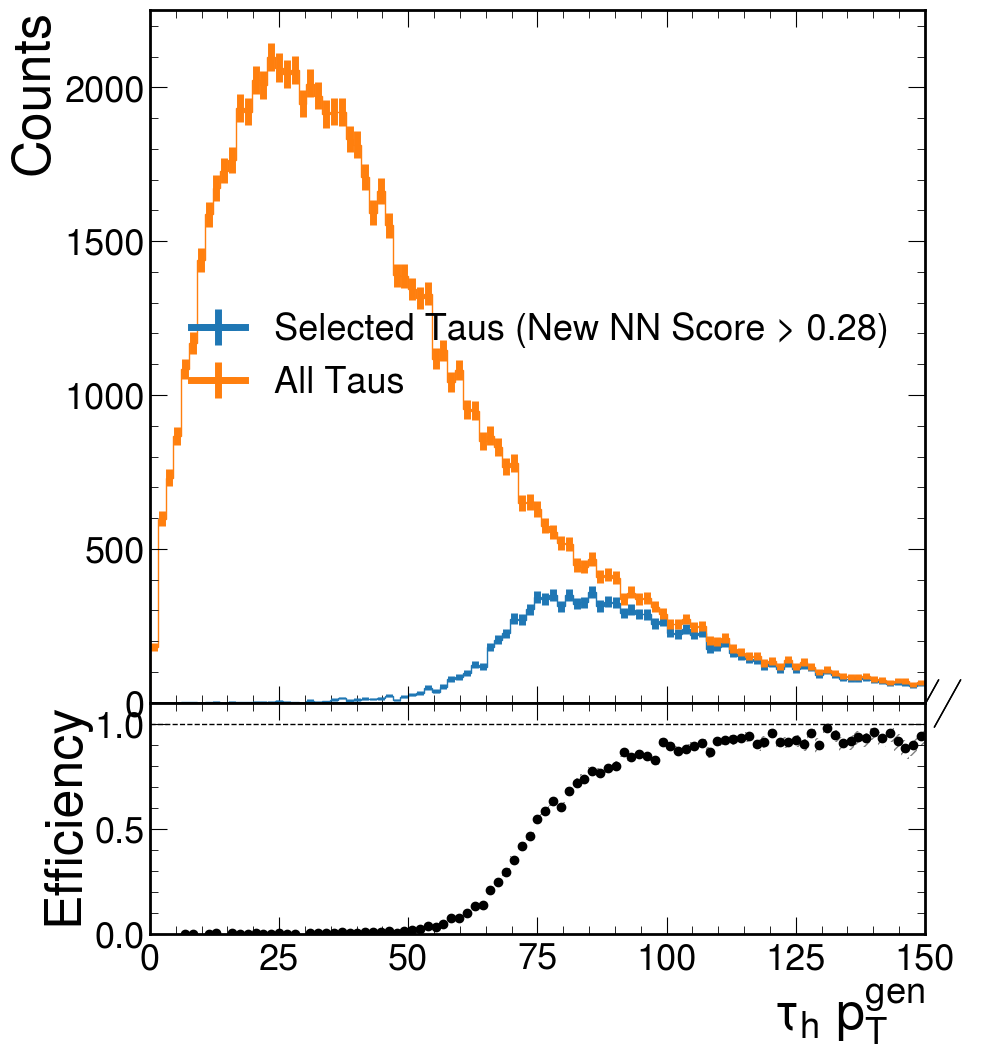

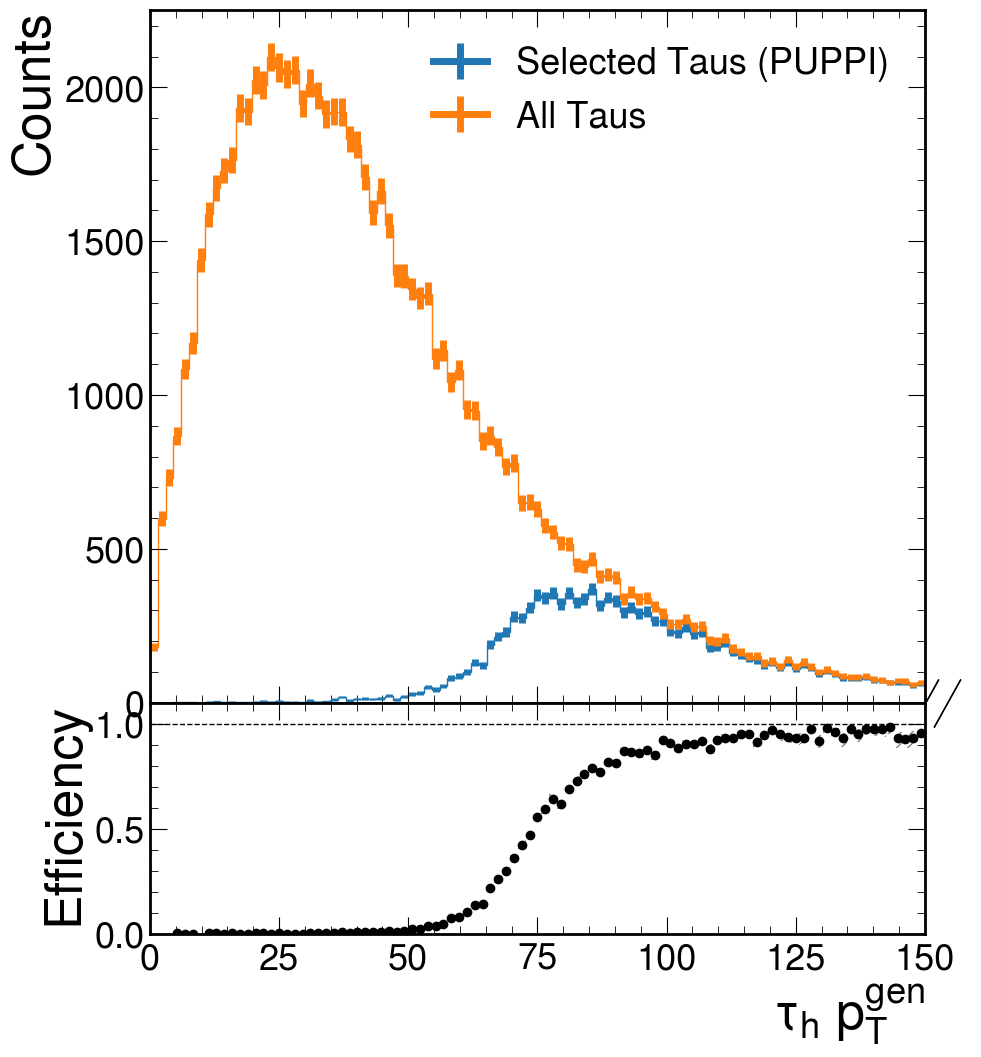

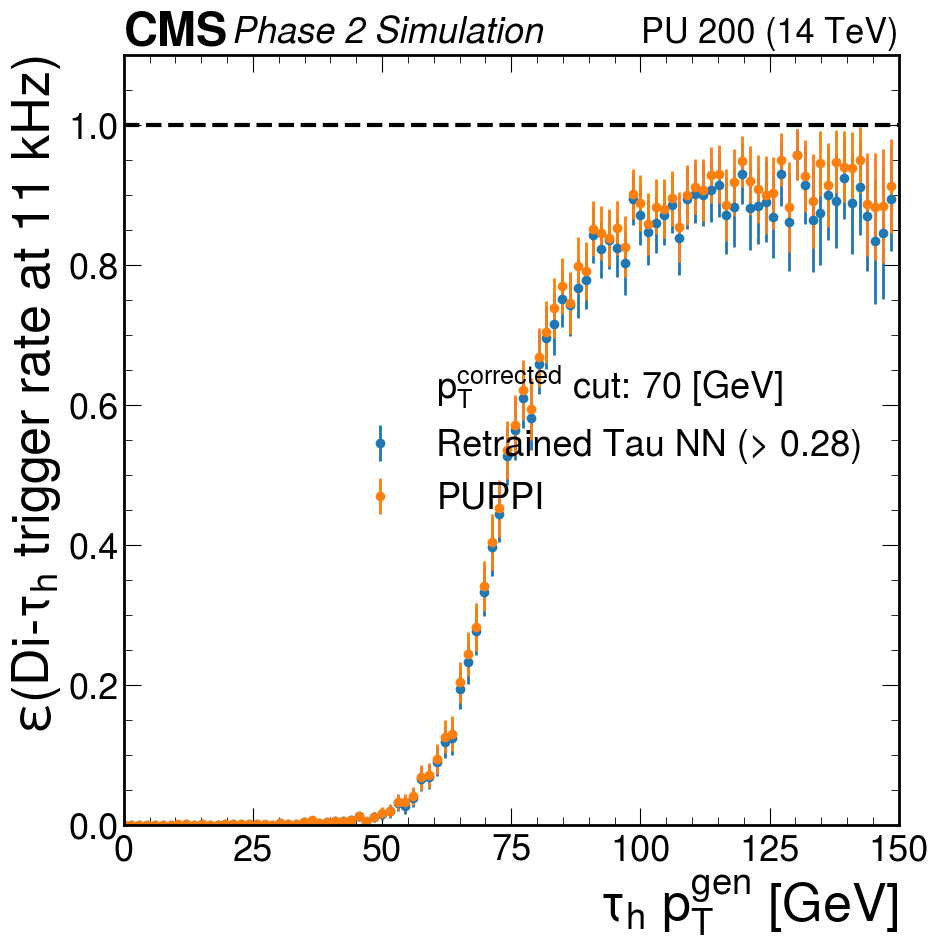

306/306 [==============================] - 0s 1ms/step


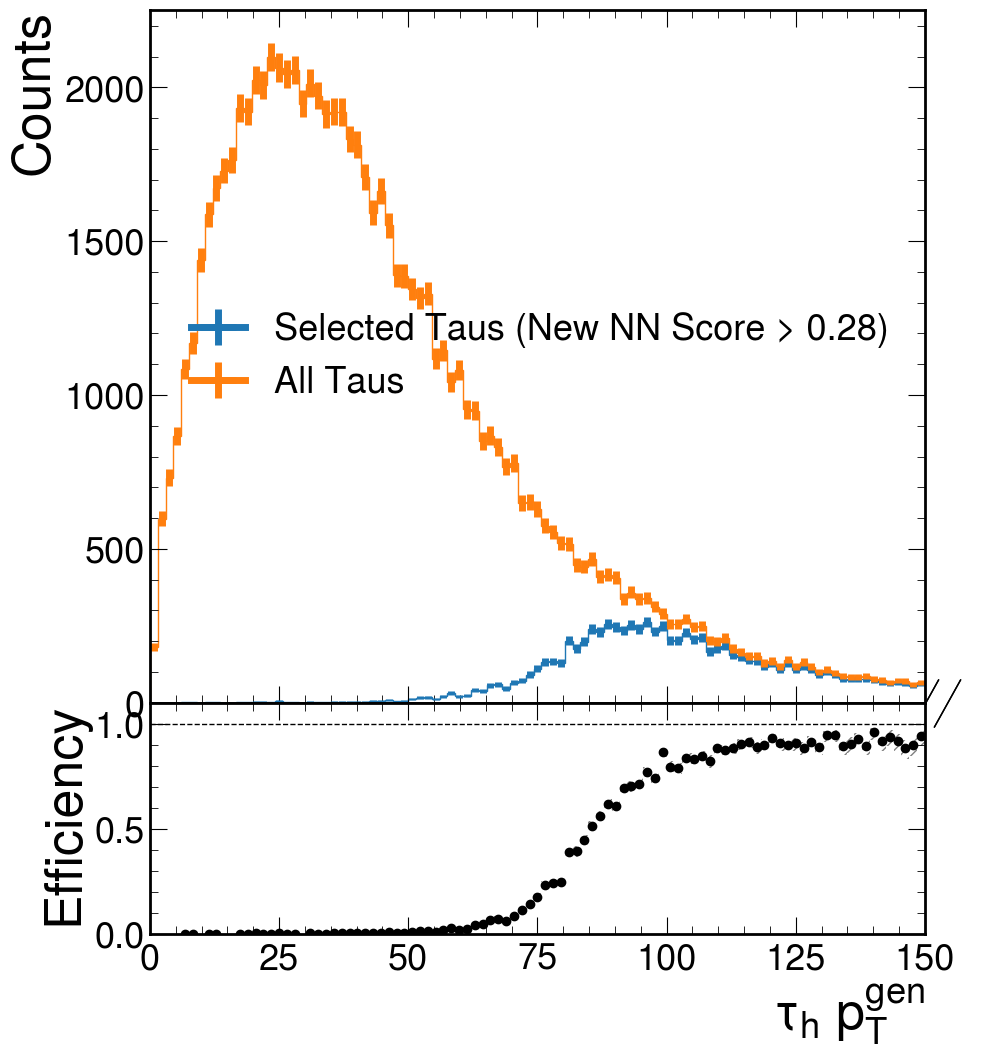

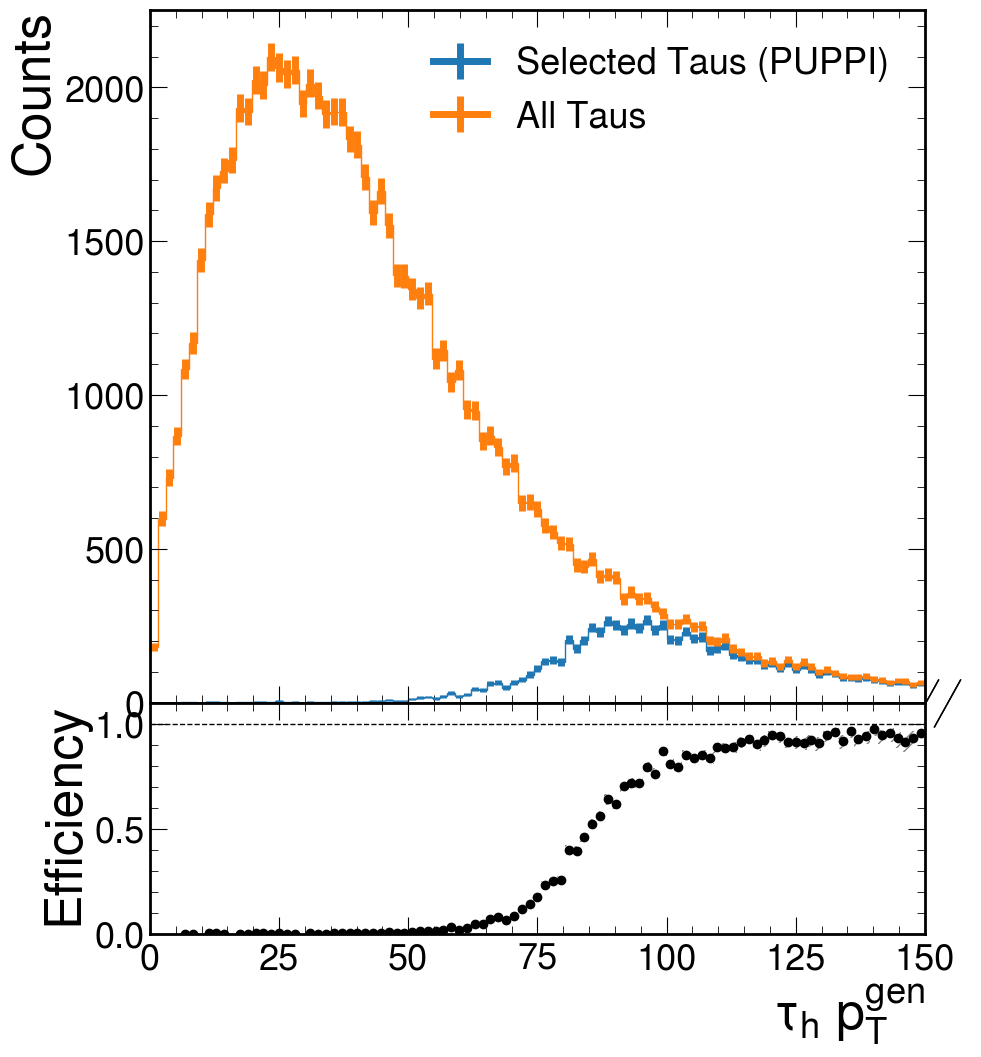

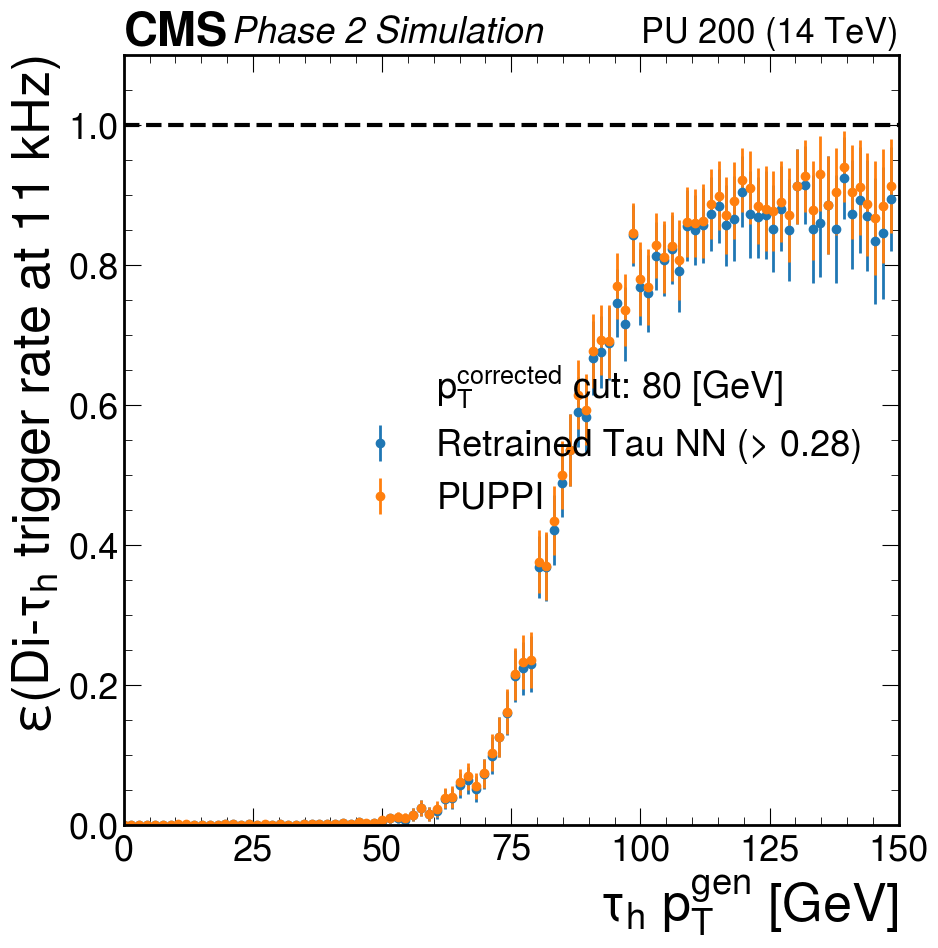

1905/1905 [==============================] - 2s 937us/step


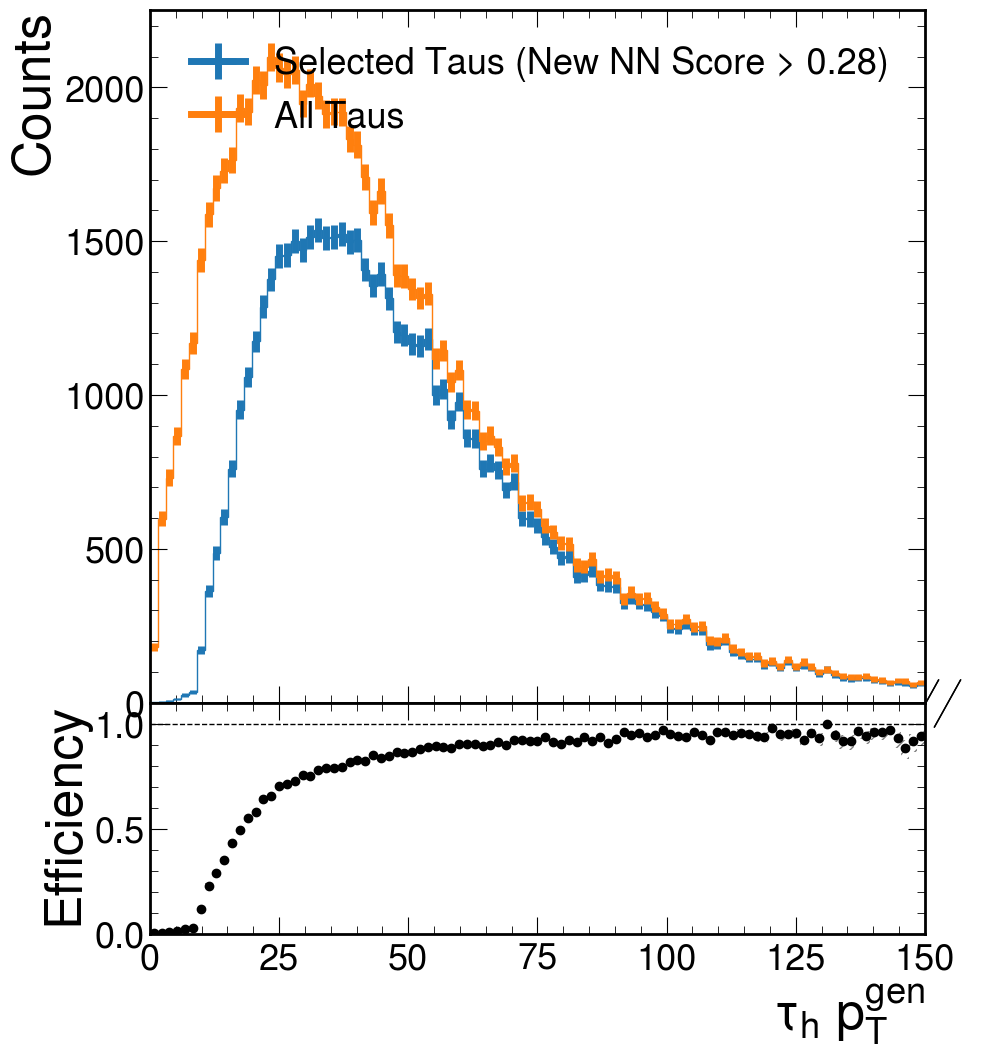

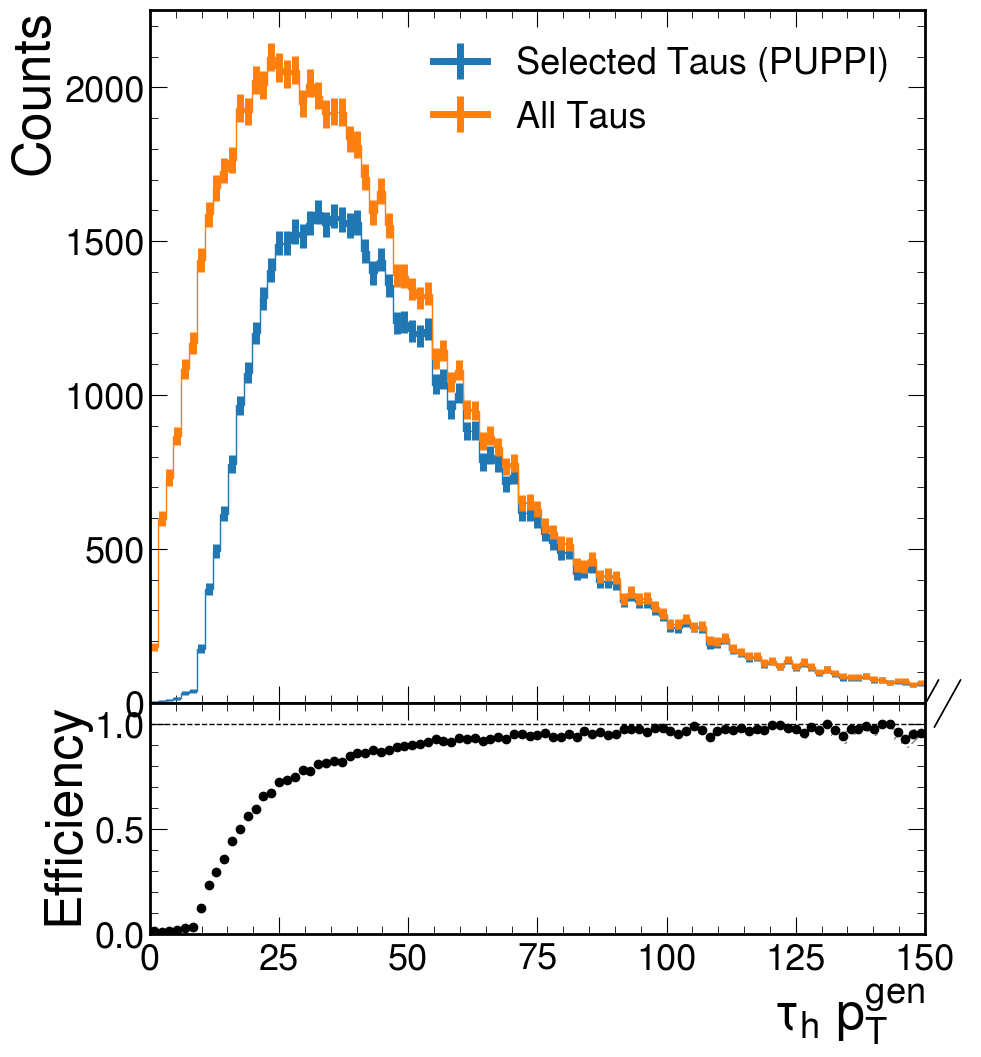

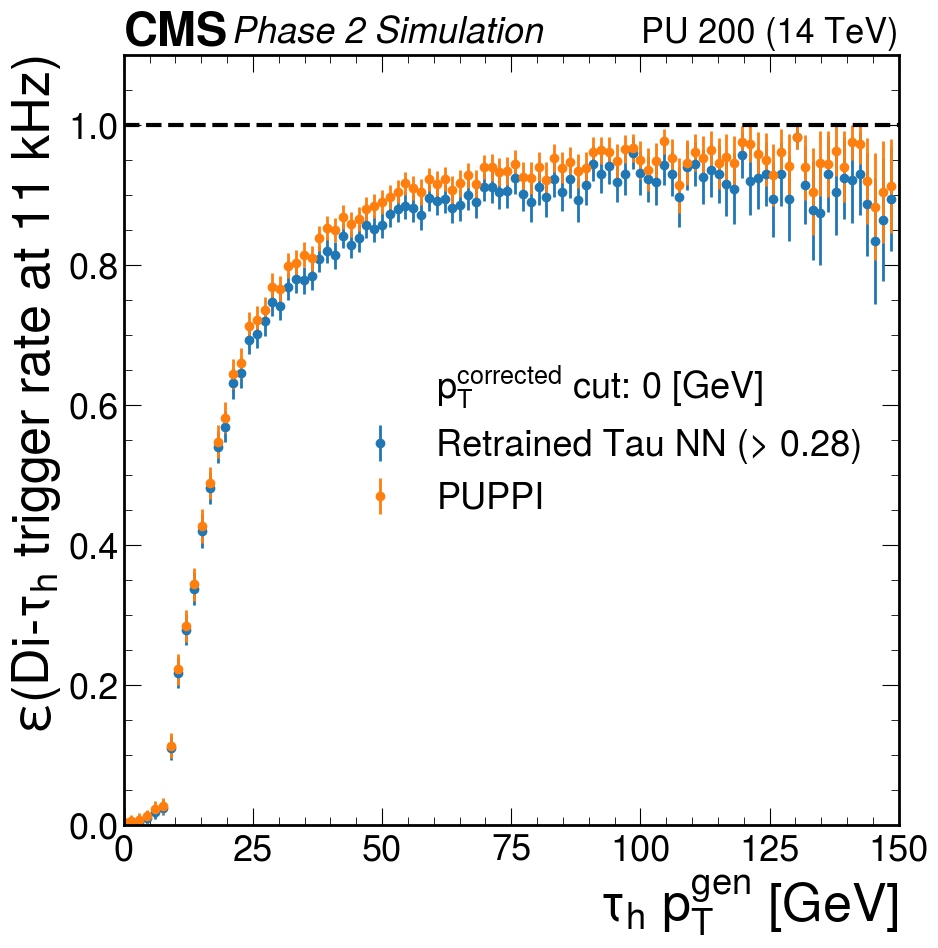

1743/1743 [==============================] - 2s 1ms/step


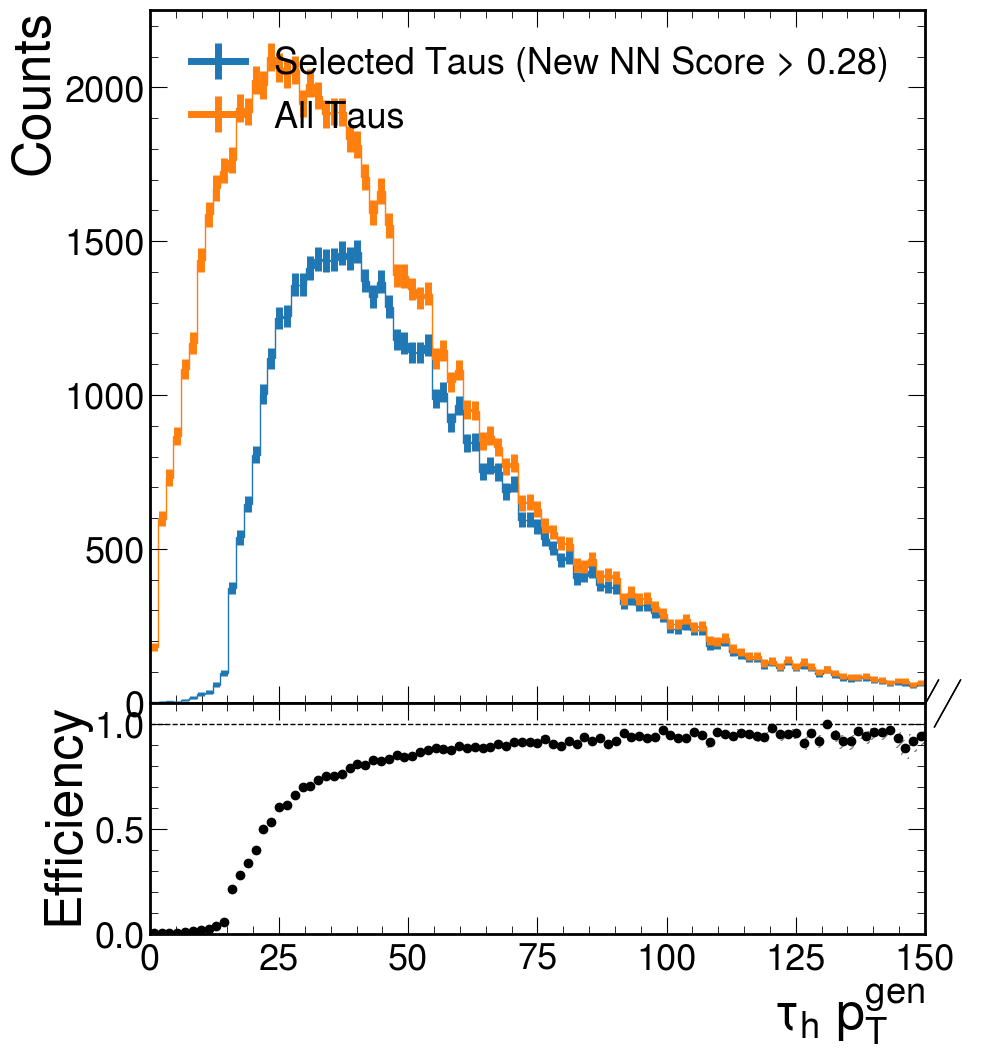

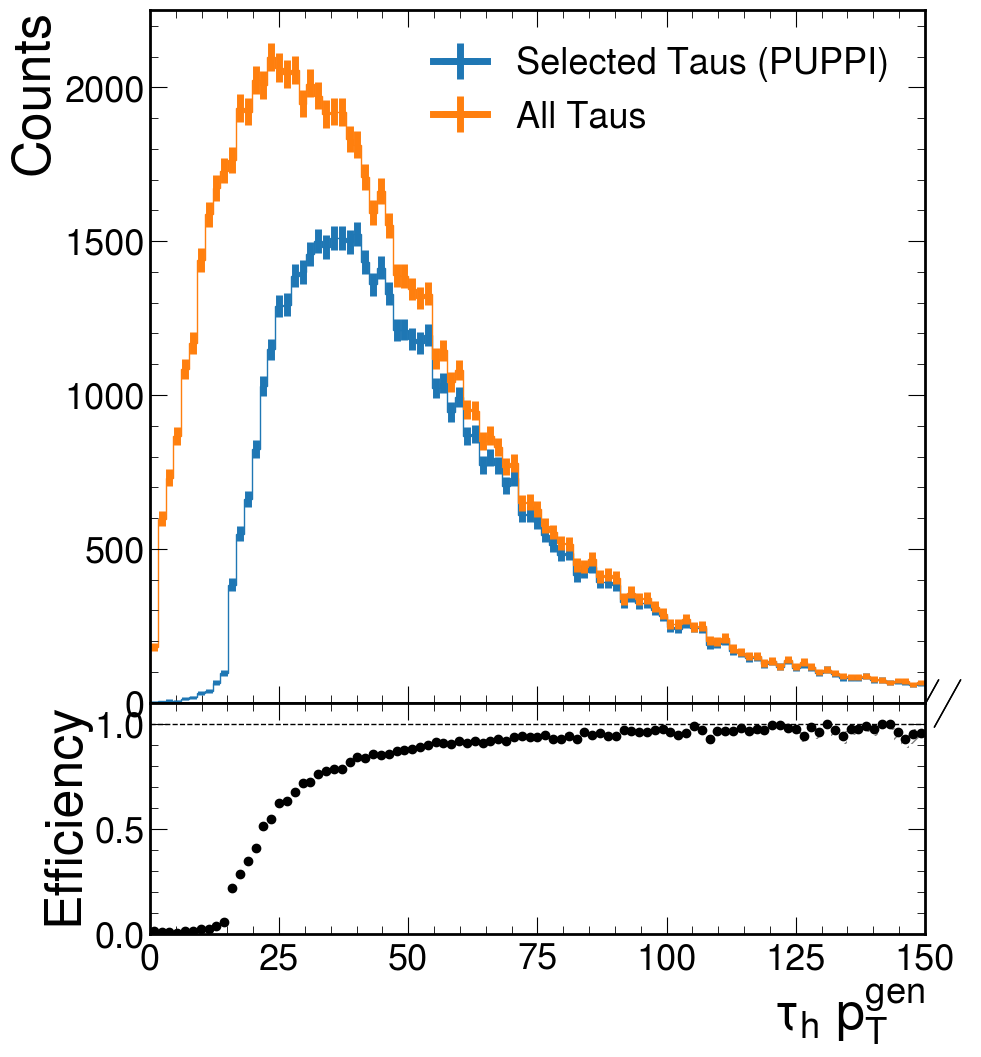

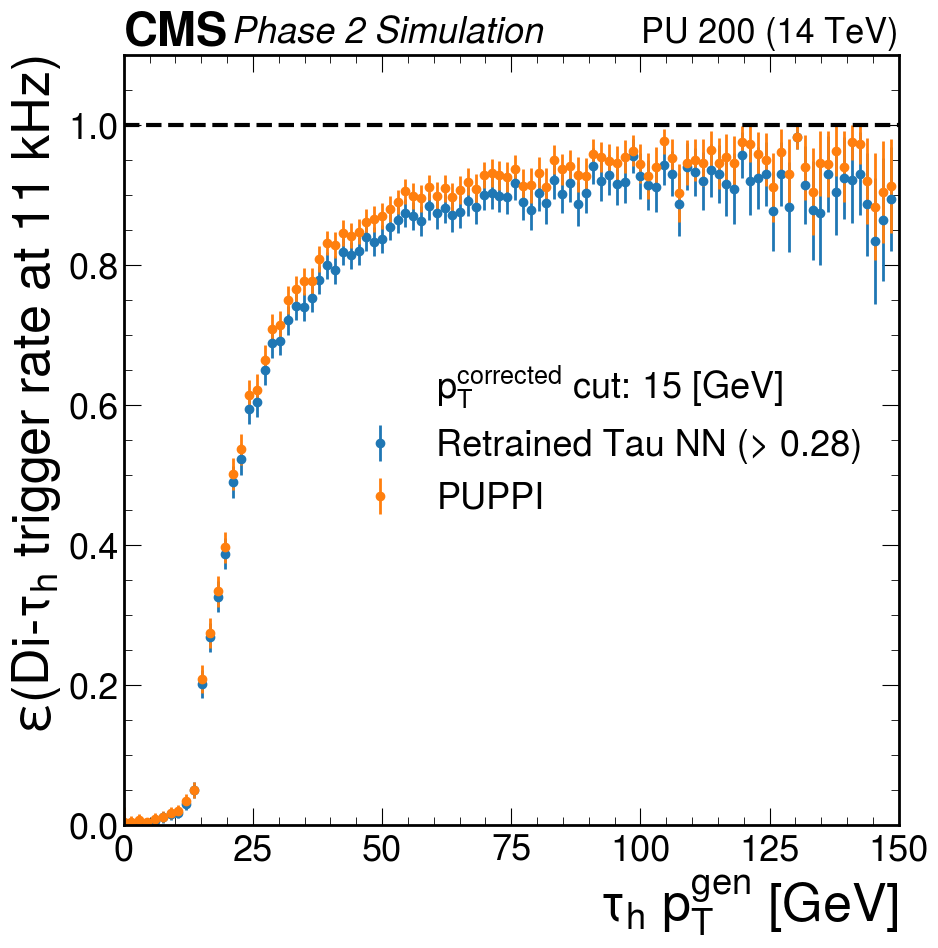

1585/1585 [==============================] - 2s 989us/step


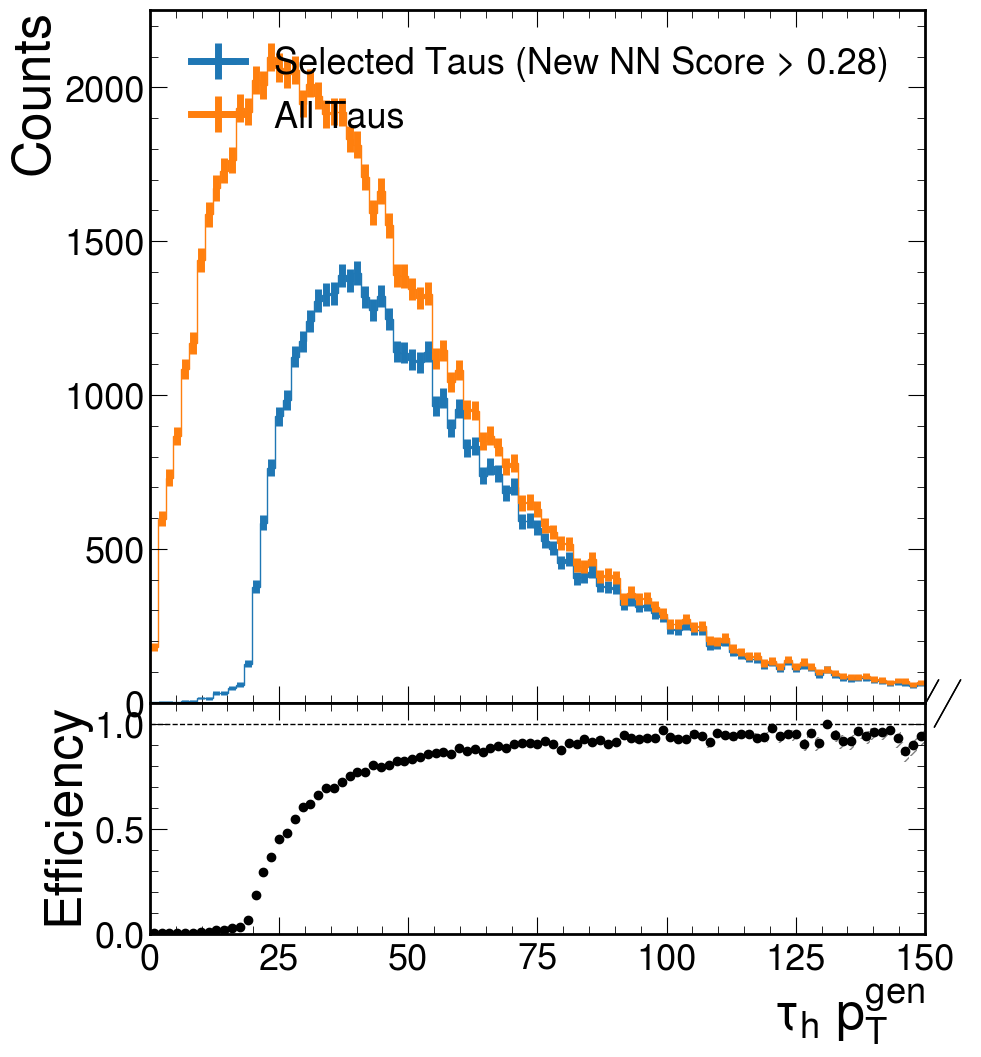

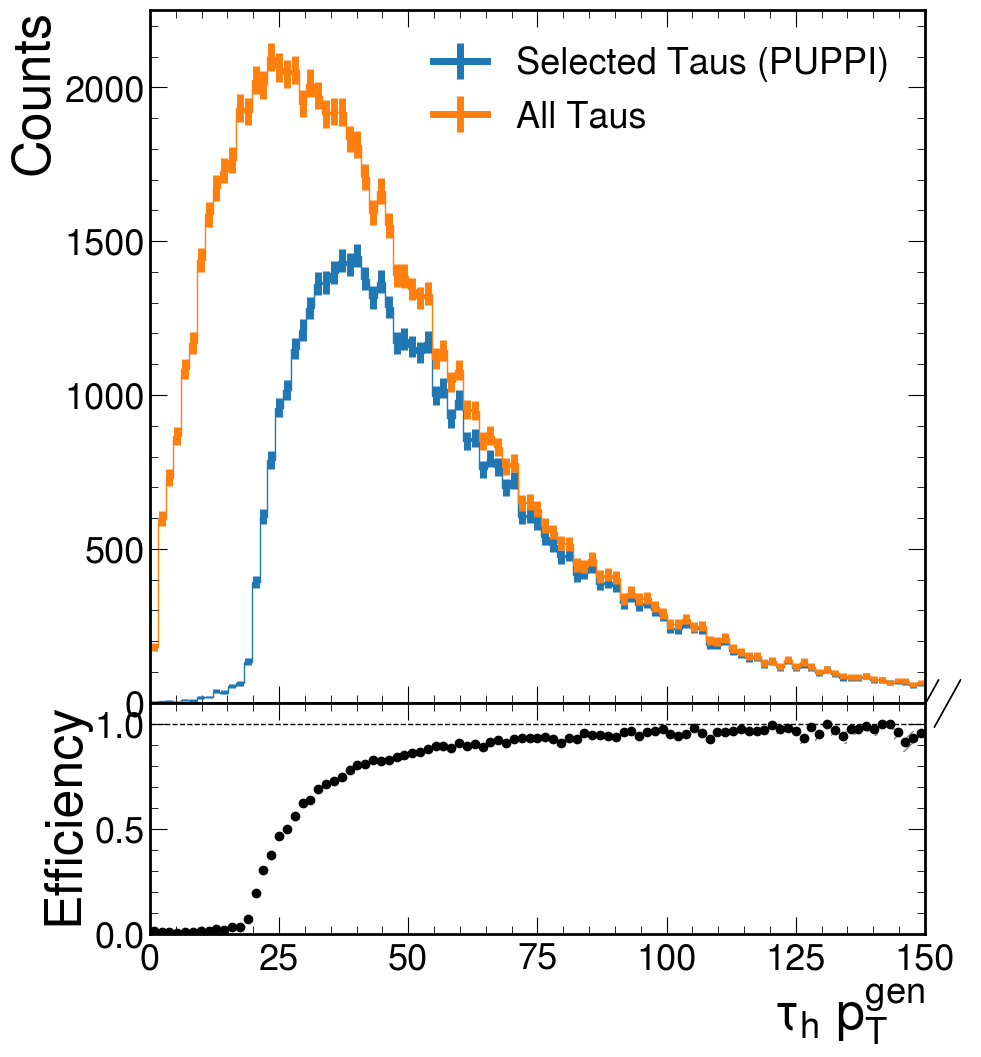

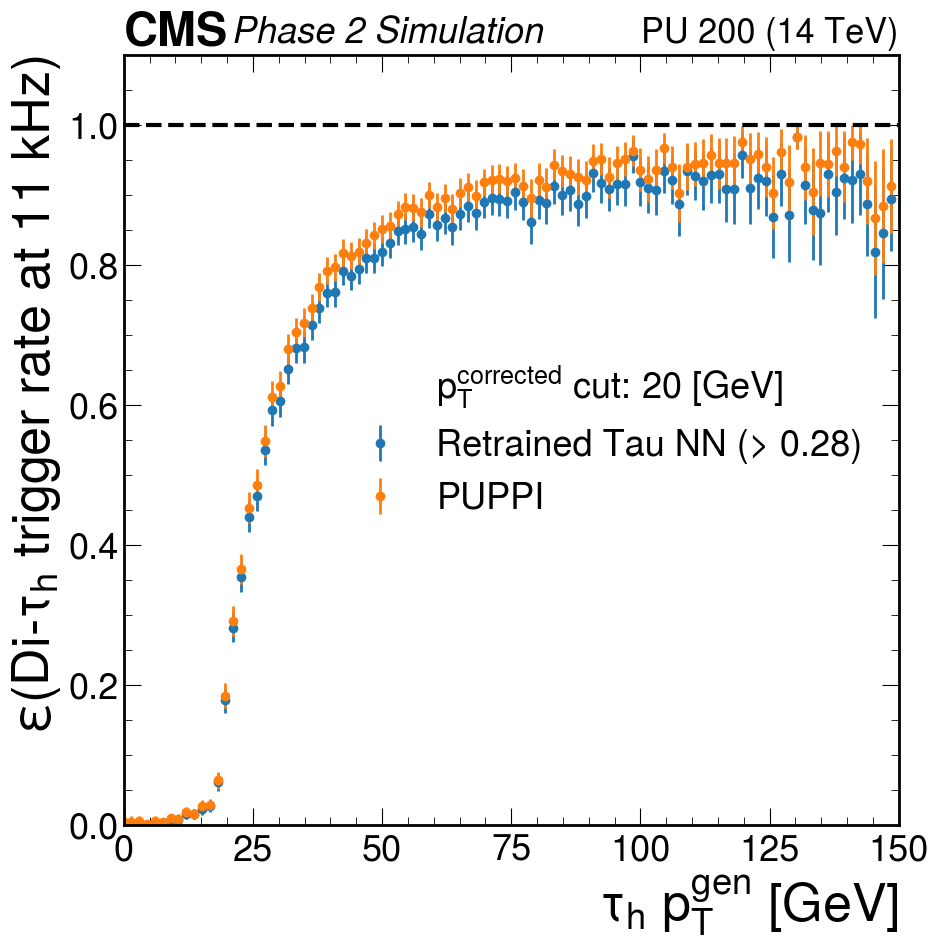

1421/1421 [==============================] - 2s 1ms/step


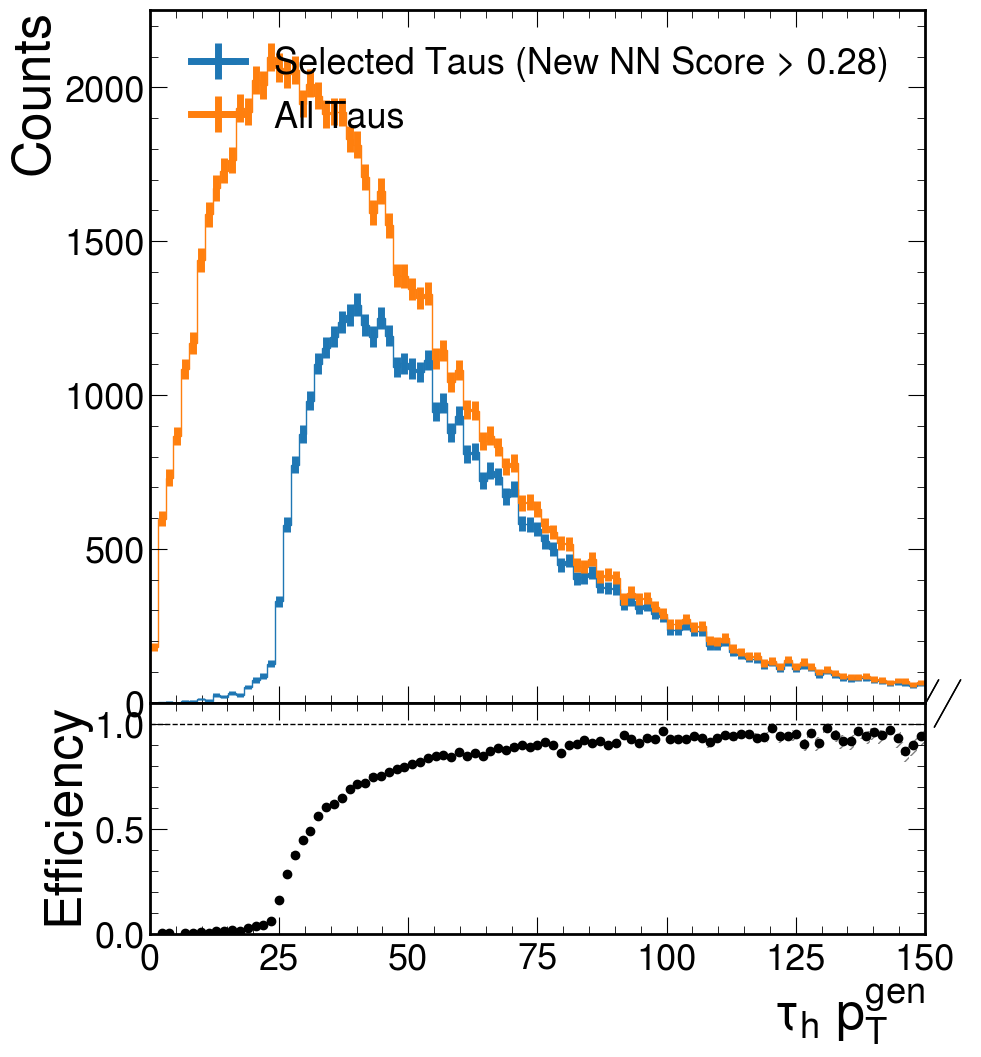

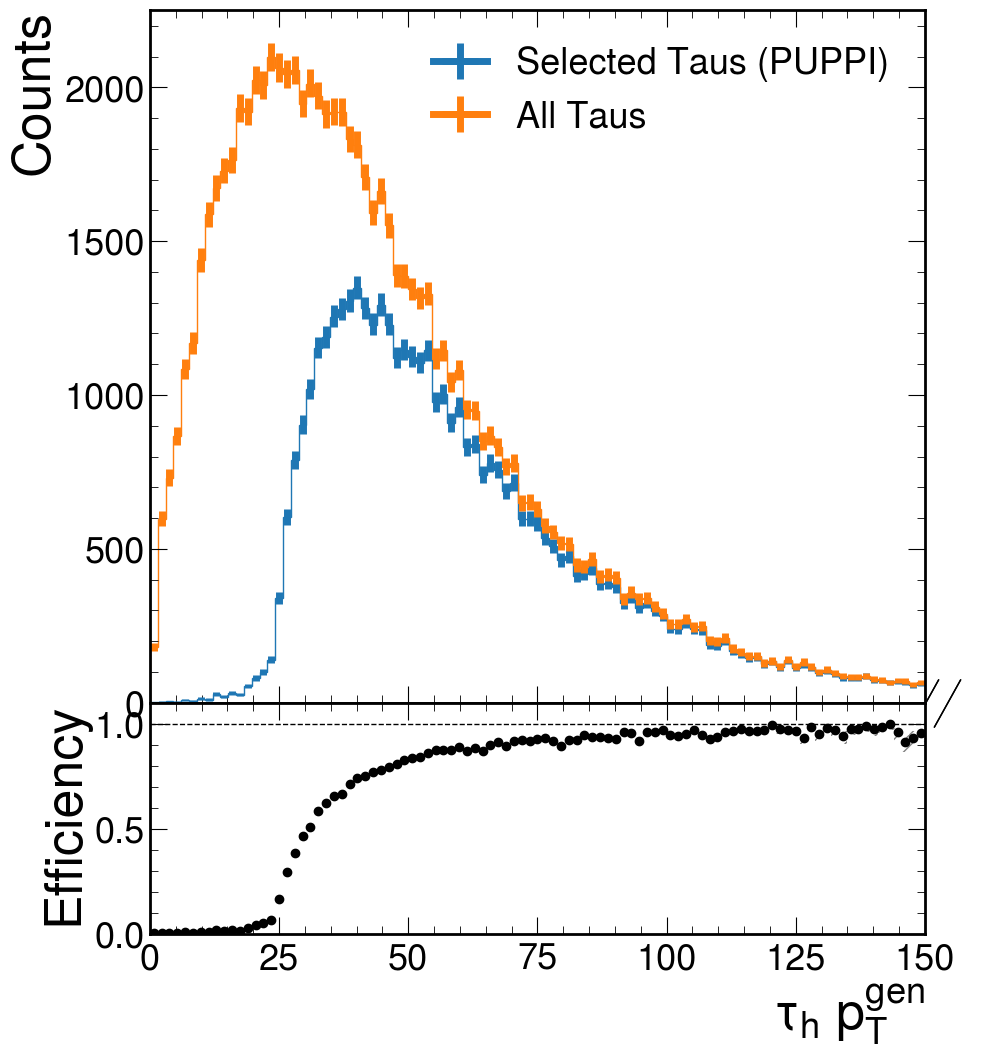

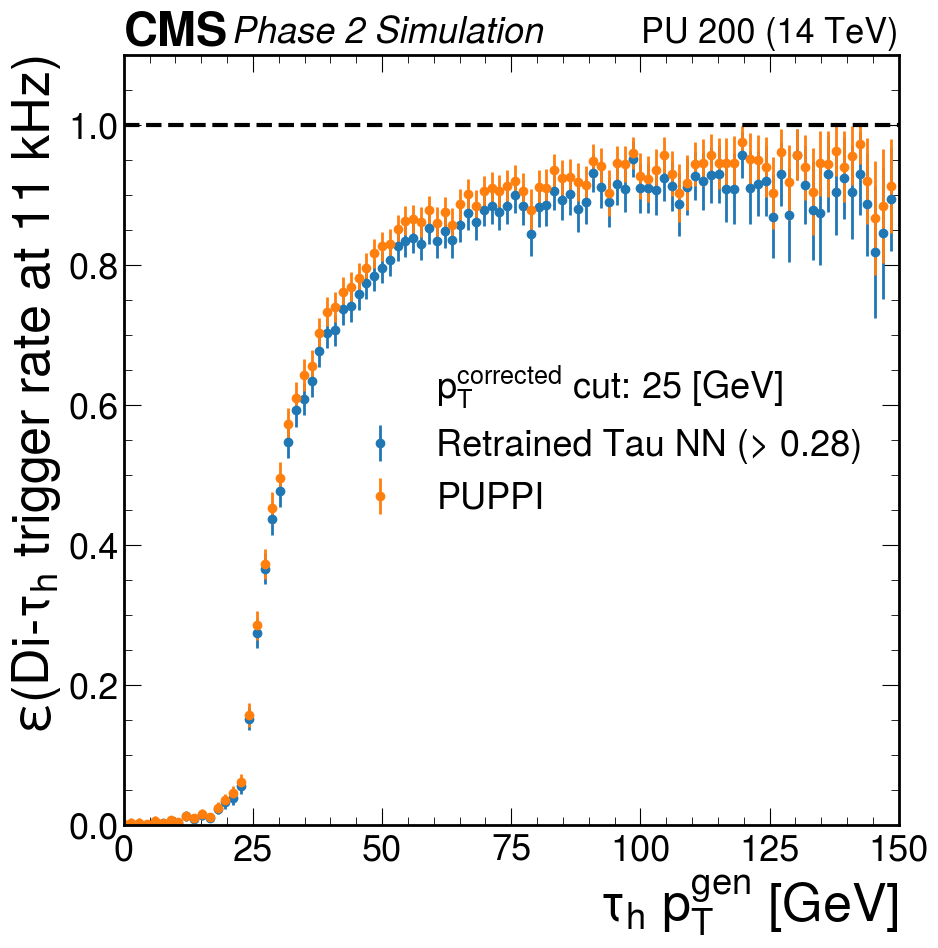

1258/1258 [==============================] - 1s 1ms/step


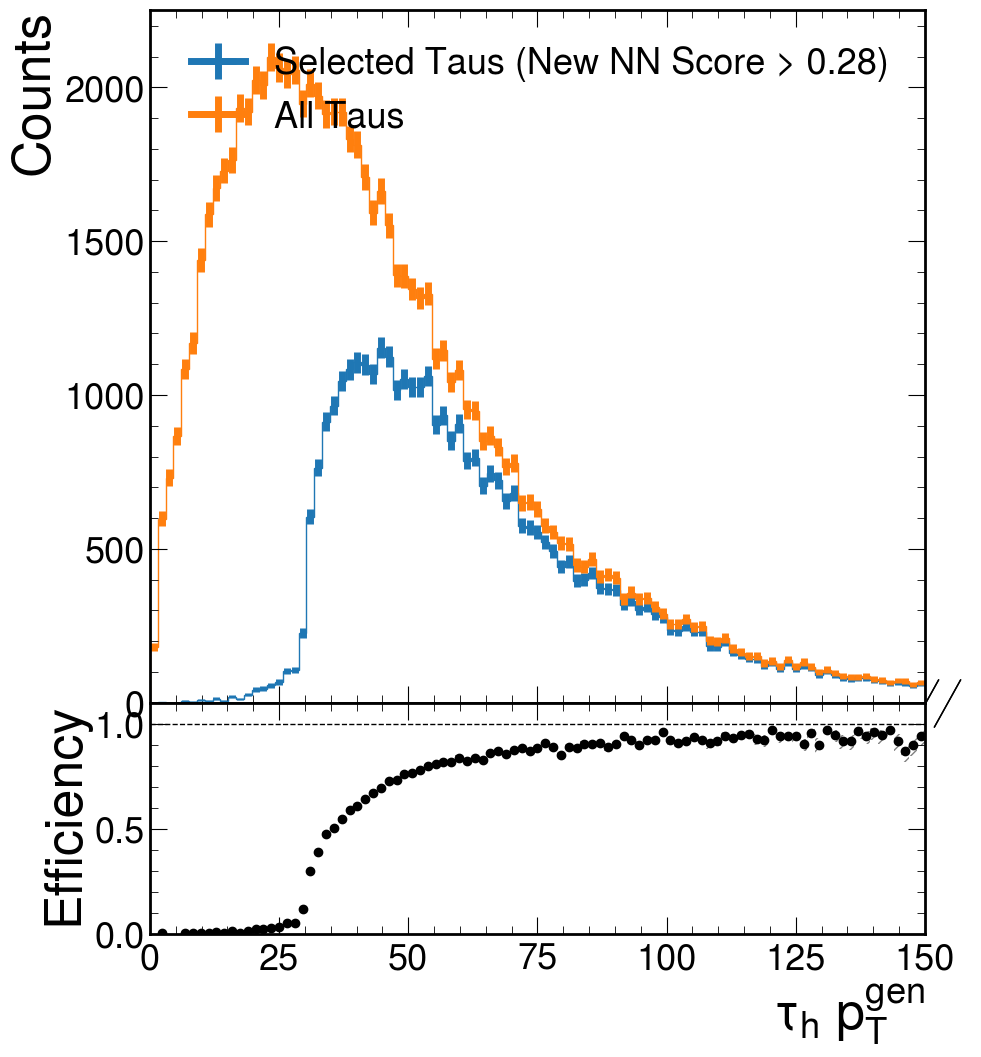

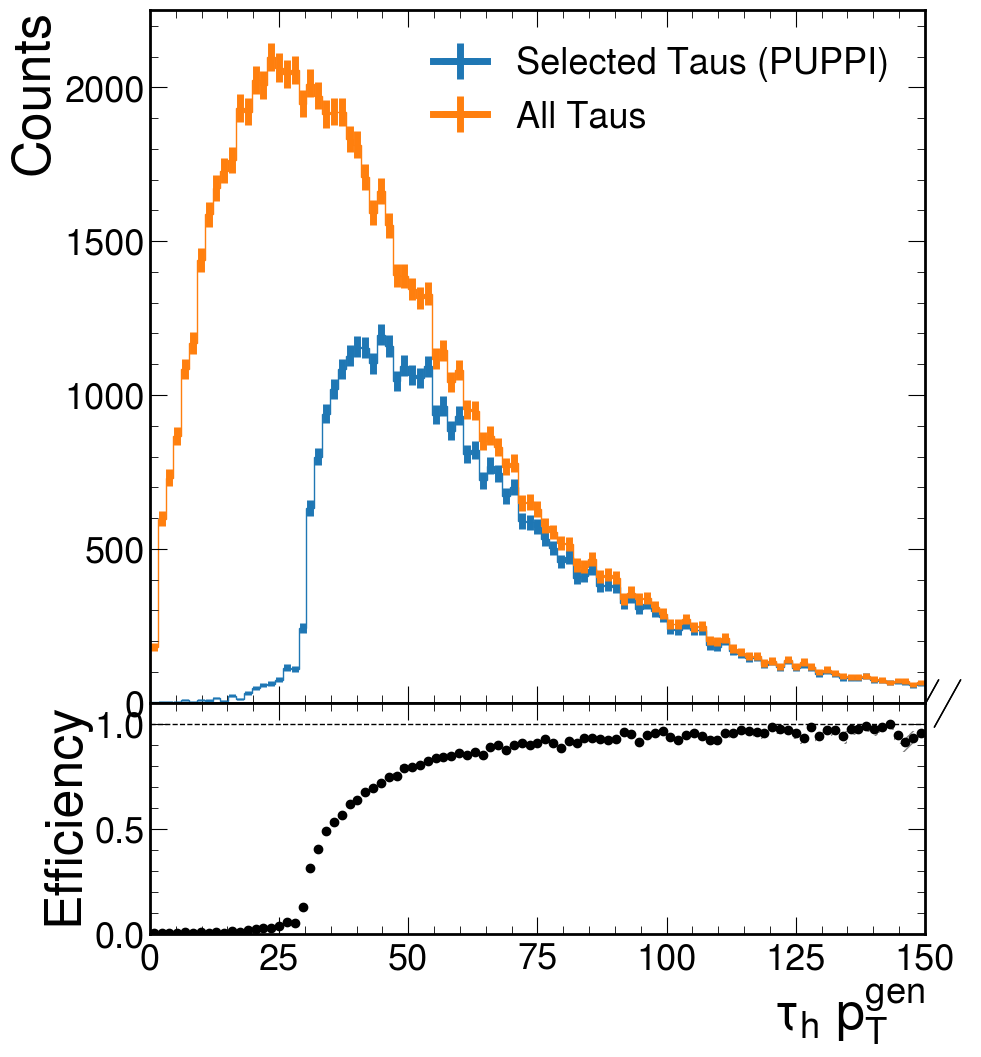

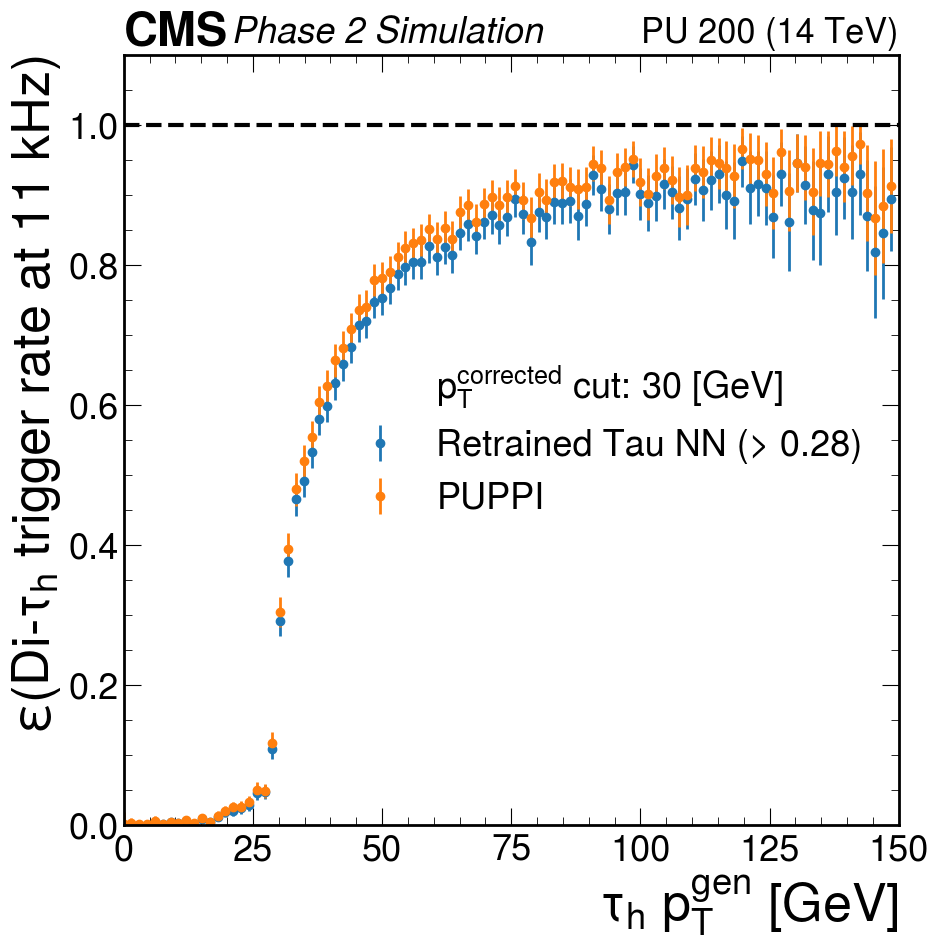

1092/1092 [==============================] - 1s 1ms/step


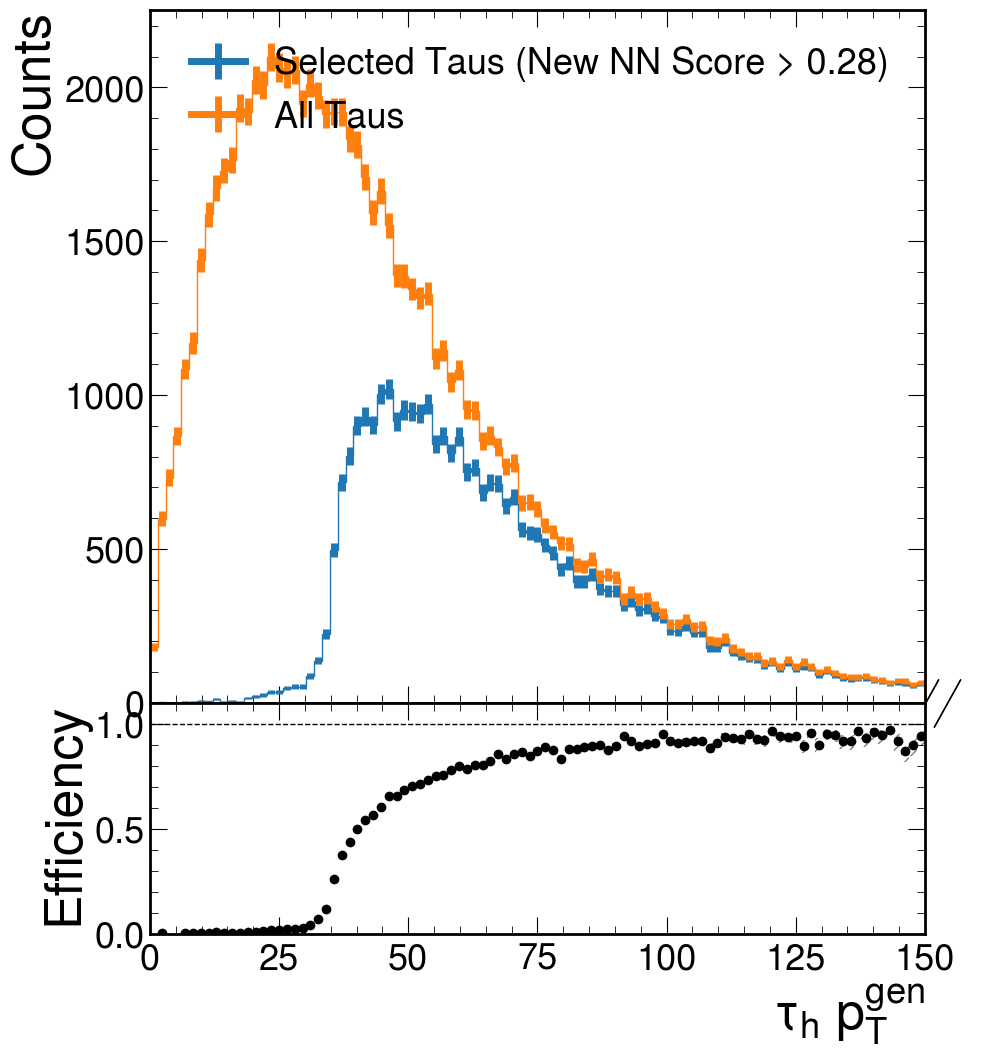

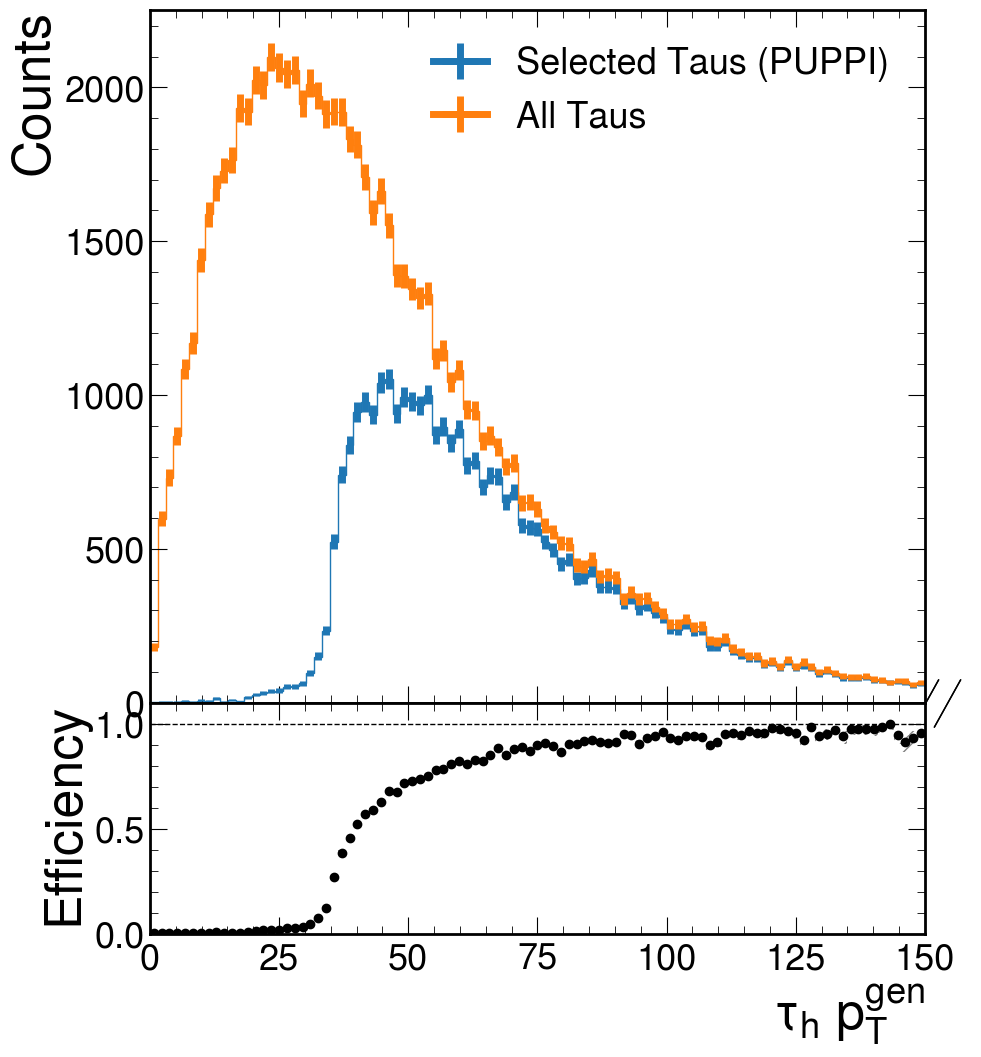

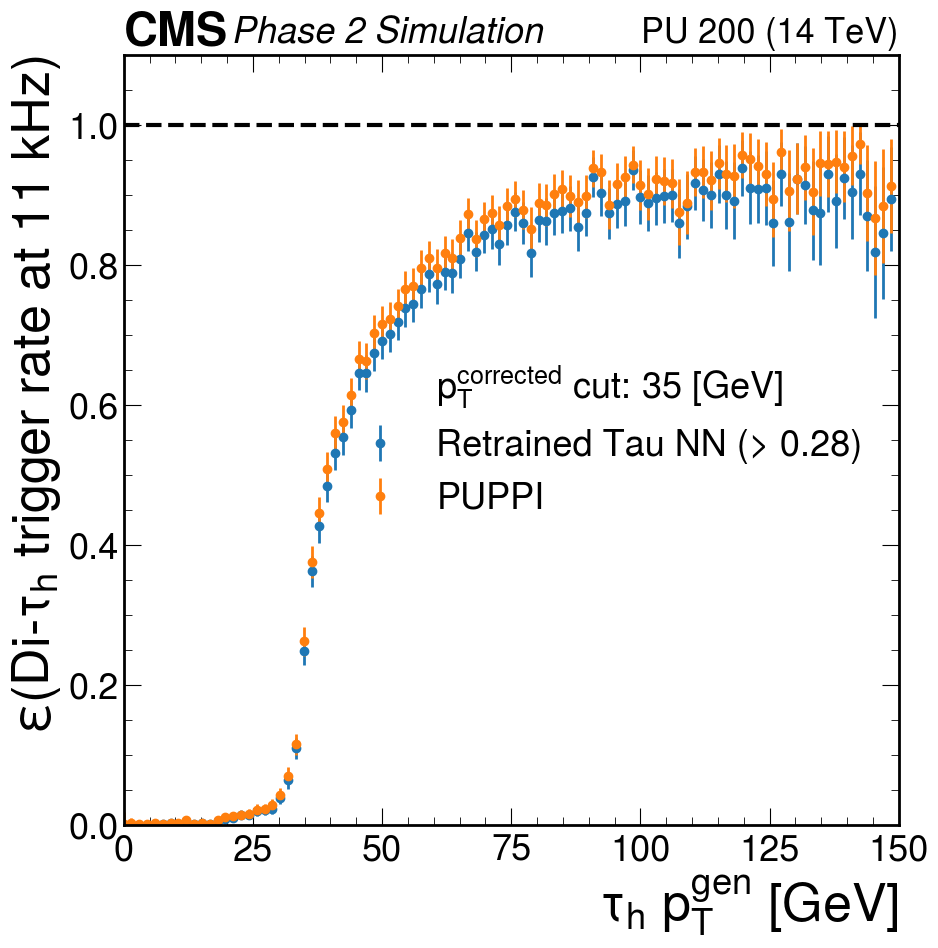

943/943 [==============================] - 1s 1ms/step


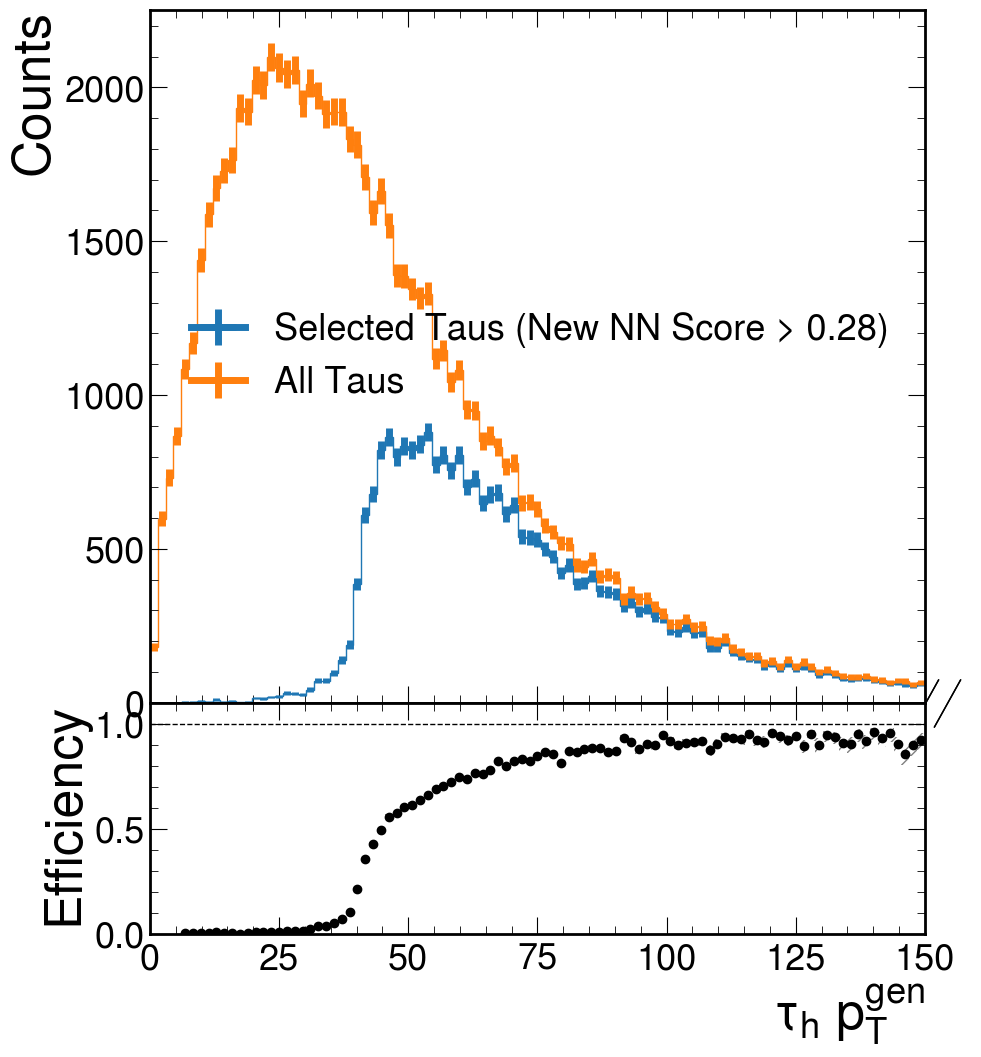

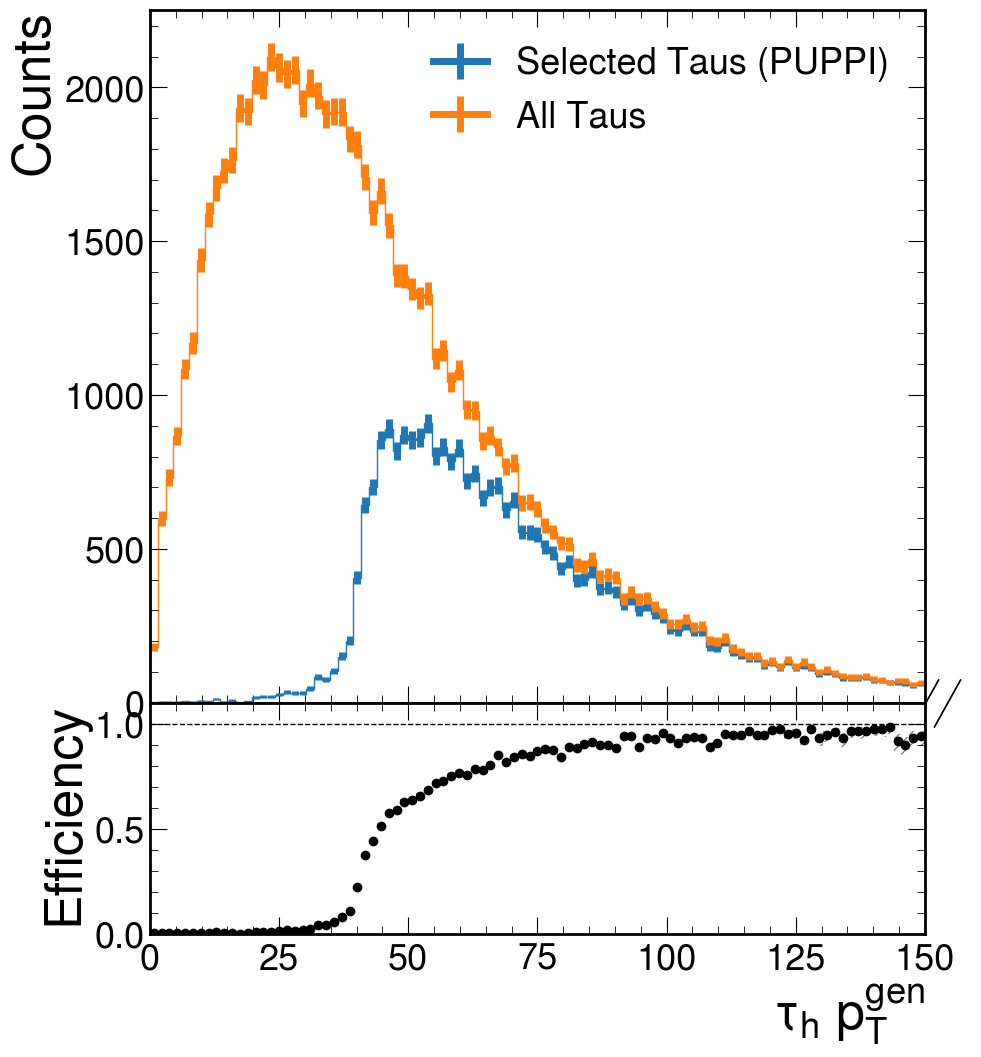

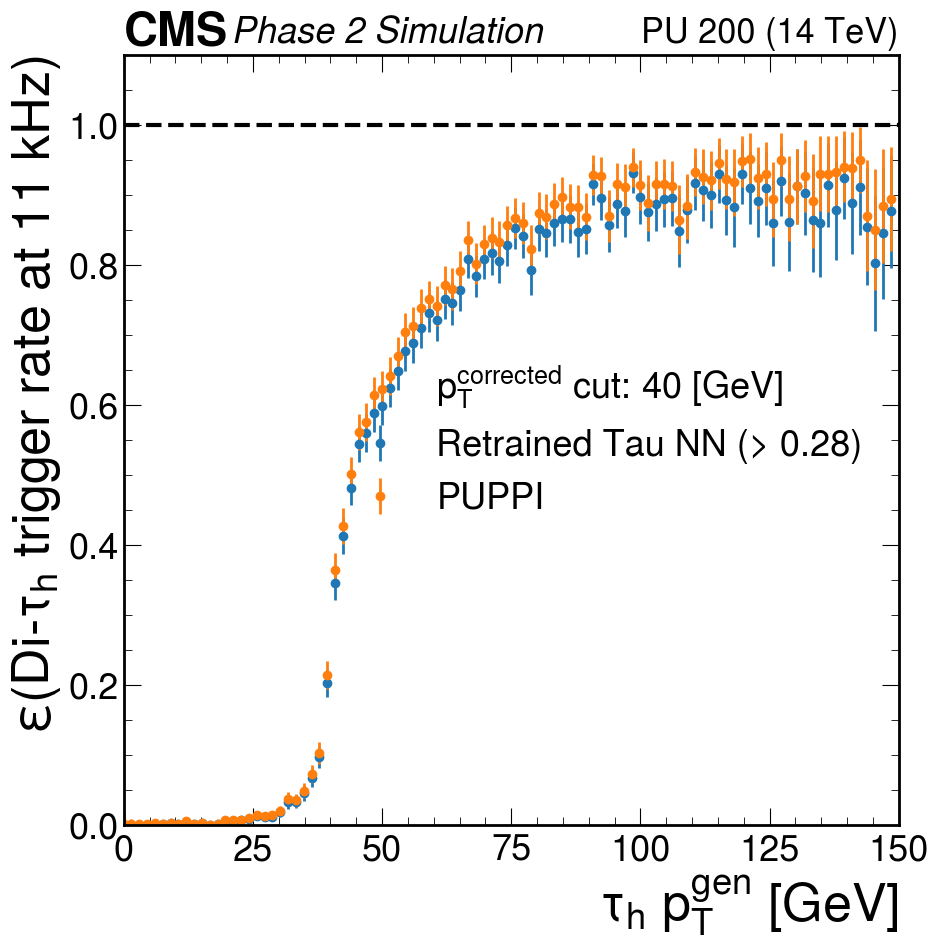

687/687 [==============================] - 1s 1ms/step


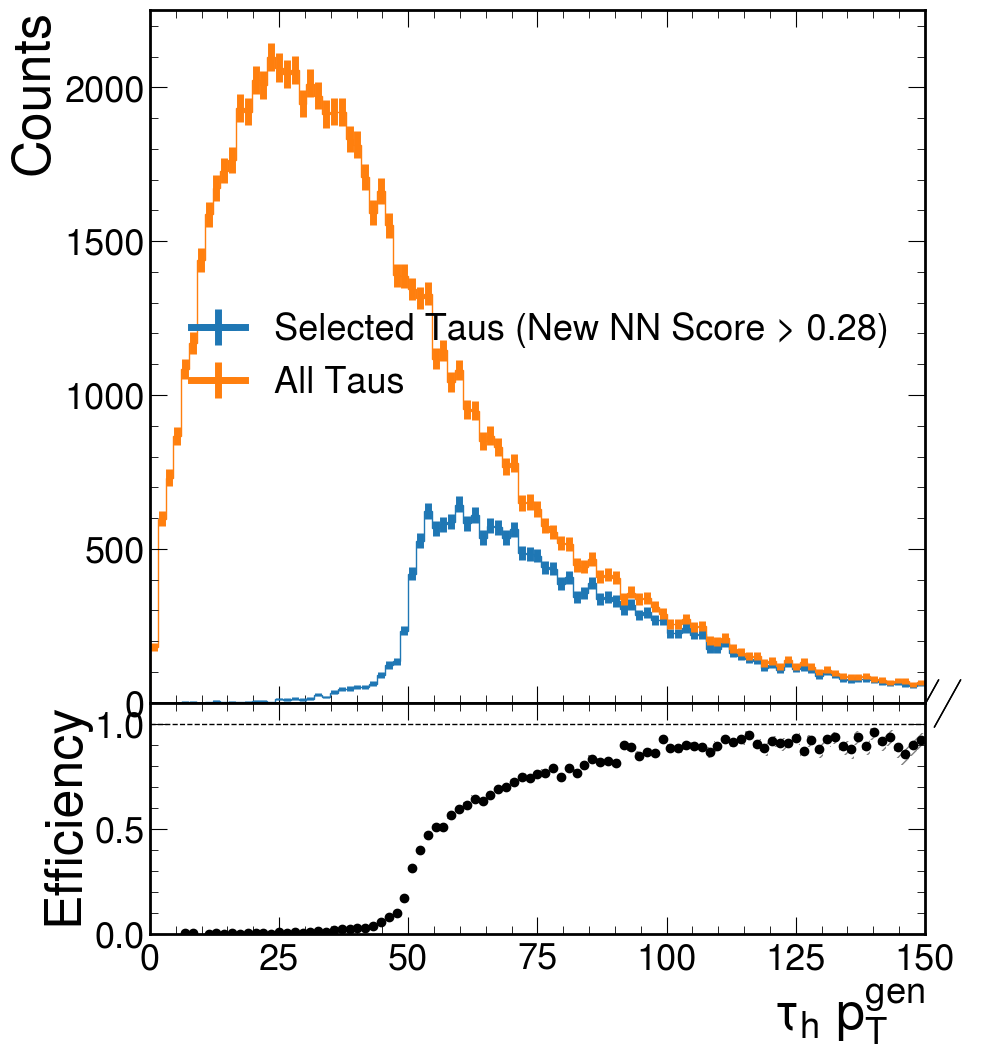

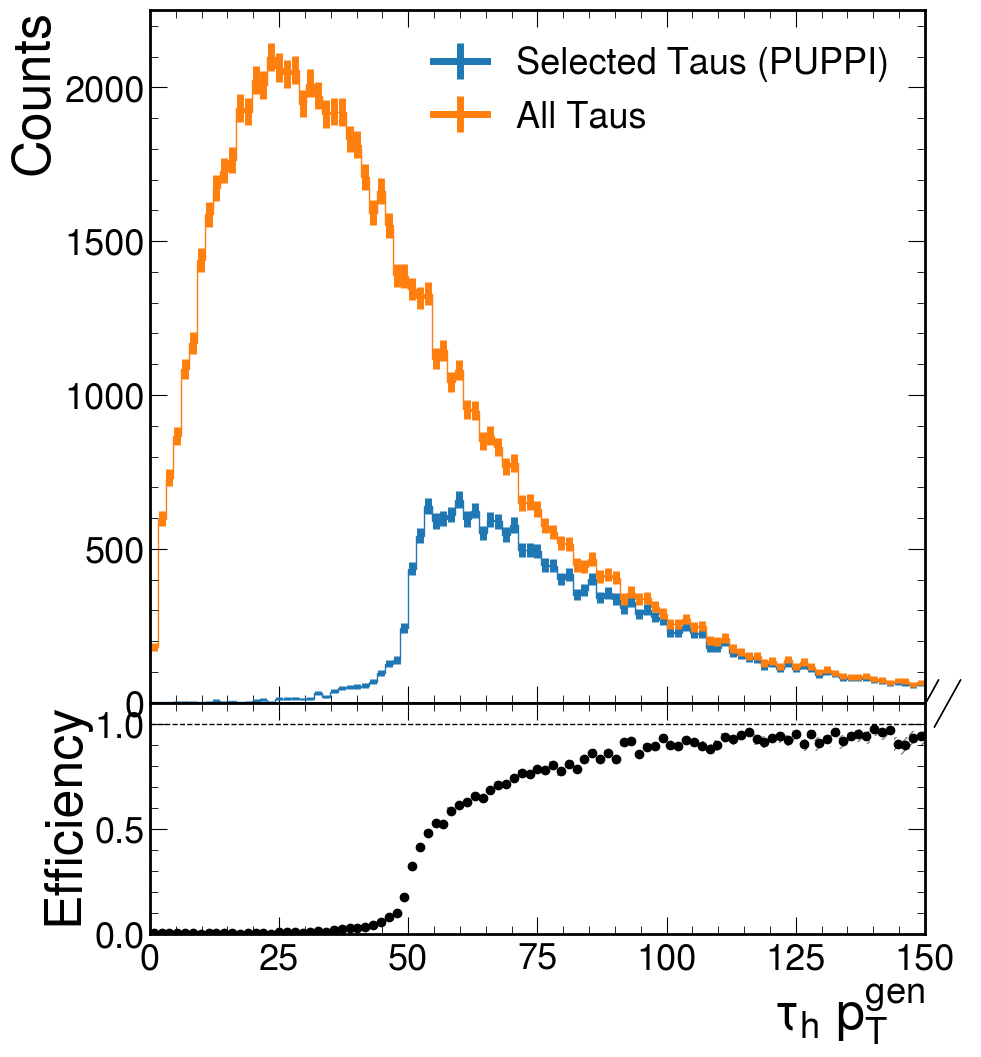

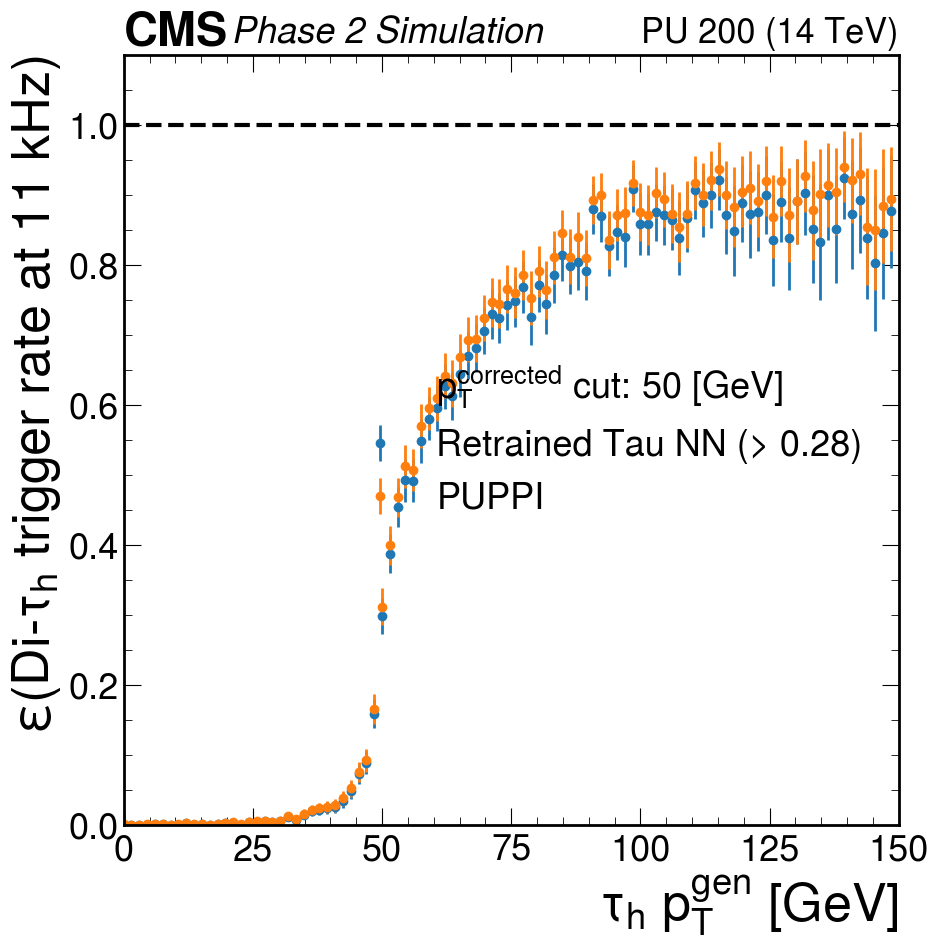

493/493 [==============================] - 1s 1ms/step


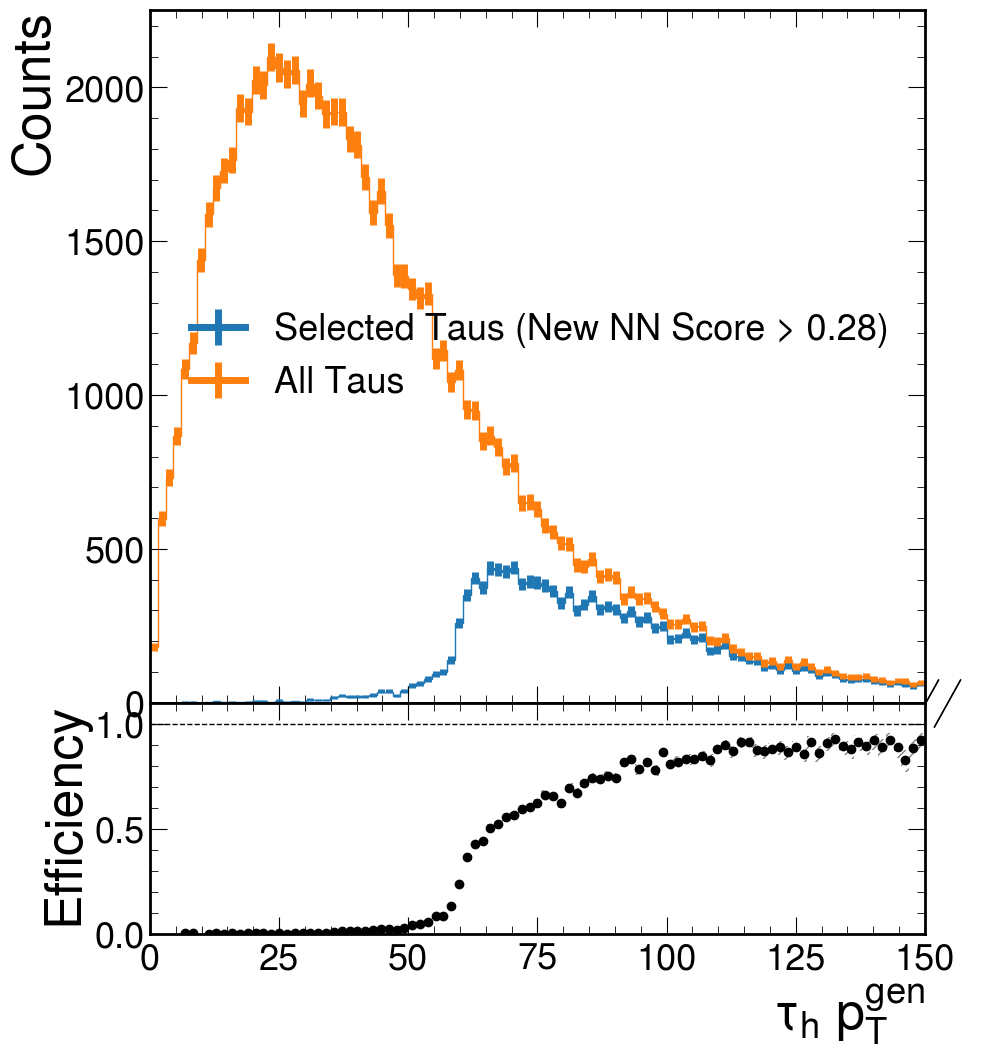

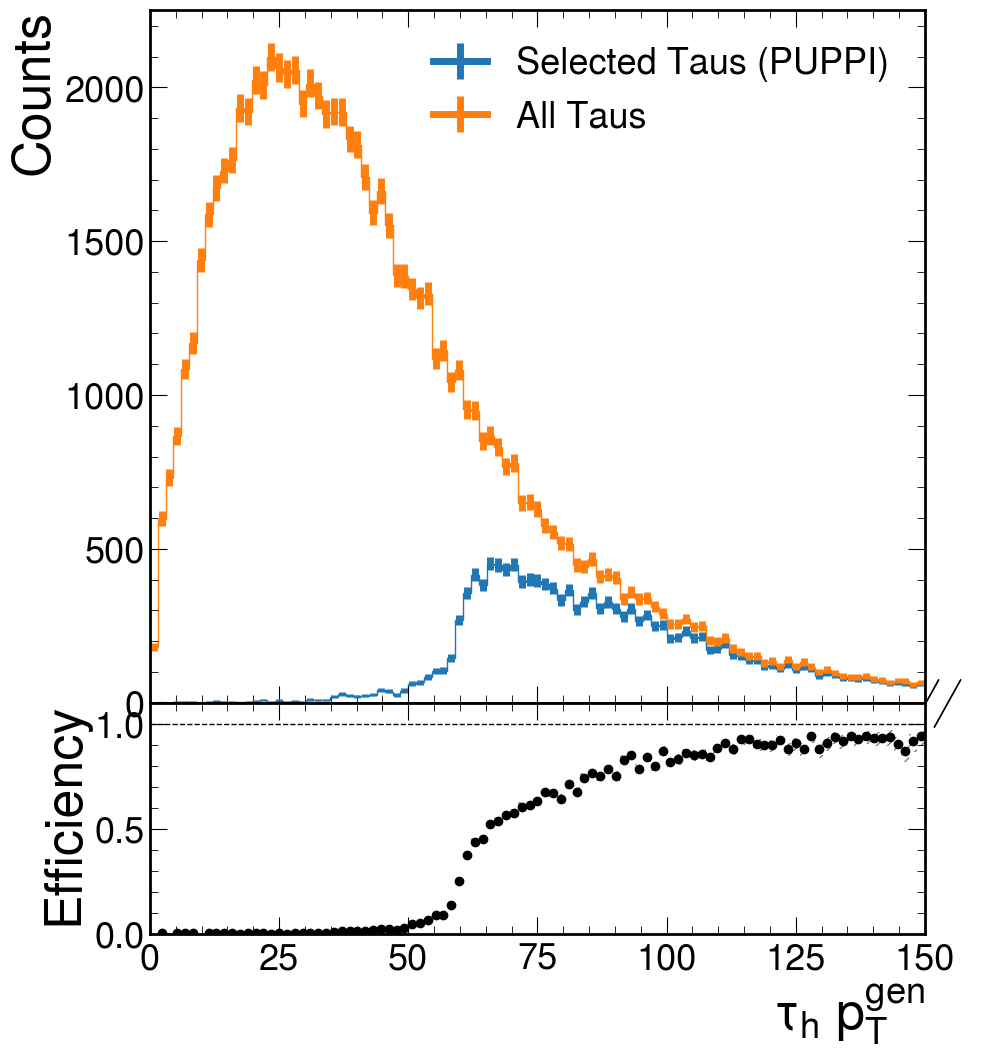

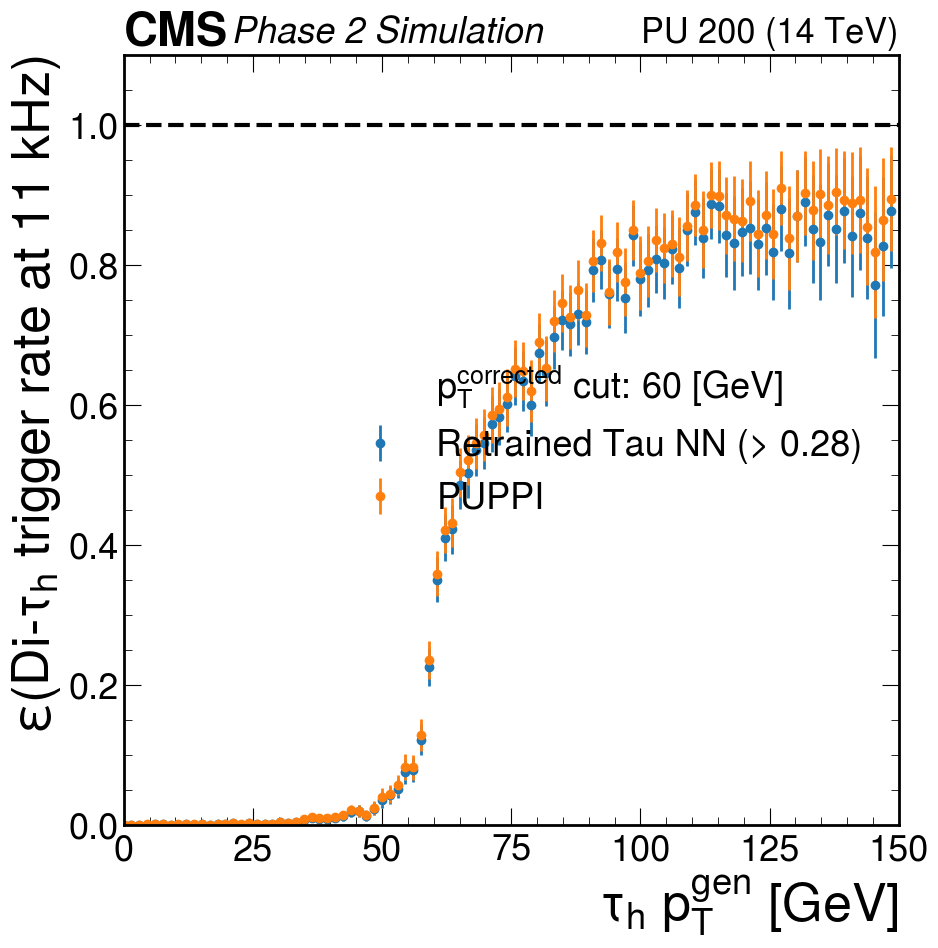

356/356 [==============================] - 0s 971us/step


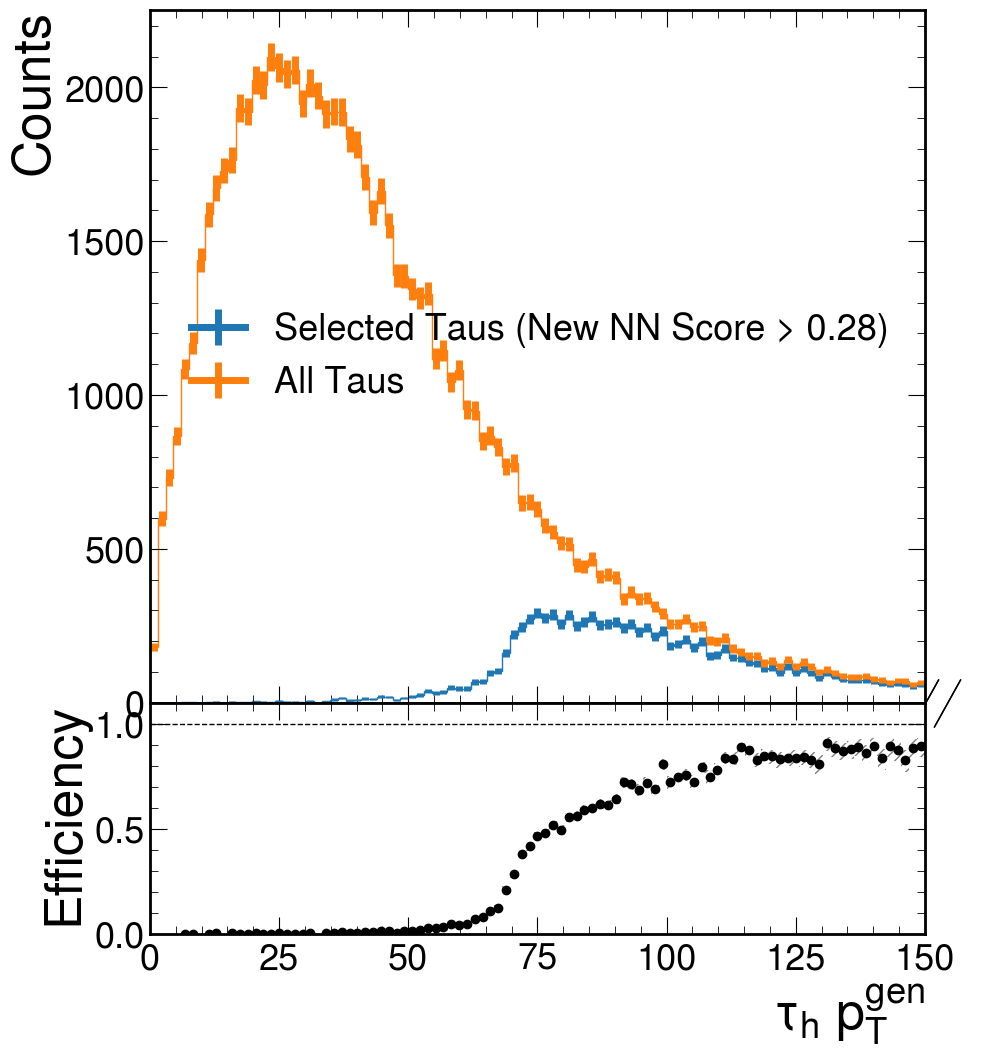

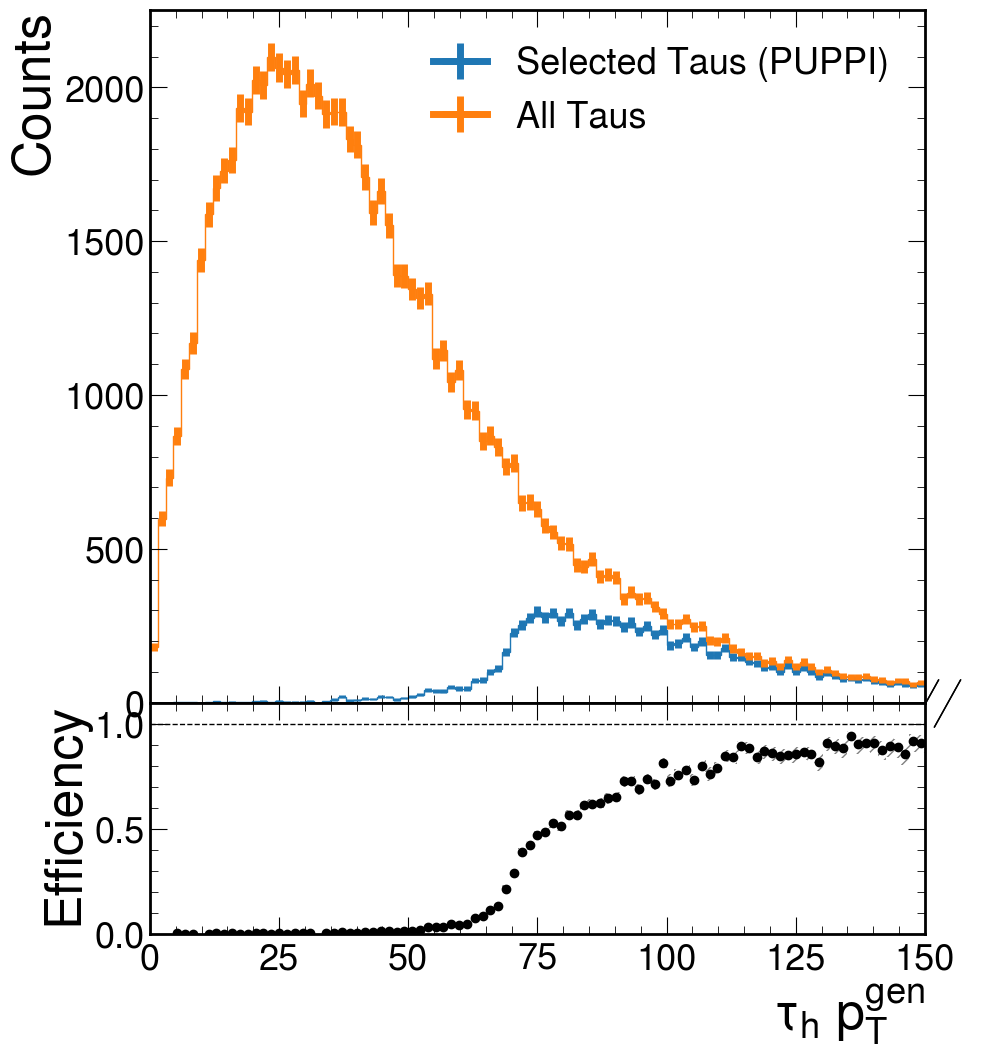

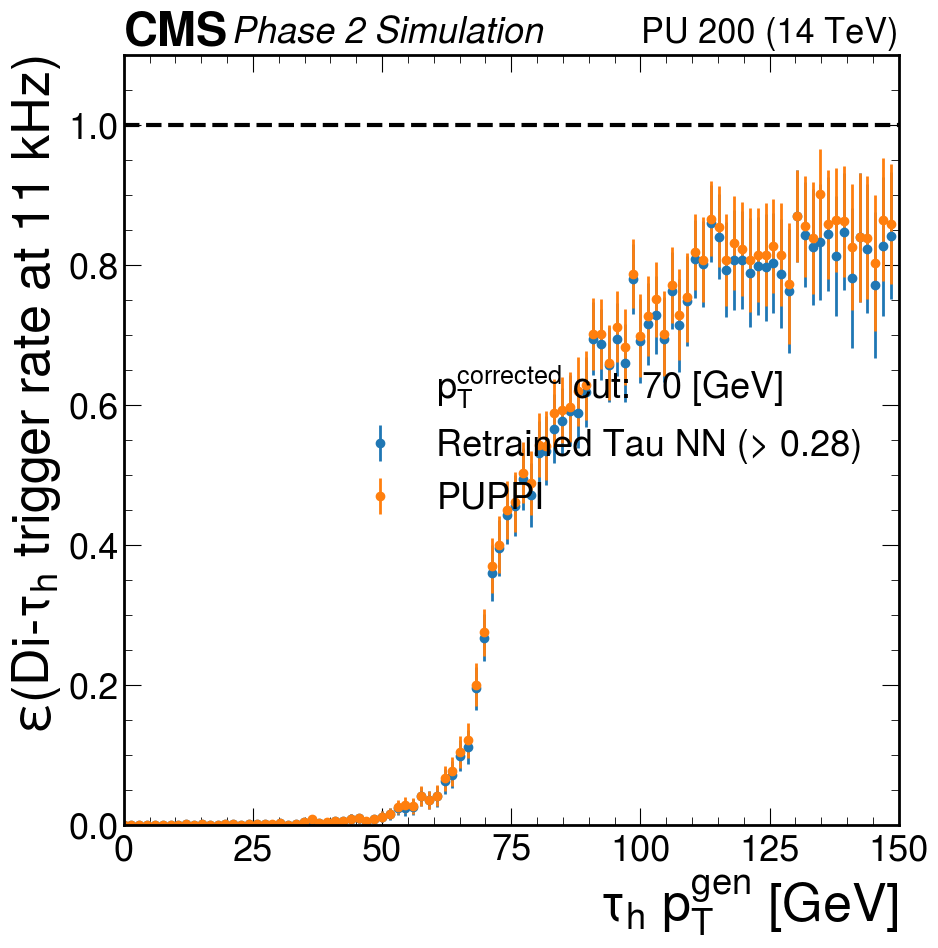

258/258 [==============================] - 0s 1ms/step


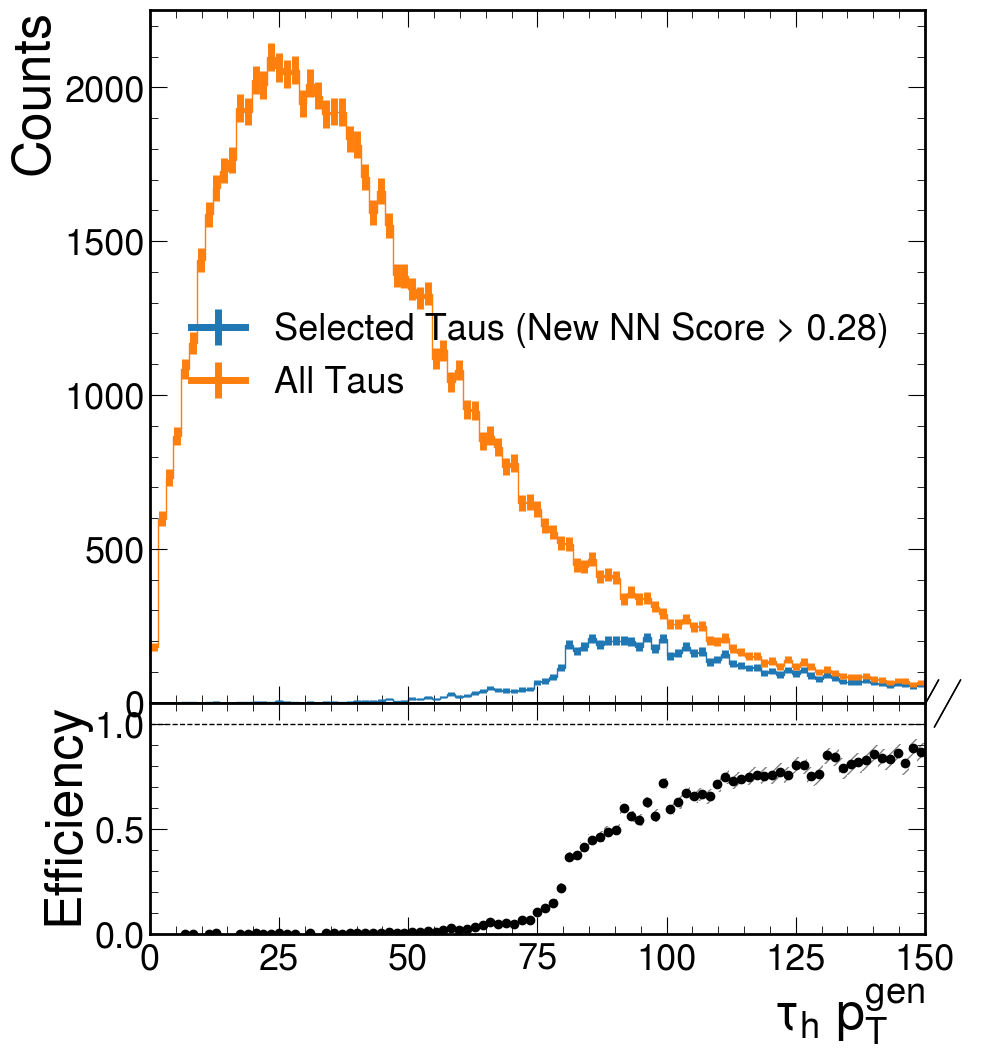

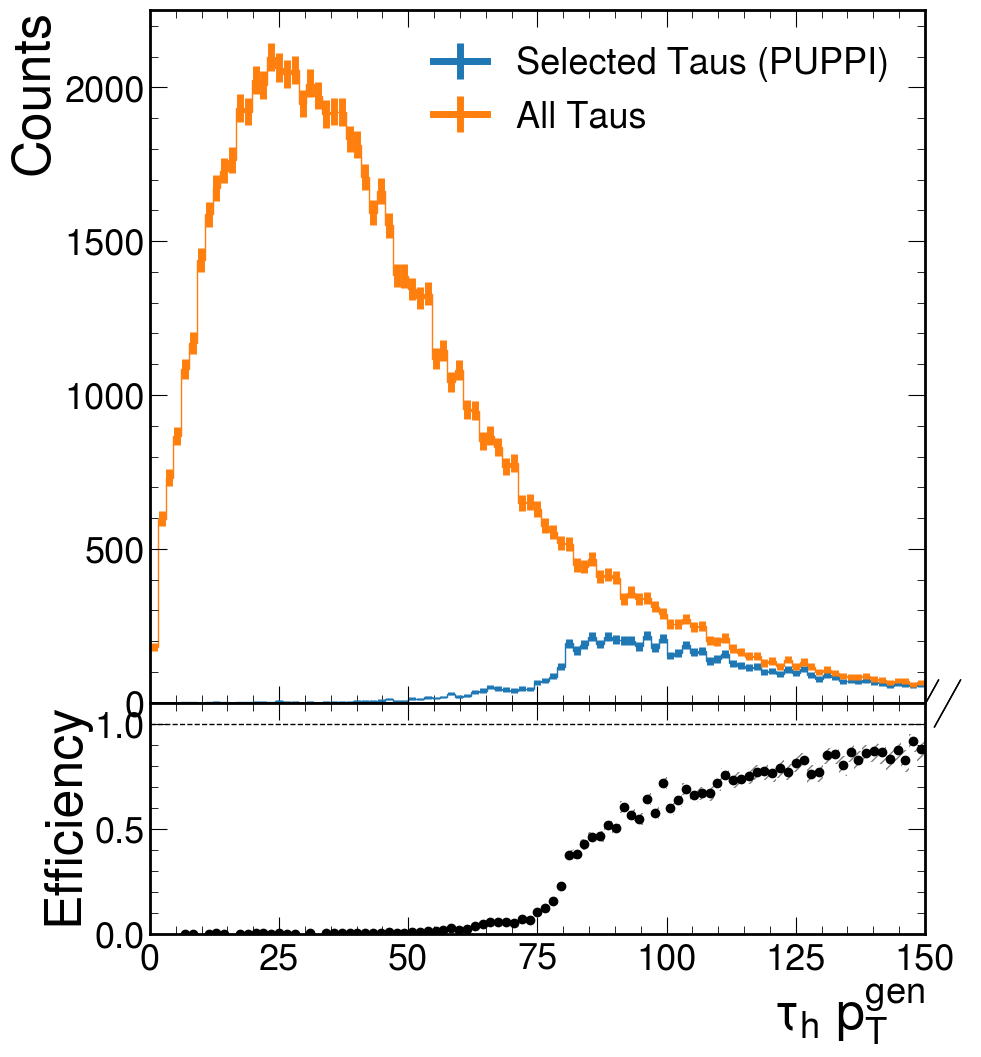

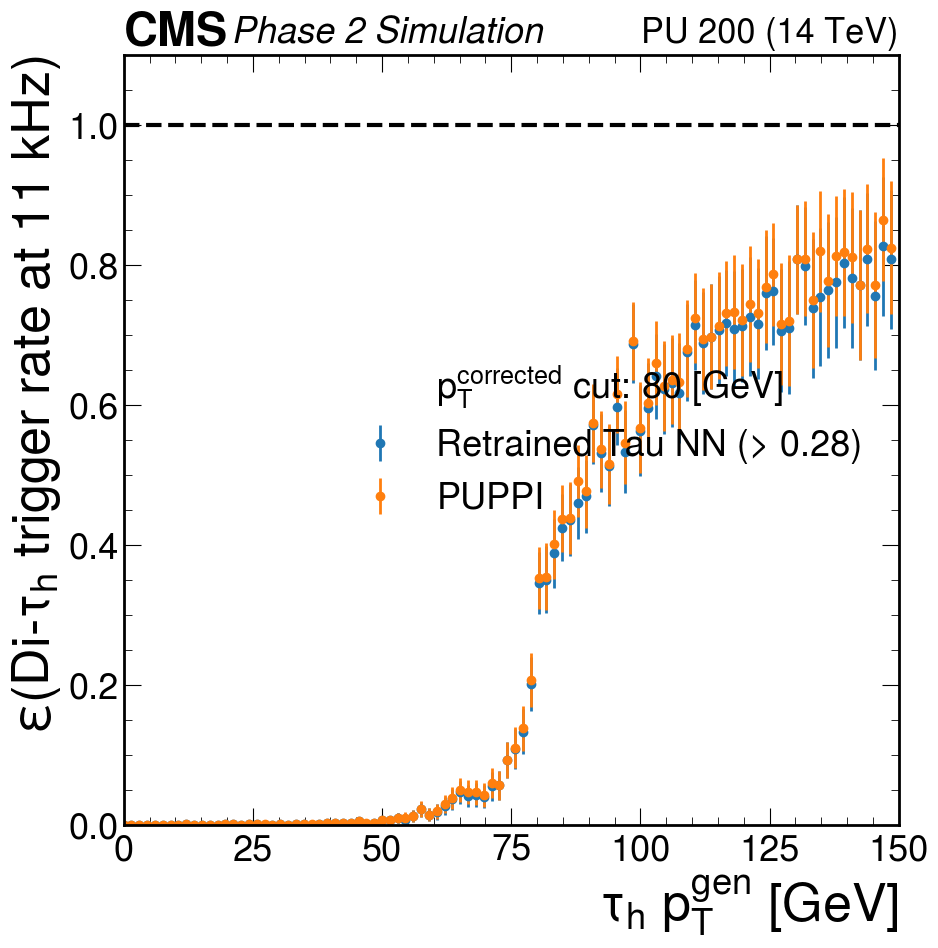

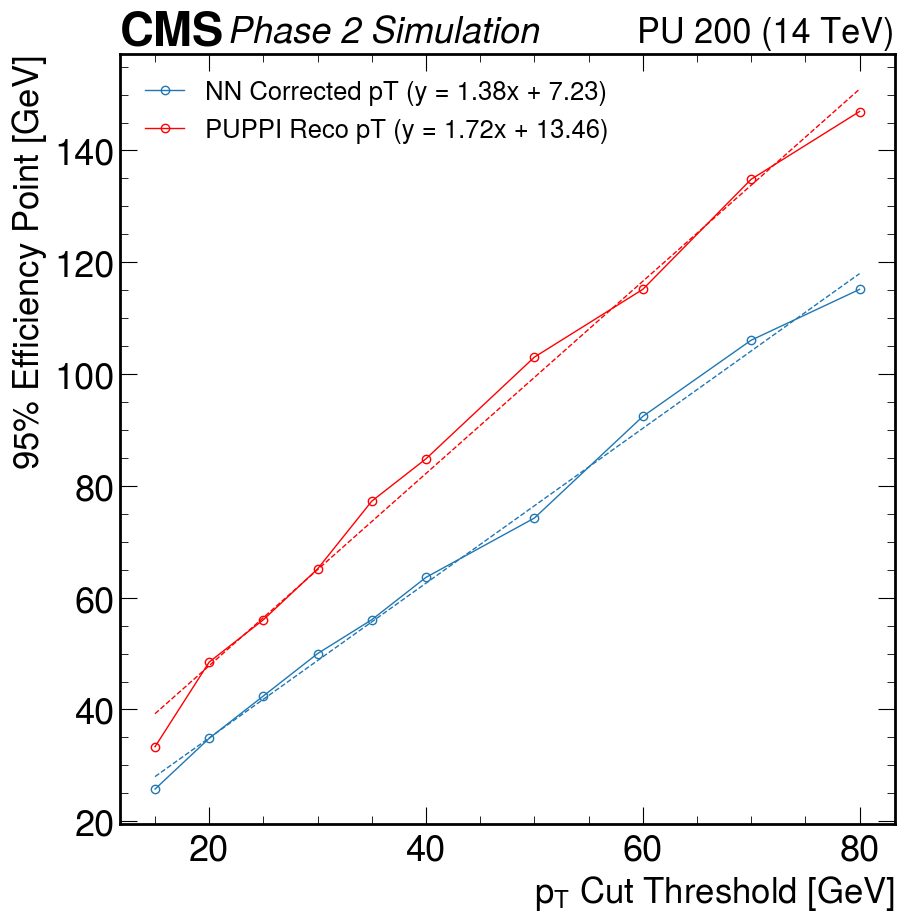

In [214]:
plot_95th([15, 20, 25,30,35,40,50,60,70,80], model_id_name,
                               model, '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root')

In [215]:
#model.save('../models/pt_regress_v1_bestest.h5')